In [1]:
from symred.symplectic_form import PauliwordOp, StabilizerOp, AnsatzOp, ObservableOp, QuantumState
from symred.S3_projection import (S3_projection, 
                                  gf2_gaus_elim, 
                                  gf2_basis_for_gf2_rref, 
                                  QubitTapering, 
                                  CS_VQE, 
                                  CheatS_VQE)
from symred.build_model import build_molecule_for_projection
from symred.utils import exact_gs_energy, quasi_model
import json
import numpy as np
from openfermion import FermionOperator
from scipy.sparse.linalg import expm
from openfermion import get_sparse_operator
from pyscf.cc.addons import spatial2spin


import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_ST

# Build the molecule

In [151]:
# Set molecule parameters
speciesname = 'H4_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = '3-21G' #mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))
#geometry = [('N', [0.0, 0.0, 0.5]), ('N', [0.0, 0.0, -0.5])]

xyz_file = str(len(atoms))+'\n '

for atom, coords in geometry:
    xyz_file += '\n'+atom+'\t'
    xyz_file += '\t'.join(list(map(str, coords)))

print(xyz_file)
xyz_file

4
 
H	0.0	0.0	0.0
H	1.0	0.0	0.0
H	0.0	1.0	0.0
H	1.0	1.0	0.0


'4\n \nH\t0.0\t0.0\t0.0\nH\t1.0\t0.0\t0.0\nH\t0.0\t1.0\t0.0\nH\t1.0\t1.0\t0.0'

In [152]:
from symred.chem import PySCFDriver

convergence = 1e6; max_hf_cycles=100_000; ram = 8_000
run_mp2  = True; run_cisd = False; run_ccsd = True; run_fci  = True

pyscf_obj = PySCFDriver(xyz_file,
                        basis,
                        #convergence=convergence,
                        charge=charge,
                        #max_ram_memory=ram,
                        #max_hf_cycles=max_hf_cycles,                   
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)

In [153]:
pyscf_obj.run_pyscf()

print('HF converged?  ', pyscf_obj.pyscf_hf.converged)
print('CCSD converged?', pyscf_obj.pyscf_ccsd.converged)
print('FCI converged? ', pyscf_obj.pyscf_fci.converged)

hf_energy = pyscf_obj.pyscf_hf.e_tot
mp2_energy = pyscf_obj.pyscf_mp2.e_tot
ccsd_energy = pyscf_obj.pyscf_ccsd.e_tot
fci_energy = pyscf_obj.pyscf_fci.e_tot

print()
print(f'HF energy: {hf_energy}')
print(f'MP2 energy: {mp2_energy}')
print(f'CCSD energy: {ccsd_energy}')
print(f'FCI energy: {fci_energy}')

HF converged?   True
CCSD converged? False
FCI converged?  True

HF energy: -1.9061273442772624
MP2 energy: -1.9588296295670975
CCSD energy: -2.0200995549520457
FCI energy: -2.024495410528324


In [154]:
from symred.chem import FermionicHamilt
import openfermion as of

H_ferm = FermionicHamilt(pyscf_obj.pyscf_hf)
H_ferm.build_operator()
n_qubits = H_ferm.n_qubits
print('Number of qubits:', n_qubits)

Number of qubits: 16


In [155]:
ham_fermionic = of.get_fermion_operator(H_ferm.fermionic_molecular_hamiltonian)
ham_jw = of.jordan_wigner(ham_fermionic)

In [156]:
def QubitOperator_to_dict(op, num_qubits):
    assert(type(op) == of.QubitOperator)
    op_dict = {}
    term_dict = op.terms
    terms = list(term_dict.keys())

    for t in terms:    
        letters = ['I' for i in range(num_qubits)]
        for i in t:
            letters[i[0]] = i[1]
        p_string = ''.join(letters)        
        op_dict[p_string] = term_dict[t]
         
    return op_dict

ham_dict = QubitOperator_to_dict(ham_jw, n_qubits)
ham = ObservableOp({op:coeff for op,coeff in ham_dict.items() if coeff.imag==0})

print('Jordan-Wigner Hamiltonian:\n\n', ham)

Jordan-Wigner Hamiltonian:

 6.1895476083 IIIIIIIIIIIIIIII +
-0.5373368672 ZIIIIIIIIIIIIIII +
0.1006280038 YZZZZZZZYIIIIIII +
0.1006280038 XZZZZZZZXIIIIIII +
-0.0000016399 YZZZZZZZZZZZZZYI +
-0.0000016399 XZZZZZZZZZZZZZXI +
-0.5373368672 IZIIIIIIIIIIIIII +
0.1006280038 IYZZZZZZZYIIIIII +
0.1006280038 IXZZZZZZZXIIIIII +
-0.0000016399 IYZZZZZZZZZZZZZY +
-0.0000016399 IXZZZZZZZZZZZZZX +
-0.6806175701 IIZIIIIIIIIIIIII +
0.0000014110 IIYZYIIIIIIIIIII +
0.0000014110 IIXZXIIIIIIIIIII +
-0.1325028701 IIYZZZZZZZYIIIII +
-0.1325028701 IIXZZZZZZZXIIIII +
0.0001734687 IIYZZZZZZZZZYIII +
0.0001734687 IIXZZZZZZZZZXIII +
-0.6806175701 IIIZIIIIIIIIIIII +
0.0000014110 IIIYZYIIIIIIIIII +
0.0000014110 IIIXZXIIIIIIIIII +
-0.1325028701 IIIYZZZZZZZYIIII +
-0.1325028701 IIIXZZZZZZZXIIII +
0.0001734687 IIIYZZZZZZZZZYII +
0.0001734687 IIIXZZZZZZZZZXII +
-0.6654979943 IIIIZIIIIIIIIIII +
-0.0001354961 IIIIYZZZZZYIIIII +
-0.0001354961 IIIIXZZZZZXIIIII +
-0.0993643571 IIIIYZZZZZZZYIII +
-0.0993643571 IIIIXZZZZZZZX

In [157]:
# singles

t1 = spatial2spin(pyscf_obj.pyscf_ccsd.t1)
no, nv = t1.shape
nmo = no + nv
ccsd_single_amps = np.zeros((nmo, nmo))
ccsd_single_amps[no:,:no] = t1.T

single_amplitudes_list = []
for i, j in zip(*ccsd_single_amps.nonzero()):
    single_amplitudes_list.append([[i, j], ccsd_single_amps[i, j]])

generator_t1 = FermionOperator()
for (i, j), t_ij in single_amplitudes_list:
    i, j = int(i), int(j)
    generator_t1 += FermionOperator(((i, 1), (j, 0)), t_ij)
    
T1_dict = QubitOperator_to_dict(of.jordan_wigner(generator_t1), n_qubits)
try:
    T1 = PauliwordOp(T1_dict)
    T1 -= T1.conjugate
    T1 = T1.cleanup_zeros()
    T1 = T1.multiply_by_constant(-1j)
    print('Single excitation terms:\n\n', T1)
except:
    print('No single excitations')

Single excitation terms:

 -0.0000151215+0.0000000000j IIIXZZZZZZZZZYII +
0.0000151215-0.0000000000j IIIYZZZZZZZZZXII +
0.0179327566-0.0000000000j IIIXZZZZZZZYIIII +
-0.0179327566+0.0000000000j IIIYZZZZZZZXIIII +
-0.0001257056+0.0000000000j IIIXZYIIIIIIIIII +
0.0001257056-0.0000000000j IIIYZXIIIIIIIIII +
-0.0000151215+0.0000000000j IIXZZZZZZZZZYIII +
0.0000151215-0.0000000000j IIYZZZZZZZZZXIII +
0.0179327566-0.0000000000j IIXZZZZZZZYIIIII +
-0.0179327566+0.0000000000j IIYZZZZZZZXIIIII +
-0.0001257056+0.0000000000j IIXZYIIIIIIIIIII +
0.0001257056-0.0000000000j IIYZXIIIIIIIIIII +
0.0000019181-0.0000000000j IXZZZZZZZZZZZZZY +
-0.0000019181+0.0000000000j IYZZZZZZZZZZZZZX +
-0.0044478436+0.0000000000j IXZZZZZZZYIIIIII +
0.0044478436-0.0000000000j IYZZZZZZZXIIIIII +
0.0000002505-0.0000000000j IXZZZZZYIIIIIIII +
-0.0000002505+0.0000000000j IYZZZZZXIIIIIIII +
0.0000019181-0.0000000000j XZZZZZZZZZZZZZYI +
-0.0000019181+0.0000000000j YZZZZZZZZZZZZZXI +
-0.0044478436+0.0000000000j XZZZZZZZYIIIIII

In [158]:
# doubles!

t2 = spatial2spin(pyscf_obj.pyscf_ccsd.t2)
no, nv = t2.shape[1:3]
nmo = no + nv
double_amps = np.zeros((nmo, nmo, nmo, nmo))
double_amps[no:,:no,no:,:no] = .5 * t2.transpose(2,0,3,1)

double_amplitudes_list=[]
double_amplitudes = double_amps
for i, j, k, l in zip(*double_amplitudes.nonzero()):
    if not np.isclose(double_amplitudes[i, j, k, l], 0):
        double_amplitudes_list.append([[i, j, k, l],
                                       double_amplitudes[i, j, k, l]])
    
generator_t2 = FermionOperator()

# Add double excitations
for (i, j, k, l), t_ijkl in double_amplitudes_list:
    i, j, k, l = int(i), int(j), int(k), int(l)
    generator_t2 += FermionOperator(((i, 1), (j, 0), (k, 1), (l, 0)), t_ijkl)
#     if anti_hermitian:
#         generator += FermionOperator(((l, 1), (k, 0), (j, 1), (i, 0)),
#                                      -t_ijkl)

T2_dict = QubitOperator_to_dict(of.jordan_wigner(generator_t2), n_qubits)
T2 = PauliwordOp(T2_dict)
T2 -= T2.conjugate
T2 = T2.cleanup_zeros()
T2 = T2.multiply_by_constant(-1j)


print('Double excitation terms:\n\n', T2)

Double excitation terms:

 0.0008166986-0.0000000000j IIXXIIIIIIIIIIXY +
0.0008166986-0.0000000000j IIXXIIIIIIIIIIYX +
-0.0008166986+0.0000000000j IIXYIIIIIIIIIIXX +
0.0008166986-0.0000000000j IIXYIIIIIIIIIIYY +
-0.0008166986+0.0000000000j IIYXIIIIIIIIIIXX +
0.0008166986-0.0000000000j IIYXIIIIIIIIIIYY +
-0.0008166986+0.0000000000j IIYYIIIIIIIIIIXY +
-0.0008166986+0.0000000000j IIYYIIIIIIIIIIYX +
-0.0010576868+0.0000000000j IIXXIIIIIIIIXYII +
-0.0010576868+0.0000000000j IIXXIIIIIIIIYXII +
0.0010576868-0.0000000000j IIXYIIIIIIIIXXII +
-0.0010576868+0.0000000000j IIXYIIIIIIIIYYII +
0.0010576868-0.0000000000j IIYXIIIIIIIIXXII +
-0.0010576868+0.0000000000j IIYXIIIIIIIIYYII +
0.0010576868-0.0000000000j IIYYIIIIIIIIXYII +
0.0010576868-0.0000000000j IIYYIIIIIIIIYXII +
0.0000069827-0.0000000000j IIXXIIIIIIIXYIII +
0.0000069827-0.0000000000j IIXXIIIIIIIYXIII +
-0.0000069827+0.0000000000j IIXYIIIIIIIXXIII +
0.0000069827-0.0000000000j IIXYIIIIIIIYYIII +
-0.0000069827+0.0000000000j IIYXIIIIIIIXXIII

In [159]:
try:
    T_antiherm = T1 + T2.multiply_by_constant(0.5)
except:
    T_antiherm = T2.multiply_by_constant(0.5)

T_antiherm = AnsatzOp(T_antiherm.symp_matrix, T_antiherm.coeff_vec)
print('UCCSD operator:\n\n', T_antiherm)

UCCSD operator:

 -0.0000151215 IIIXZZZZZZZZZYII +
0.0000151215 IIIYZZZZZZZZZXII +
0.0179327566 IIIXZZZZZZZYIIII +
-0.0179327566 IIIYZZZZZZZXIIII +
-0.0001257056 IIIXZYIIIIIIIIII +
0.0001257056 IIIYZXIIIIIIIIII +
-0.0000151215 IIXZZZZZZZZZYIII +
0.0000151215 IIYZZZZZZZZZXIII +
0.0179327566 IIXZZZZZZZYIIIII +
-0.0179327566 IIYZZZZZZZXIIIII +
-0.0001257056 IIXZYIIIIIIIIIII +
0.0001257056 IIYZXIIIIIIIIIII +
0.0004083493 IIXXIIIIIIIIIIXY +
0.0004083493 IIXXIIIIIIIIIIYX +
-0.0004083493 IIXYIIIIIIIIIIXX +
0.0004083493 IIXYIIIIIIIIIIYY +
-0.0004083493 IIYXIIIIIIIIIIXX +
0.0004083493 IIYXIIIIIIIIIIYY +
-0.0004083493 IIYYIIIIIIIIIIXY +
-0.0004083493 IIYYIIIIIIIIIIYX +
-0.0005288434 IIXXIIIIIIIIXYII +
-0.0005288434 IIXXIIIIIIIIYXII +
0.0005288434 IIXYIIIIIIIIXXII +
-0.0005288434 IIXYIIIIIIIIYYII +
0.0005288434 IIYXIIIIIIIIXXII +
-0.0005288434 IIYXIIIIIIIIYYII +
0.0005288434 IIYYIIIIIIIIXYII +
0.0005288434 IIYYIIIIIIIIYXII +
0.0000034913 IIXXIIIIIIIXYIII +
0.0000034913 IIXXIIIIIIIYXIII +
-0.00000

In [160]:
hf_array = H_ferm.hf_comp_basis_state
hf_state = QuantumState([hf_array])
print('Reference state:', hf_state)
print()

op = T_antiherm.copy()
op.coeff_vec = np.sin(1j*op.coeff_vec)

uccsd_state_rough = ((op * hf_state) + hf_state).normalize
print('Rough UCCSD state:\n')
print(uccsd_state_rough)

#print()
#uccsd_state = T_antiherm.exponentiate() * hf_state
#print('UCCSD state:\n')
#print(uccsd_state)

Reference state:  1.0000000000 |1111000000000000>

Rough UCCSD state:

-0.0144637172+0.0000000000j |0011000000000011> +
-0.0152480352+0.0000000000j |0011000000001100> +
 0.0000047002+0.0000000000j |0011000000011000> +
-0.0000047002+0.0000000000j |0011000000100100> +
-0.0112556740+0.0000000000j |0011000000110000> +
-0.0120939509+0.0000000000j |0011000011000000> +
-0.0172903099+0.0000000000j |0011000100000010> +
-0.0000007998+0.0000000000j |0011000110000000> +
 0.0172903099+0.0000000000j |0011001000000001> +
 0.0000007998+0.0000000000j |0011001001000000> +
-0.0290693443+0.0000000000j |0011001100000000> +
-0.0185737175+0.0000000000j |0011010000001000> +
-0.0000201386+0.0000000000j |0011010000100000> +
 0.0185737175+0.0000000000j |0011100000000100> +
 0.0000201386+0.0000000000j |0011100000010000> +
-0.0091298318+0.0000000000j |0011110000000000> +
-0.0037714468+0.0000000000j |0101000000001010> +
-0.0000052688+0.0000000000j |0101000000100010> +
 0.0000055535+0.0000000000j |0101000010001000> 

# Build Second-order response Hamiltonian

In [161]:
def sor_data():
    """ Calculate the w(i) function 
    as in https://arxiv.org/pdf/1406.4920.pdf
    """
    w = {i:0 for i in range(ham.n_qubits)}
    for f_op,coeff in ham_fermionic.terms.items():
        if len(f_op)==2:
            (p,p_ex),(q,q_ex) = f_op
            # self-interaction terms p==q
            if p==q:
                w[p] += coeff
        if len(f_op)==4:
            (p,p_ex),(q,q_ex),(r,r_ex),(s,s_ex) = f_op
            #want p==r and q==s for hopping
            if p==r:
                if q==s and hf_array[q]==1:
                    w[p]+=coeff
    return w

def second_order_response():
    """ Calculate the I_a Hamiltonian term importance metric 
    as in https://arxiv.org/pdf/1406.4920.pdf
    """
    w = sor_data()
    f_out = FermionOperator()
    for H_a,coeff in ham_fermionic.terms.items():
        if len(H_a)==4:
            (p,p_ex),(q,q_ex),(r,r_ex),(s,s_ex) = H_a
            Delta_pqrs = abs(w[p]+w[q]-w[r]-w[s])
            if Delta_pqrs == 0:
                I_a = 1e15
            else:
                I_a = (abs(coeff)**2)/Delta_pqrs

            f_out += FermionOperator(H_a, I_a)
    f_out_jw = of.jordan_wigner(f_out)
    f_out_q = QubitOperator_to_dict(f_out_jw, ham.n_qubits)
    
    sor_ham = PauliwordOp(f_out_q)
    sor_ham.coeff_vec/=np.linalg.norm(sor_ham.coeff_vec) # normalize the coefficients
    
    return sor_ham.sort(key='magnitude')

sor_ham = second_order_response()

In [162]:
print(sor_ham)

0.8851367357+0.0000000000j IIIIIIIIIIIIIIII +
-0.1635298708+0.0000000000j IIIIIIIIIIIIIIZI +
-0.1635298708+0.0000000000j IIIIIIIIIIIIIIIZ +
-0.1087282765+0.0000000000j IIIIIIIIIZIIIIII +
-0.1087282765+0.0000000000j IIIIIIIIZIIIIIII +
-0.1067806108+0.0000000000j IIIIIIIIIIIIIZII +
-0.1067806108+0.0000000000j IIIIIIIIIIIIZIII +
-0.1063870994+0.0000000000j IZIIIIIIIIIIIIII +
-0.1063870994+0.0000000000j ZIIIIIIIIIIIIIII +
-0.1050966992+0.0000000000j IIIZIIIIIIIIIIII +
-0.1050966992+0.0000000000j IIZIIIIIIIIIIIII +
-0.1032848159+0.0000000000j IIIIIIIIIIIZIIII +
-0.1032848159+0.0000000000j IIIIIIIIIIZIIIII +
-0.0981485262+0.0000000000j IIIIIIZIIIIIIIII +
-0.0981485262+0.0000000000j IIIIIIIZIIIIIIII +
-0.0931808368+0.0000000000j IIIIZIIIIIIIIIII +
-0.0931808368+0.0000000000j IIIIIZIIIIIIIIII +
0.0164790457+0.0000000000j IZIIIIIIIIIIIIZI +
0.0164790457+0.0000000000j ZIIIIIIIIIIIIIIZ +
0.0151041985+0.0000000000j IZZIIIIIIIIIIIII +
0.0151041985+0.0000000000j IZIIIIZIIIIIIIII +
0.0151041985+0.000

In [163]:
hf_array

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Taper the molecule

In [164]:
from symred.S3_projection import QubitTapering

taper_hamiltonian = QubitTapering(ham)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand are rotated onto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
print('\nvia a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)

We are able to taper 3 qubits from the Hamiltonian.

The symmetry generators are

1+0j ZIIZIZZIZIIZIZZI +
1+0j IZIZIZIZIZIZIZIZ +
1+0j IIZZZZIIIIZZZZII

and are rotated onto the single-qubit Pauli operators

-1+0j IIXIIIIIIIIIIIII +
-1+0j IXIIIIIIIIIIIIII +
-1+0j XIIIIIIIIIIIIIII

via a sequence of Clifford pi/2 rotations

[('YIIZIZZIZIIZIZZI', None), ('IIYZZZIIIIZZZZII', None), ('IYIZIZIZIZIZIZIZ', None)]


In [165]:
sym_sectors = []
for term in uccsd_state_rough.state_matrix:
    taper_hamiltonian.stabilizers.update_sector(term)
    sym_sectors.append(taper_hamiltonian.stabilizers.coeff_vec)
sym_sectors = np.unique(np.array(sym_sectors), axis=0)
print(sym_sectors)

[[1 1 1]]


In [166]:
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'The symmetry sector corresponding with the single reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')

The symmetry sector corresponding with the single reference [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0] is [1 1 1]


In [167]:
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=T_antiherm, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

dashes = "------------------------------------------------"
print("Tapering information:")
print(dashes)
print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian')
print('The symmetry basis/sector is:') 
print(taper_hamiltonian.symmetry_generators)
print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))
print(dashes)

Tapering information:
------------------------------------------------
We are able to taper 3 qubits from the Hamiltonian
The symmetry basis/sector is:
1 ZIIZIZZIZIIZIZZI +
1 IZIZIZIZIZIZIZIZ +
1 IIZZZZIIIIZZZZII
The tapered Hartree-Fock state is  1.0000000000 |1000000000000>
------------------------------------------------


In [168]:
print(sor_tap.sort())

0.8851367357+0.0000000000j IIIIIIIIIIIII +
-0.1635298708+0.0000000000j IIIIIIIIIIIIZ +
-0.1635298708+0.0000000000j IIIIIIIIIIIZI +
-0.1087282765+0.0000000000j IIIIIIZIIIIII +
-0.1087282765+0.0000000000j IIIIIZIIIIIII +
-0.1067806108+0.0000000000j IIIIIIIIIIZII +
-0.1067806108+0.0000000000j IIIIIIIIIZIII +
-0.1063870994+0.0000000000j ZIZZIZIIZIZZI +
-0.1063870994+0.0000000000j ZIZIZIZIZIZIZ +
-0.1050966992+0.0000000000j ZIIIIIIIIIIII +
-0.1050966992+0.0000000000j ZZZIIIIZZZZII +
-0.1032848159+0.0000000000j IIIIIIIIZIIII +
-0.1032848159+0.0000000000j IIIIIIIZIIIII +
-0.0981485262+0.0000000000j IIIZIIIIIIIII +
-0.0981485262+0.0000000000j IIIIZIIIIIIII +
-0.0931808368+0.0000000000j IIZIIIIIIIIII +
-0.0931808368+0.0000000000j IZIIIIIIIIIII +
0.0164790457-0.0000000000j ZIZIZIZIZIZZZ +
0.0164790457-0.0000000000j ZIZZIZIIZIZZZ +
0.0151041985+0.0000000000j IZIIZIZZIZIIZ +
0.0151041985+0.0000000000j IIZIIZIIIIIII +
0.0151041985+0.0000000000j IIIIIZZIIIIII +
0.0151041985-0.0000000000j IIZZIZIIZIZ

# Build the CS-VQE model

In [169]:
from symred.adapt_cs_vqe import ADAPT_CS_VQE
adapt = ADAPT_CS_VQE(ham_tap, ucc_tap, hf_tapered)

In [170]:
print("CS-VQE information:")
print(dashes)
print("Noncontextual GS energy:", adapt.noncontextual_energy)
print("Symmetry generators:    ") 
print(adapt.symmetry_generators)
print("Clique representatives: ")
print(adapt.clique_operator)
print(dashes)

CS-VQE information:
------------------------------------------------
Noncontextual GS energy: -1.90612734427729
Symmetry generators:    
1 IIIIIIIIIIIIZ +
1 IIIIIIIIIIIZI +
1 IIIIIIIIIIZII +
1 IIIIIIIIIZIII +
1 IIIIIIIIZIIII +
1 IIIIIIZIIIIII +
1 IIIIIZIIIIIII +
1 IIIIZIIIIIIII +
1 IIIZIIIIIIIII +
1 IIZIIIIIIIIII +
1 IZIIIIIIIIIII +
-1 ZIIIIIIIIIIII
Clique representatives: 
1.0000000000 IIIIIIIZIIIII +
0.0000007396 IIIZZZZXZZZII
------------------------------------------------


find stabilizer indices by greedy search:

In [171]:
#stab_indices, energy, ansatz = adapt.adaptive_greedy_search(
#    n_sim_qubits = 7,
#    adaptive_from=10, 
#    depth=2, 
#    maxterms=5, 
#    threshold=0.01, 
#    print_info=False
#)

#print(stab_indices)

In [172]:
#fci_energy = pyscf_obj.pyscf_fci.e_tot##
#
#print(f'The absolute error with respect to the FCI energy is {energy - fci_energy}')

In [173]:
#len(stab_indices)

and now by a stabilizer scoring function:

In [174]:
from symred.S3_projection import unitary_partitioning_rotations

In [175]:
UProt = unitary_partitioning_rotations(adapt.clique_operator)

In [176]:
from functools import reduce

stab_pool = [adapt.symmetry_generators[i] for i in range(ham_tap.n_qubits-1)]
stab_pool.insert(0,adapt.clique_operator.recursive_rotate_by_Pword(UProt).cleanup_zeros())

rot_ham_tap = ham_tap.recursive_rotate_by_Pword(UProt)
mask_offdiag = np.where(np.any(rot_ham_tap.X_block, axis=1))
ham_scoring_operator = PauliwordOp(rot_ham_tap.symp_matrix[mask_offdiag], rot_ham_tap.coeff_vec[mask_offdiag])

rot_sor_tap = sor_tap.recursive_rotate_by_Pword(UProt)
mask_offdiag = np.where(np.any(rot_sor_tap.X_block, axis=1))
sor_scoring_operator = PauliwordOp(rot_sor_tap.symp_matrix[mask_offdiag], rot_sor_tap.coeff_vec[mask_offdiag])

ucc_scoring_operator = ucc_tap.recursive_rotate_by_Pword(UProt)

def stab_score(stab_indices, scoring_operator=ham_scoring_operator):
    stab_op = reduce(lambda x,y:x+y, [stab_pool[i] for i in stab_indices])
    mask_preserved = np.where(np.all(scoring_operator.commutes_termwise(stab_op),axis=1))[0]
    return (
        np.linalg.norm(scoring_operator.coeff_vec[mask_preserved]) /
        np.linalg.norm(scoring_operator.coeff_vec)
        )

In [177]:
from itertools import combinations

def sorted_stab_scores(n_stabs):
    indices = list(range(ham_tap.n_qubits))
    scores = [(stab_ind, 
               stab_score(stab_ind, scoring_operator=ham_scoring_operator),
               stab_score(stab_ind, scoring_operator=ucc_scoring_operator),
               stab_score(stab_ind, scoring_operator=sor_scoring_operator)) 
              for stab_ind in combinations(indices, n_stabs)]
    return sorted(scores, key=lambda x:-x[1])

In [178]:
ham_tap.n_qubits

13

In [179]:
from symred.utils import exact_gs_energy
import math

cs_data = {}
print()
for n_stabs in range(1, ham_tap.n_qubits):
    n_samples = math.comb(ham_tap.n_qubits, n_stabs)
    score_vs_energy = []
    print(n_stabs)
    sorted_scores = sorted_stab_scores(n_stabs)
    for index, (stab_ind, ham_score, ucc_score, sor_score) in enumerate(sorted_scores):
        print(f'Checking stabilizer subspace {index+1}/{n_samples} with indices {stab_ind}...') 
        obs = adapt.contextual_subspace_projection(list(stab_ind))
        obs = ObservableOp(obs.symp_matrix, obs.coeff_vec)
        exact_cs_energy = exact_gs_energy(obs.to_sparse_matrix)[0]
        score_vs_energy.append((ham_score, ucc_score, sor_score, exact_cs_energy))
        print(f'| ham score {ham_score: .10f} | UCC score {ucc_score: .10f} | SOR score {sor_score: .10f} | absolute error {(exact_cs_energy - fci_energy): .10f} |')
    cs_data[n_stabs] = score_vs_energy


1
Checking stabilizer subspace 1/13 with indices (9,)...
| ham score  0.9375101736 | UCC score  0.9820780879 | SOR score  0.7938460182 | absolute error  0.0117036655 |
Checking stabilizer subspace 2/13 with indices (8,)...
| ham score  0.9375101736 | UCC score  0.9820780879 | SOR score  0.7938460182 | absolute error  0.0117036655 |
Checking stabilizer subspace 3/13 with indices (7,)...
| ham score  0.9239596926 | UCC score  0.9993848030 | SOR score  0.7934828820 | absolute error  0.0028359417 |
Checking stabilizer subspace 4/13 with indices (6,)...
| ham score  0.9239596926 | UCC score  0.9993848030 | SOR score  0.7934828820 | absolute error  0.0028359417 |
Checking stabilizer subspace 5/13 with indices (11,)...
| ham score  0.9212935628 | UCC score  0.2672347831 | SOR score  0.8943333691 | absolute error  0.0630470432 |
Checking stabilizer subspace 6/13 with indices (10,)...
| ham score  0.9212935628 | UCC score  0.2672347831 | SOR score  0.8943333691 | absolute error  0.0630470432 |

| ham score  0.8227873013 | UCC score  0.9946890344 | SOR score  0.7154295810 | absolute error  0.0098951145 |
Checking stabilizer subspace 38/78 with indices (2, 6)...
| ham score  0.8227873013 | UCC score  0.9946890344 | SOR score  0.7154295810 | absolute error  0.0098951145 |
Checking stabilizer subspace 39/78 with indices (7, 12)...
| ham score  0.8214676539 | UCC score  0.2310126920 | SOR score  0.6107587038 | absolute error  0.0727193008 |
Checking stabilizer subspace 40/78 with indices (0, 9)...
| ham score  0.8203708420 | UCC score  0.9785532812 | SOR score  0.6983546050 | absolute error  0.0157344224 |
Checking stabilizer subspace 41/78 with indices (5, 8)...
| ham score  0.8203707327 | UCC score  0.9785532812 | SOR score  0.6983546050 | absolute error  0.0157344096 |
Checking stabilizer subspace 42/78 with indices (0, 7)...
| ham score  0.8200608374 | UCC score  0.9959474812 | SOR score  0.6979803726 | absolute error  0.0067783688 |
Checking stabilizer subspace 43/78 with ind

| ham score  0.8009826409 | UCC score  0.1847273587 | SOR score  0.6557647871 | absolute error  0.0713302573 |
Checking stabilizer subspace 9/286 with indices (2, 6, 9)...
| ham score  0.8004172232 | UCC score  0.9766696708 | SOR score  0.5335375087 | absolute error  0.0212402026 |
Checking stabilizer subspace 10/286 with indices (1, 7, 8)...
| ham score  0.8004172232 | UCC score  0.9766696708 | SOR score  0.5335375087 | absolute error  0.0212402026 |
Checking stabilizer subspace 11/286 with indices (3, 7, 10)...
| ham score  0.7974745754 | UCC score  0.2403912799 | SOR score  0.6549486790 | absolute error  0.0698655639 |
Checking stabilizer subspace 12/286 with indices (4, 6, 11)...
| ham score  0.7974745754 | UCC score  0.2403912799 | SOR score  0.6549486790 | absolute error  0.0698655639 |
Checking stabilizer subspace 13/286 with indices (3, 6, 10)...
| ham score  0.7971898793 | UCC score  0.2403912789 | SOR score  0.6549486790 | absolute error  0.0702819300 |
Checking stabilizer su

| ham score  0.7735891553 | UCC score  0.9756500228 | SOR score  0.4799457228 | absolute error  0.0225634413 |
Checking stabilizer subspace 57/286 with indices (4, 7, 8)...
| ham score  0.7735891553 | UCC score  0.9756500228 | SOR score  0.4799457228 | absolute error  0.0225634413 |
Checking stabilizer subspace 58/286 with indices (2, 9, 12)...
| ham score  0.7712463467 | UCC score  0.1316901491 | SOR score  0.5336360155 | absolute error  0.0778085146 |
Checking stabilizer subspace 59/286 with indices (6, 7, 10)...
| ham score  0.7707283063 | UCC score  0.2632019726 | SOR score  0.7369082379 | absolute error  0.0686274375 |
Checking stabilizer subspace 60/286 with indices (6, 7, 11)...
| ham score  0.7707283063 | UCC score  0.2632019726 | SOR score  0.7369082379 | absolute error  0.0686274375 |
Checking stabilizer subspace 61/286 with indices (1, 8, 12)...
| ham score  0.7707210614 | UCC score  0.2073437032 | SOR score  0.5336360155 | absolute error  0.0780578710 |
Checking stabilizer 

| ham score  0.7539010835 | UCC score  0.1572583279 | SOR score  0.5617147403 | absolute error  0.0741702604 |
Checking stabilizer subspace 105/286 with indices (1, 6, 9)...
| ham score  0.7522473964 | UCC score  0.9770036130 | SOR score  0.5335375087 | absolute error  0.0206472423 |
Checking stabilizer subspace 106/286 with indices (2, 7, 8)...
| ham score  0.7522473964 | UCC score  0.9770036130 | SOR score  0.5335375087 | absolute error  0.0206472423 |
Checking stabilizer subspace 107/286 with indices (6, 8, 12)...
| ham score  0.7521471758 | UCC score  0.2112475027 | SOR score  0.4799902905 | absolute error  0.0770444295 |
Checking stabilizer subspace 108/286 with indices (3, 4, 7)...
| ham score  0.7519912260 | UCC score  0.9871590529 | SOR score  0.6975454652 | absolute error  0.0184455561 |
Checking stabilizer subspace 109/286 with indices (3, 4, 6)...
| ham score  0.7519912260 | UCC score  0.9871590529 | SOR score  0.6975454652 | absolute error  0.0184455561 |
Checking stabilize

| ham score  0.7416316126 | UCC score  0.2594875268 | SOR score  0.6740644544 | absolute error  0.0705297445 |
Checking stabilizer subspace 152/286 with indices (3, 5, 12)...
| ham score  0.7416213566 | UCC score  0.2269730952 | SOR score  0.6766259704 | absolute error  0.0764687143 |
Checking stabilizer subspace 153/286 with indices (0, 7, 10)...
| ham score  0.7414652677 | UCC score  0.2516462423 | SOR score  0.6550414193 | absolute error  0.0689689473 |
Checking stabilizer subspace 154/286 with indices (5, 6, 11)...
| ham score  0.7414651405 | UCC score  0.2516462423 | SOR score  0.6550414193 | absolute error  0.0689689429 |
Checking stabilizer subspace 155/286 with indices (4, 8, 12)...
| ham score  0.7413803434 | UCC score  0.2101079314 | SOR score  0.4801036623 | absolute error  0.0829789008 |
Checking stabilizer subspace 156/286 with indices (0, 5, 12)...
| ham score  0.7397630286 | UCC score  0.2185048663 | SOR score  0.6980970737 | absolute error  0.0757397052 |
Checking stabi

| ham score  0.7278867800 | UCC score  0.1218080104 | SOR score  0.8281446748 | absolute error  0.0941202134 |
Checking stabilizer subspace 199/286 with indices (5, 10, 11)...
| ham score  0.7278866513 | UCC score  0.1218080104 | SOR score  0.8281446748 | absolute error  0.0941202071 |
Checking stabilizer subspace 200/286 with indices (6, 10, 12)...
| ham score  0.7267486852 | UCC score  0.1612460153 | SOR score  0.5352059426 | absolute error  0.0746897581 |
Checking stabilizer subspace 201/286 with indices (1, 2, 10)...
| ham score  0.7259168332 | UCC score  0.2465945513 | SOR score  0.8256206353 | absolute error  0.0716668214 |
Checking stabilizer subspace 202/286 with indices (1, 2, 11)...
| ham score  0.7259168332 | UCC score  0.2465945513 | SOR score  0.8256206353 | absolute error  0.0716668214 |
Checking stabilizer subspace 203/286 with indices (0, 2, 8)...
| ham score  0.7256237978 | UCC score  0.9740920030 | SOR score  0.6081229989 | absolute error  0.0212684671 |
Checking stab

| ham score  0.7096329633 | UCC score  0.9930839773 | SOR score  0.6979803726 | absolute error  0.0094351153 |
Checking stabilizer subspace 246/286 with indices (2, 4, 12)...
| ham score  0.7087149020 | UCC score  0.2113797660 | SOR score  0.6077209483 | absolute error  0.0819565556 |
Checking stabilizer subspace 247/286 with indices (0, 1, 10)...
| ham score  0.7082082065 | UCC score  0.2372750334 | SOR score  0.7536564012 | absolute error  0.0707965800 |
Checking stabilizer subspace 248/286 with indices (2, 5, 11)...
| ham score  0.7082080647 | UCC score  0.2372750334 | SOR score  0.7536564012 | absolute error  0.0707965763 |
Checking stabilizer subspace 249/286 with indices (3, 4, 12)...
| ham score  0.7081851759 | UCC score  0.2249015510 | SOR score  0.6976541448 | absolute error  0.0795267545 |
Checking stabilizer subspace 250/286 with indices (0, 5, 8)...
| ham score  0.7079525773 | UCC score  0.9753774694 | SOR score  0.6983546050 | absolute error  0.0187763277 |
Checking stabil

| ham score  0.7604337703 | UCC score  0.1420133528 | SOR score  0.4766957976 | absolute error  0.0767325175 |
Checking stabilizer subspace 7/715 with indices (4, 8, 9, 11)...
| ham score  0.7445746599 | UCC score  0.1511388013 | SOR score  0.5620439268 | absolute error  0.0748544810 |
Checking stabilizer subspace 8/715 with indices (3, 8, 9, 10)...
| ham score  0.7445746599 | UCC score  0.1511388013 | SOR score  0.5620439268 | absolute error  0.0748544810 |
Checking stabilizer subspace 9/715 with indices (1, 8, 9, 11)...
| ham score  0.7393255605 | UCC score  0.1786784086 | SOR score  0.5838574394 | absolute error  0.0747109915 |
Checking stabilizer subspace 10/715 with indices (2, 8, 9, 10)...
| ham score  0.7393255605 | UCC score  0.1786784086 | SOR score  0.5838574394 | absolute error  0.0747109915 |
Checking stabilizer subspace 11/715 with indices (2, 6, 8, 9)...
| ham score  0.7385739090 | UCC score  0.9596670692 | SOR score  0.5335375087 | absolute error  0.0299931326 |
Checking

| ham score  0.7240095595 | UCC score  0.1663719805 | SOR score  0.5620439268 | absolute error  0.0801753131 |
Checking stabilizer subspace 54/715 with indices (3, 4, 8, 10)...
| ham score  0.7240095595 | UCC score  0.1663719805 | SOR score  0.5620439268 | absolute error  0.0801753131 |
Checking stabilizer subspace 55/715 with indices (3, 4, 6, 11)...
| ham score  0.7221996952 | UCC score  0.2368192194 | SOR score  0.6549486790 | absolute error  0.0789293656 |
Checking stabilizer subspace 56/715 with indices (3, 4, 7, 10)...
| ham score  0.7221996952 | UCC score  0.2368192194 | SOR score  0.6549486790 | absolute error  0.0789293656 |
Checking stabilizer subspace 57/715 with indices (6, 8, 9, 11)...
| ham score  0.7213636344 | UCC score  0.1813675319 | SOR score  0.5355516073 | absolute error  0.0745096763 |
Checking stabilizer subspace 58/715 with indices (7, 8, 9, 10)...
| ham score  0.7213636344 | UCC score  0.1813675319 | SOR score  0.5355516073 | absolute error  0.0745096763 |
Chec

| ham score  0.7097369582 | UCC score  0.2301575765 | SOR score  0.5838574394 | absolute error  0.0753143802 |
Checking stabilizer subspace 101/715 with indices (1, 2, 8, 11)...
| ham score  0.7097369582 | UCC score  0.2301575765 | SOR score  0.5838574394 | absolute error  0.0753143802 |
Checking stabilizer subspace 102/715 with indices (2, 3, 4, 9)...
| ham score  0.7092687937 | UCC score  0.9656765976 | SOR score  0.6077242490 | absolute error  0.0323363138 |
Checking stabilizer subspace 103/715 with indices (1, 3, 4, 8)...
| ham score  0.7092687937 | UCC score  0.9656765976 | SOR score  0.6077242490 | absolute error  0.0323363138 |
Checking stabilizer subspace 104/715 with indices (5, 6, 8, 12)...
| ham score  0.7087044635 | UCC score  0.2102809406 | SOR score  0.2965803219 | absolute error  0.0808615710 |
Checking stabilizer subspace 105/715 with indices (1, 4, 6, 11)...
| ham score  0.7086431452 | UCC score  0.2355780413 | SOR score  0.5837553974 | absolute error  0.0736276124 |
C

| ham score  0.7005963197 | UCC score  0.1967453586 | SOR score  0.4153292465 | absolute error  0.0986619241 |
Checking stabilizer subspace 148/715 with indices (3, 7, 8, 9)...
| ham score  0.6999506191 | UCC score  0.9583271466 | SOR score  0.4799457228 | absolute error  0.0316238428 |
Checking stabilizer subspace 149/715 with indices (4, 6, 8, 9)...
| ham score  0.6999506191 | UCC score  0.9583271466 | SOR score  0.4799457228 | absolute error  0.0316238428 |
Checking stabilizer subspace 150/715 with indices (0, 3, 8, 10)...
| ham score  0.6999160633 | UCC score  0.1463945853 | SOR score  0.5616685096 | absolute error  0.0741337179 |
Checking stabilizer subspace 151/715 with indices (4, 5, 9, 11)...
| ham score  0.6999159196 | UCC score  0.1463945853 | SOR score  0.5616685097 | absolute error  0.0741337150 |
Checking stabilizer subspace 152/715 with indices (3, 6, 7, 9)...
| ham score  0.6998443707 | UCC score  0.9751839991 | SOR score  0.4799457228 | absolute error  0.0240979395 |
Ch

| ham score  0.6916499146 | UCC score  0.2305736008 | SOR score  0.4766951508 | absolute error  0.0744533114 |
Checking stabilizer subspace 195/715 with indices (4, 7, 9, 10)...
| ham score  0.6914105521 | UCC score  0.2440455622 | SOR score  0.4156197459 | absolute error  0.0808217967 |
Checking stabilizer subspace 196/715 with indices (3, 6, 8, 11)...
| ham score  0.6914105521 | UCC score  0.2440455622 | SOR score  0.4156197459 | absolute error  0.0808217967 |
Checking stabilizer subspace 197/715 with indices (4, 10, 11, 12)...
| ham score  0.6912247041 | UCC score  0.1095834569 | SOR score  0.5617147403 | absolute error  0.1093953486 |
Checking stabilizer subspace 198/715 with indices (5, 7, 10, 12)...
| ham score  0.6907497676 | UCC score  0.1609591689 | SOR score  0.4153292465 | absolute error  0.0779416368 |
Checking stabilizer subspace 199/715 with indices (3, 7, 9, 11)...
| ham score  0.6902631080 | UCC score  0.1956196179 | SOR score  0.4156197459 | absolute error  0.079825153

| ham score  0.6828399773 | UCC score  0.2129992613 | SOR score  0.3776031822 | absolute error  0.0786495908 |
Checking stabilizer subspace 242/715 with indices (0, 1, 2, 9)...
| ham score  0.6821236579 | UCC score  0.9695054200 | SOR score  0.6081229989 | absolute error  0.0260572510 |
Checking stabilizer subspace 243/715 with indices (1, 2, 5, 8)...
| ham score  0.6821235060 | UCC score  0.9695054200 | SOR score  0.6081229989 | absolute error  0.0260572410 |
Checking stabilizer subspace 244/715 with indices (1, 2, 9, 12)...
| ham score  0.6819603422 | UCC score  0.1255016177 | SOR score  0.5336360155 | absolute error  0.0796055851 |
Checking stabilizer subspace 245/715 with indices (1, 5, 6, 12)...
| ham score  0.6819225981 | UCC score  0.2239027743 | SOR score  0.3776031822 | absolute error  0.0803364727 |
Checking stabilizer subspace 246/715 with indices (1, 7, 9, 11)...
| ham score  0.6817265878 | UCC score  0.1929696394 | SOR score  0.4766439517 | absolute error  0.0745865006 |
C

| ham score  0.6773755892 | UCC score  0.9711907229 | SOR score  0.3769622628 | absolute error  0.0281855379 |
Checking stabilizer subspace 289/715 with indices (2, 4, 7, 8)...
| ham score  0.6773755892 | UCC score  0.9711907229 | SOR score  0.3769622628 | absolute error  0.0281855379 |
Checking stabilizer subspace 290/715 with indices (2, 4, 5, 12)...
| ham score  0.6772805741 | UCC score  0.2104138130 | SOR score  0.5837664425 | absolute error  0.0851261502 |
Checking stabilizer subspace 291/715 with indices (6, 7, 8, 12)...
| ham score  0.6770777882 | UCC score  0.2099610195 | SOR score  0.4799902905 | absolute error  0.0779094682 |
Checking stabilizer subspace 292/715 with indices (1, 3, 9, 11)...
| ham score  0.6768809723 | UCC score  0.1932060435 | SOR score  0.4766957976 | absolute error  0.0806923387 |
Checking stabilizer subspace 293/715 with indices (2, 4, 8, 10)...
| ham score  0.6768809723 | UCC score  0.1932060435 | SOR score  0.4766957976 | absolute error  0.0806923387 |


| ham score  0.6700241214 | UCC score  0.2245050371 | SOR score  0.8278138595 | absolute error  0.0817876994 |
Checking stabilizer subspace 335/715 with indices (3, 4, 5, 10)...
| ham score  0.6700239743 | UCC score  0.2245050371 | SOR score  0.8278138595 | absolute error  0.0817876969 |
Checking stabilizer subspace 336/715 with indices (1, 4, 6, 7)...
| ham score  0.6697688800 | UCC score  0.9882612897 | SOR score  0.6076820975 | absolute error  0.0190518267 |
Checking stabilizer subspace 337/715 with indices (2, 3, 6, 7)...
| ham score  0.6697688800 | UCC score  0.9882612897 | SOR score  0.6076820975 | absolute error  0.0190518267 |
Checking stabilizer subspace 338/715 with indices (1, 7, 10, 11)...
| ham score  0.6688663810 | UCC score  0.1372112231 | SOR score  0.6740644544 | absolute error  0.0988320001 |
Checking stabilizer subspace 339/715 with indices (2, 6, 10, 11)...
| ham score  0.6688663810 | UCC score  0.1372112231 | SOR score  0.6740644544 | absolute error  0.0988320001 |

| ham score  0.6634405670 | UCC score  0.9827047972 | SOR score  0.6076820975 | absolute error  0.0241461959 |
Checking stabilizer subspace 382/715 with indices (0, 6, 8, 11)...
| ham score  0.6631094327 | UCC score  0.2351478490 | SOR score  0.4157658640 | absolute error  0.0764468463 |
Checking stabilizer subspace 383/715 with indices (5, 7, 9, 10)...
| ham score  0.6631092882 | UCC score  0.2351478490 | SOR score  0.4157658640 | absolute error  0.0764468456 |
Checking stabilizer subspace 384/715 with indices (0, 6, 9, 10)...
| ham score  0.6630080408 | UCC score  0.2351478807 | SOR score  0.4157658640 | absolute error  0.0733485326 |
Checking stabilizer subspace 385/715 with indices (5, 7, 8, 11)...
| ham score  0.6630078940 | UCC score  0.2351478807 | SOR score  0.4157658640 | absolute error  0.0733485289 |
Checking stabilizer subspace 386/715 with indices (4, 8, 10, 12)...
| ham score  0.6626214131 | UCC score  0.1329391855 | SOR score  0.2435271044 | absolute error  0.0830338040 

| ham score  0.6557104802 | UCC score  0.2061737795 | SOR score  0.2955434387 | absolute error  0.0778546594 |
Checking stabilizer subspace 429/715 with indices (3, 9, 11, 12)...
| ham score  0.6556441138 | UCC score  0.1221267422 | SOR score  0.2435271044 | absolute error  0.1075980716 |
Checking stabilizer subspace 430/715 with indices (3, 7, 9, 12)...
| ham score  0.6551092531 | UCC score  0.1504993716 | SOR score  0.2955434387 | absolute error  0.0780766134 |
Checking stabilizer subspace 431/715 with indices (3, 6, 9, 12)...
| ham score  0.6548301933 | UCC score  0.1499250211 | SOR score  0.2955434387 | absolute error  0.0788498872 |
Checking stabilizer subspace 432/715 with indices (6, 7, 10, 12)...
| ham score  0.6542010065 | UCC score  0.1595568858 | SOR score  0.5352059426 | absolute error  0.0753255673 |
Checking stabilizer subspace 433/715 with indices (2, 8, 10, 12)...
| ham score  0.6539345579 | UCC score  0.1282774563 | SOR score  0.3372070999 | absolute error  0.078970625

| ham score  0.6488725840 | UCC score  0.1776414052 | SOR score  0.4766951508 | absolute error  0.0741680663 |
Checking stabilizer subspace 476/715 with indices (1, 9, 11, 12)...
| ham score  0.6488185781 | UCC score  0.1230598252 | SOR score  0.3372070999 | absolute error  0.1066867706 |
Checking stabilizer subspace 477/715 with indices (0, 2, 4, 7)...
| ham score  0.6487870723 | UCC score  0.9849776535 | SOR score  0.5837659208 | absolute error  0.0219317208 |
Checking stabilizer subspace 478/715 with indices (1, 3, 5, 6)...
| ham score  0.6487869152 | UCC score  0.9849776535 | SOR score  0.5837659208 | absolute error  0.0219317122 |
Checking stabilizer subspace 479/715 with indices (0, 4, 5, 12)...
| ham score  0.6487153152 | UCC score  0.2142769050 | SOR score  0.6766259704 | absolute error  0.0837557990 |
Checking stabilizer subspace 480/715 with indices (1, 2, 7, 11)...
| ham score  0.6482682681 | UCC score  0.2440878065 | SOR score  0.6740644544 | absolute error  0.0748436997 |


| ham score  0.6408709582 | UCC score  0.2131993145 | SOR score  0.6766259704 | absolute error  0.0774700094 |
Checking stabilizer subspace 523/715 with indices (3, 4, 8, 12)...
| ham score  0.6408061260 | UCC score  0.2057697422 | SOR score  0.4801036623 | absolute error  0.0833798441 |
Checking stabilizer subspace 524/715 with indices (3, 4, 7, 12)...
| ham score  0.6406793211 | UCC score  0.2230087967 | SOR score  0.4795635633 | absolute error  0.0803905753 |
Checking stabilizer subspace 525/715 with indices (2, 6, 7, 12)...
| ham score  0.6403752895 | UCC score  0.2119415731 | SOR score  0.5335335644 | absolute error  0.0768215884 |
Checking stabilizer subspace 526/715 with indices (0, 1, 9, 10)...
| ham score  0.6391700431 | UCC score  0.2201433144 | SOR score  0.4766951508 | absolute error  0.0746369562 |
Checking stabilizer subspace 527/715 with indices (2, 5, 8, 11)...
| ham score  0.6391698851 | UCC score  0.2201433144 | SOR score  0.4766951508 | absolute error  0.0746369531 |

| ham score  0.6339351938 | UCC score  0.1534629386 | SOR score  0.4766361373 | absolute error  0.0770897448 |
Checking stabilizer subspace 570/715 with indices (0, 2, 4, 6)...
| ham score  0.6339210742 | UCC score  0.9852098505 | SOR score  0.5837659208 | absolute error  0.0208098128 |
Checking stabilizer subspace 571/715 with indices (1, 3, 5, 7)...
| ham score  0.6339209140 | UCC score  0.9852098505 | SOR score  0.5837659208 | absolute error  0.0208098034 |
Checking stabilizer subspace 572/715 with indices (0, 6, 7, 12)...
| ham score  0.6338605080 | UCC score  0.2162039192 | SOR score  0.4802032724 | absolute error  0.0758265489 |
Checking stabilizer subspace 573/715 with indices (1, 4, 9, 12)...
| ham score  0.6338223541 | UCC score  0.1465588402 | SOR score  0.3770248891 | absolute error  0.0859617167 |
Checking stabilizer subspace 574/715 with indices (1, 6, 7, 12)...
| ham score  0.6337773199 | UCC score  0.2236023437 | SOR score  0.5335335644 | absolute error  0.0773917075 |
C

| ham score  0.6255184404 | UCC score  0.2357522952 | SOR score  0.5837512388 | absolute error  0.0737842281 |
Checking stabilizer subspace 616/715 with indices (2, 5, 7, 11)...
| ham score  0.6255182746 | UCC score  0.2357522952 | SOR score  0.5837512388 | absolute error  0.0737842247 |
Checking stabilizer subspace 617/715 with indices (0, 1, 4, 6)...
| ham score  0.6238817810 | UCC score  0.9854787592 | SOR score  0.5837659208 | absolute error  0.0199931676 |
Checking stabilizer subspace 618/715 with indices (2, 3, 5, 7)...
| ham score  0.6238816165 | UCC score  0.9854787592 | SOR score  0.5837659208 | absolute error  0.0199931575 |
Checking stabilizer subspace 619/715 with indices (0, 5, 8, 10)...
| ham score  0.6230722154 | UCC score  0.1659800419 | SOR score  0.5621557640 | absolute error  0.0766593533 |
Checking stabilizer subspace 620/715 with indices (0, 5, 9, 11)...
| ham score  0.6230722113 | UCC score  0.1659800419 | SOR score  0.5621557640 | absolute error  0.0766593511 |
C

| ham score  0.6152161988 | UCC score  0.1944673126 | SOR score  0.4490001608 | absolute error  0.0846019243 |
Checking stabilizer subspace 663/715 with indices (0, 3, 8, 12)...
| ham score  0.6151790050 | UCC score  0.1924255817 | SOR score  0.4490001608 | absolute error  0.0783269870 |
Checking stabilizer subspace 664/715 with indices (0, 3, 7, 12)...
| ham score  0.6147692396 | UCC score  0.2116621717 | SOR score  0.4484826551 | absolute error  0.0757975808 |
Checking stabilizer subspace 665/715 with indices (0, 10, 11, 12)...
| ham score  0.6144349893 | UCC score  0.0823953269 | SOR score  0.5618329221 | absolute error  0.1093280336 |
Checking stabilizer subspace 666/715 with indices (1, 2, 10, 12)...
| ham score  0.6140207526 | UCC score  0.1489354324 | SOR score  0.5838510599 | absolute error  0.0781290699 |
Checking stabilizer subspace 667/715 with indices (1, 2, 3, 12)...
| ham score  0.6133057151 | UCC score  0.2057765285 | SOR score  0.6077209483 | absolute error  0.078132682

| ham score  0.5906379863 | UCC score  0.1343070165 | SOR score  0.4766949442 | absolute error  0.0775293266 |
Checking stabilizer subspace 710/715 with indices (0, 3, 4, 12)...
| ham score  0.5901272229 | UCC score  0.2103637325 | SOR score  0.6766259704 | absolute error  0.0813069267 |
Checking stabilizer subspace 711/715 with indices (0, 2, 3, 5)...
| ham score  0.5893923685 | UCC score  0.9826918969 | SOR score  0.8255563428 | absolute error  0.0214162179 |
Checking stabilizer subspace 712/715 with indices (0, 1, 4, 5)...
| ham score  0.5893923647 | UCC score  0.9826918969 | SOR score  0.8255563428 | absolute error  0.0214162140 |
Checking stabilizer subspace 713/715 with indices (0, 1, 3, 12)...
| ham score  0.5884149628 | UCC score  0.2072244739 | SOR score  0.5837664425 | absolute error  0.0775635278 |
Checking stabilizer subspace 714/715 with indices (0, 3, 4, 5)...
| ham score  0.5879259889 | UCC score  0.9811202004 | SOR score  0.9099396620 | absolute error  0.0232451749 |
Ch

| ham score  0.6752226078 | UCC score  0.1258468467 | SOR score  0.3776766249 | absolute error  0.0839290844 |
Checking stabilizer subspace 41/1287 with indices (2, 5, 6, 9, 12)...
| ham score  0.6737956002 | UCC score  0.1261528064 | SOR score  0.1702752558 | absolute error  0.0827950961 |
Checking stabilizer subspace 42/1287 with indices (3, 7, 8, 9, 10)...
| ham score  0.6731609243 | UCC score  0.1470133408 | SOR score  0.4156197459 | absolute error  0.0776797881 |
Checking stabilizer subspace 43/1287 with indices (4, 6, 8, 9, 11)...
| ham score  0.6731609243 | UCC score  0.1470133408 | SOR score  0.4156197459 | absolute error  0.0776797881 |
Checking stabilizer subspace 44/1287 with indices (4, 5, 9, 11, 12)...
| ham score  0.6725223755 | UCC score  0.1166489996 | SOR score  0.2426748068 | absolute error  0.1106143680 |
Checking stabilizer subspace 45/1287 with indices (4, 5, 8, 11, 12)...
| ham score  0.6724845374 | UCC score  0.1884321853 | SOR score  0.2426748068 | absolute erro

| ham score  0.6613263152 | UCC score  0.1895087371 | SOR score  0.3776766249 | absolute error  0.0823423561 |
Checking stabilizer subspace 87/1287 with indices (2, 5, 9, 10, 12)...
| ham score  0.6612965704 | UCC score  0.1266452071 | SOR score  0.0080534223 | absolute error  0.0824668963 |
Checking stabilizer subspace 88/1287 with indices (1, 2, 5, 9, 12)...
| ham score  0.6601037570 | UCC score  0.1238677701 | SOR score  0.3776766249 | absolute error  0.0822082733 |
Checking stabilizer subspace 89/1287 with indices (1, 6, 8, 9, 11)...
| ham score  0.6598715404 | UCC score  0.1752026206 | SOR score  0.4766439517 | absolute error  0.0780453493 |
Checking stabilizer subspace 90/1287 with indices (2, 7, 8, 9, 10)...
| ham score  0.6598715404 | UCC score  0.1752026206 | SOR score  0.4766439517 | absolute error  0.0780453493 |
Checking stabilizer subspace 91/1287 with indices (3, 4, 6, 7, 11)...
| ham score  0.6595772020 | UCC score  0.2348919067 | SOR score  0.6549486790 | absolute error

| ham score  0.6522820431 | UCC score  0.9698870766 | SOR score  0.3769622628 | absolute error  0.0308665488 |
Checking stabilizer subspace 133/1287 with indices (1, 3, 6, 7, 8)...
| ham score  0.6522820431 | UCC score  0.9698870766 | SOR score  0.3769622628 | absolute error  0.0308665488 |
Checking stabilizer subspace 134/1287 with indices (2, 7, 8, 9, 11)...
| ham score  0.6520175476 | UCC score  0.1591930809 | SOR score  0.4766439517 | absolute error  0.0792662108 |
Checking stabilizer subspace 135/1287 with indices (1, 6, 8, 9, 10)...
| ham score  0.6520175476 | UCC score  0.1591930809 | SOR score  0.4766439517 | absolute error  0.0792662108 |
Checking stabilizer subspace 136/1287 with indices (2, 3, 5, 9, 12)...
| ham score  0.6519317704 | UCC score  0.1254076106 | SOR score  0.3370556260 | absolute error  0.0824903807 |
Checking stabilizer subspace 137/1287 with indices (2, 3, 6, 9, 11)...
| ham score  0.6516773182 | UCC score  0.1749930264 | SOR score  0.3370417781 | absolute er

| ham score  0.6436613323 | UCC score  0.1307031115 | SOR score  0.2426748068 | absolute error  0.0819754935 |
Checking stabilizer subspace 179/1287 with indices (3, 5, 7, 10, 12)...
| ham score  0.6435559924 | UCC score  0.1536796188 | SOR score  0.4147400645 | absolute error  0.0790826736 |
Checking stabilizer subspace 180/1287 with indices (5, 6, 8, 9, 12)...
| ham score  0.6434393833 | UCC score  0.1297931793 | SOR score  0.2965803219 | absolute error  0.0836173758 |
Checking stabilizer subspace 181/1287 with indices (3, 5, 6, 10, 12)...
| ham score  0.6432370126 | UCC score  0.1526512858 | SOR score  0.4147400645 | absolute error  0.0800505874 |
Checking stabilizer subspace 182/1287 with indices (1, 2, 6, 7, 9)...
| ham score  0.6432325601 | UCC score  0.9719631959 | SOR score  0.5335375087 | absolute error  0.0287643065 |
Checking stabilizer subspace 183/1287 with indices (1, 2, 6, 7, 8)...
| ham score  0.6432325601 | UCC score  0.9719631959 | SOR score  0.5335375087 | absolute e

| ham score  0.6372208175 | UCC score  0.1042690062 | SOR score  0.3776766249 | absolute error  0.0812876699 |
Checking stabilizer subspace 224/1287 with indices (1, 3, 4, 7, 10)...
| ham score  0.6370734071 | UCC score  0.2201558910 | SOR score  0.5837553974 | absolute error  0.0823699141 |
Checking stabilizer subspace 225/1287 with indices (2, 3, 4, 6, 11)...
| ham score  0.6370734071 | UCC score  0.2201558910 | SOR score  0.5837553974 | absolute error  0.0823699141 |
Checking stabilizer subspace 226/1287 with indices (0, 1, 5, 8, 12)...
| ham score  0.6370241090 | UCC score  0.1911050506 | SOR score  0.3776766249 | absolute error  0.0820673490 |
Checking stabilizer subspace 227/1287 with indices (4, 7, 8, 11, 12)...
| ham score  0.6365518619 | UCC score  0.1872600775 | SOR score  0.1724480798 | absolute error  0.1026065913 |
Checking stabilizer subspace 228/1287 with indices (5, 8, 9, 10, 12)...
| ham score  0.6363308176 | UCC score  0.1089012993 | SOR score  0.2437995591 | absolute

| ham score  0.6310135488 | UCC score  0.1311258590 | SOR score  0.7536568047 | absolute error  0.1019913550 |
Checking stabilizer subspace 269/1287 with indices (0, 2, 6, 8, 9)...
| ham score  0.6308583587 | UCC score  0.9563261774 | SOR score  0.3775991520 | absolute error  0.0330781539 |
Checking stabilizer subspace 270/1287 with indices (1, 5, 7, 8, 9)...
| ham score  0.6308581974 | UCC score  0.9563261774 | SOR score  0.3775991520 | absolute error  0.0330781446 |
Checking stabilizer subspace 271/1287 with indices (4, 6, 9, 11, 12)...
| ham score  0.6307386371 | UCC score  0.1139916120 | SOR score  0.1724480798 | absolute error  0.1112317340 |
Checking stabilizer subspace 272/1287 with indices (4, 7, 9, 11, 12)...
| ham score  0.6306367670 | UCC score  0.1147459630 | SOR score  0.1724480798 | absolute error  0.1107044002 |
Checking stabilizer subspace 273/1287 with indices (1, 2, 3, 7, 10)...
| ham score  0.6302630201 | UCC score  0.2185677082 | SOR score  0.5837553974 | absolute e

| ham score  0.6247484800 | UCC score  0.1479563494 | SOR score  0.2418710908 | absolute error  0.0879201259 |
Checking stabilizer subspace 314/1287 with indices (0, 1, 6, 7, 8)...
| ham score  0.6245306845 | UCC score  0.9729468806 | SOR score  0.3775991520 | absolute error  0.0260344646 |
Checking stabilizer subspace 315/1287 with indices (2, 5, 6, 7, 9)...
| ham score  0.6245305183 | UCC score  0.9729468806 | SOR score  0.3775991520 | absolute error  0.0260344558 |
Checking stabilizer subspace 316/1287 with indices (2, 6, 9, 11, 12)...
| ham score  0.6244889599 | UCC score  0.0904272481 | SOR score  0.3370386736 | absolute error  0.1120681500 |
Checking stabilizer subspace 317/1287 with indices (4, 5, 6, 8, 12)...
| ham score  0.6244878575 | UCC score  0.2066823086 | SOR score  0.2418710908 | absolute error  0.0878639351 |
Checking stabilizer subspace 318/1287 with indices (1, 7, 8, 11, 12)...
| ham score  0.6244552275 | UCC score  0.1879207886 | SOR score  0.3370386736 | absolute e

| ham score  0.6199057307 | UCC score  0.2280053014 | SOR score  0.3370345628 | absolute error  0.0777560108 |
Checking stabilizer subspace 359/1287 with indices (0, 4, 6, 7, 11)...
| ham score  0.6197833777 | UCC score  0.2247886819 | SOR score  0.6546676821 | absolute error  0.0783349549 |
Checking stabilizer subspace 360/1287 with indices (3, 5, 6, 7, 10)...
| ham score  0.6197832190 | UCC score  0.2247886819 | SOR score  0.6546676821 | absolute error  0.0783349584 |
Checking stabilizer subspace 361/1287 with indices (3, 6, 7, 9, 11)...
| ham score  0.6197159263 | UCC score  0.1932819172 | SOR score  0.4156197459 | absolute error  0.0819282839 |
Checking stabilizer subspace 362/1287 with indices (4, 6, 7, 8, 10)...
| ham score  0.6197159263 | UCC score  0.1932819172 | SOR score  0.4156197459 | absolute error  0.0819282839 |
Checking stabilizer subspace 363/1287 with indices (2, 9, 10, 11, 12)...
| ham score  0.6196986679 | UCC score  0.0920646385 | SOR score  0.3372070999 | absolute

| ham score  0.6158531281 | UCC score  0.1470325244 | SOR score  0.1702752558 | absolute error  0.0835229040 |
Checking stabilizer subspace 404/1287 with indices (2, 4, 7, 9, 12)...
| ham score  0.6158139967 | UCC score  0.1215220295 | SOR score  0.1688373292 | absolute error  0.0872325806 |
Checking stabilizer subspace 405/1287 with indices (5, 7, 10, 11, 12)...
| ham score  0.6157030197 | UCC score  0.1095629548 | SOR score  0.4153292465 | absolute error  0.1095346523 |
Checking stabilizer subspace 406/1287 with indices (4, 6, 7, 9, 10)...
| ham score  0.6154949928 | UCC score  0.2421757657 | SOR score  0.4156197459 | absolute error  0.0824018110 |
Checking stabilizer subspace 407/1287 with indices (3, 6, 7, 8, 11)...
| ham score  0.6154949928 | UCC score  0.2421757657 | SOR score  0.4156197459 | absolute error  0.0824018110 |
Checking stabilizer subspace 408/1287 with indices (1, 5, 6, 7, 12)...
| ham score  0.6152986892 | UCC score  0.2230090490 | SOR score  0.3776031822 | absolute

| ham score  0.6123877037 | UCC score  0.0997680626 | SOR score  0.5616685097 | absolute error  0.1076244763 |
Checking stabilizer subspace 449/1287 with indices (0, 2, 9, 10, 11)...
| ham score  0.6123571338 | UCC score  0.0971135886 | SOR score  0.4766951508 | absolute error  0.1099110921 |
Checking stabilizer subspace 450/1287 with indices (1, 5, 8, 10, 11)...
| ham score  0.6123569678 | UCC score  0.0971135886 | SOR score  0.4766951508 | absolute error  0.1099110902 |
Checking stabilizer subspace 451/1287 with indices (0, 2, 3, 7, 10)...
| ham score  0.6122990029 | UCC score  0.2205412250 | SOR score  0.5837460716 | absolute error  0.0760987871 |
Checking stabilizer subspace 452/1287 with indices (1, 4, 5, 6, 11)...
| ham score  0.6122988312 | UCC score  0.2205412250 | SOR score  0.5837460716 | absolute error  0.0760987834 |
Checking stabilizer subspace 453/1287 with indices (1, 4, 9, 11, 12)...
| ham score  0.6120950148 | UCC score  0.1165198936 | SOR score  0.0076437756 | absolut

| ham score  0.6086399508 | UCC score  0.1068603798 | SOR score  0.3792277231 | absolute error  0.0811610473 |
Checking stabilizer subspace 494/1287 with indices (0, 1, 2, 6, 8)...
| ham score  0.6086221082 | UCC score  0.9691338732 | SOR score  0.3775991520 | absolute error  0.0284272427 |
Checking stabilizer subspace 495/1287 with indices (1, 2, 5, 7, 9)...
| ham score  0.6086219345 | UCC score  0.9691338732 | SOR score  0.3775991520 | absolute error  0.0284272344 |
Checking stabilizer subspace 496/1287 with indices (1, 3, 5, 6, 12)...
| ham score  0.6084646470 | UCC score  0.2187281952 | SOR score  0.3370595297 | absolute error  0.0821970260 |
Checking stabilizer subspace 497/1287 with indices (1, 2, 8, 10, 12)...
| ham score  0.6084127041 | UCC score  0.1193239745 | SOR score  0.3372070999 | absolute error  0.0812661971 |
Checking stabilizer subspace 498/1287 with indices (3, 4, 9, 10, 12)...
| ham score  0.6083596670 | UCC score  0.1301609551 | SOR score  0.2435271044 | absolute e

| ham score  0.6052236879 | UCC score  0.2217046267 | SOR score  0.4484826551 | absolute error  0.0842831248 |
Checking stabilizer subspace 539/1287 with indices (0, 5, 8, 9, 12)...
| ham score  0.6051312880 | UCC score  0.1086451333 | SOR score  0.4807470610 | absolute error  0.0820610328 |
Checking stabilizer subspace 540/1287 with indices (0, 5, 6, 7, 12)...
| ham score  0.6050443112 | UCC score  0.2162039129 | SOR score  0.4802032724 | absolute error  0.0787887205 |
Checking stabilizer subspace 541/1287 with indices (0, 3, 4, 6, 11)...
| ham score  0.6050056073 | UCC score  0.2228950774 | SOR score  0.6546676821 | absolute error  0.0831376370 |
Checking stabilizer subspace 542/1287 with indices (3, 4, 5, 7, 10)...
| ham score  0.6050054416 | UCC score  0.2228950774 | SOR score  0.6546676821 | absolute error  0.0831376348 |
Checking stabilizer subspace 543/1287 with indices (0, 1, 4, 8, 10)...
| ham score  0.6048250254 | UCC score  0.1579295640 | SOR score  0.4766278766 | absolute e

| ham score  0.6020242752 | UCC score  0.9639376557 | SOR score  0.5837636669 | absolute error  0.0329435434 |
Checking stabilizer subspace 585/1287 with indices (1, 6, 8, 10, 12)...
| ham score  0.6019380905 | UCC score  0.1215608504 | SOR score  0.3370386736 | absolute error  0.0819948042 |
Checking stabilizer subspace 586/1287 with indices (3, 4, 6, 10, 12)...
| ham score  0.6018901253 | UCC score  0.1519468955 | SOR score  0.4151744779 | absolute error  0.0805887714 |
Checking stabilizer subspace 587/1287 with indices (0, 1, 2, 3, 8)...
| ham score  0.6018681617 | UCC score  0.9634349359 | SOR score  0.5837636669 | absolute error  0.0331739586 |
Checking stabilizer subspace 588/1287 with indices (1, 2, 4, 5, 9)...
| ham score  0.6018679861 | UCC score  0.9634349359 | SOR score  0.5837636669 | absolute error  0.0331739477 |
Checking stabilizer subspace 589/1287 with indices (3, 4, 5, 7, 12)...
| ham score  0.6017347107 | UCC score  0.2224139189 | SOR score  0.4484826551 | absolute e

| ham score  0.5989982545 | UCC score  0.1962714794 | SOR score  0.2965803219 | absolute error  0.0816451484 |
Checking stabilizer subspace 630/1287 with indices (1, 3, 5, 9, 12)...
| ham score  0.5987997704 | UCC score  0.1451249089 | SOR score  0.3370556260 | absolute error  0.0832037882 |
Checking stabilizer subspace 631/1287 with indices (3, 4, 5, 9, 12)...
| ham score  0.5986573342 | UCC score  0.1477160445 | SOR score  0.4490001608 | absolute error  0.0872537223 |
Checking stabilizer subspace 632/1287 with indices (2, 3, 6, 10, 12)...
| ham score  0.5985887514 | UCC score  0.1464846683 | SOR score  0.3370310191 | absolute error  0.0792310919 |
Checking stabilizer subspace 633/1287 with indices (1, 5, 7, 10, 12)...
| ham score  0.5984900501 | UCC score  0.1524907365 | SOR score  0.3370342706 | absolute error  0.0815553180 |
Checking stabilizer subspace 634/1287 with indices (1, 4, 10, 11, 12)...
| ham score  0.5978189999 | UCC score  0.1046219080 | SOR score  0.4766881907 | absolu

| ham score  0.5936451225 | UCC score  0.1479386703 | SOR score  0.4766881907 | absolute error  0.0823819808 |
Checking stabilizer subspace 675/1287 with indices (1, 2, 4, 11, 12)...
| ham score  0.5936039652 | UCC score  0.1764583633 | SOR score  0.4766881907 | absolute error  0.1055940149 |
Checking stabilizer subspace 676/1287 with indices (1, 5, 10, 11, 12)...
| ham score  0.5931434614 | UCC score  0.1070362214 | SOR score  0.4766949442 | absolute error  0.1108813982 |
Checking stabilizer subspace 677/1287 with indices (1, 2, 4, 5, 12)...
| ham score  0.5931152228 | UCC score  0.2055405043 | SOR score  0.5837664425 | absolute error  0.0874003741 |
Checking stabilizer subspace 678/1287 with indices (0, 2, 3, 4, 11)...
| ham score  0.5929022004 | UCC score  0.2068520857 | SOR score  0.7536137000 | absolute error  0.0856934339 |
Checking stabilizer subspace 679/1287 with indices (1, 3, 4, 5, 10)...
| ham score  0.5929020245 | UCC score  0.2068520857 | SOR score  0.7536137000 | absolut

| ham score  0.5886202711 | UCC score  0.1514543320 | SOR score  0.3370342706 | absolute error  0.0821342533 |
Checking stabilizer subspace 720/1287 with indices (4, 6, 7, 8, 12)...
| ham score  0.5885815593 | UCC score  0.2063568086 | SOR score  0.2955434387 | absolute error  0.0844662378 |
Checking stabilizer subspace 721/1287 with indices (0, 5, 6, 11, 12)...
| ham score  0.5881936361 | UCC score  0.1816952262 | SOR score  0.4153292465 | absolute error  0.0989463567 |
Checking stabilizer subspace 722/1287 with indices (2, 3, 4, 5, 12)...
| ham score  0.5881758062 | UCC score  0.2069774841 | SOR score  0.5837664425 | absolute error  0.0855251396 |
Checking stabilizer subspace 723/1287 with indices (4, 7, 8, 10, 12)...
| ham score  0.5881296943 | UCC score  0.1297113823 | SOR score  0.1724480798 | absolute error  0.0842722555 |
Checking stabilizer subspace 724/1287 with indices (7, 9, 10, 11, 12)...
| ham score  0.5880172735 | UCC score  0.0953441925 | SOR score  0.3792277231 | absolu

| ham score  0.5835727248 | UCC score  0.1727257951 | SOR score  0.0080534221 | absolute error  0.1018675906 |
Checking stabilizer subspace 765/1287 with indices (0, 4, 6, 7, 8)...
| ham score  0.5835725667 | UCC score  0.9719233269 | SOR score  0.4488831976 | absolute error  0.0271799594 |
Checking stabilizer subspace 766/1287 with indices (3, 5, 6, 7, 9)...
| ham score  0.5835723980 | UCC score  0.9719233269 | SOR score  0.4488831976 | absolute error  0.0271799508 |
Checking stabilizer subspace 767/1287 with indices (0, 3, 6, 8, 9)...
| ham score  0.5835504036 | UCC score  0.9549815674 | SOR score  0.4488831976 | absolute error  0.0352204590 |
Checking stabilizer subspace 768/1287 with indices (4, 5, 7, 8, 9)...
| ham score  0.5835502312 | UCC score  0.9549815674 | SOR score  0.4488831976 | absolute error  0.0352204463 |
Checking stabilizer subspace 769/1287 with indices (0, 2, 5, 7, 12)...
| ham score  0.5833058661 | UCC score  0.1983887462 | SOR score  0.3776031821 | absolute error

| ham score  0.5769566144 | UCC score  0.9732820997 | SOR score  0.3775991520 | absolute error  0.0261189506 |
Checking stabilizer subspace 810/1287 with indices (1, 5, 6, 7, 9)...
| ham score  0.5769564368 | UCC score  0.9732820997 | SOR score  0.3775991520 | absolute error  0.0261189419 |
Checking stabilizer subspace 811/1287 with indices (0, 1, 2, 9, 12)...
| ham score  0.5769538269 | UCC score  0.0970713593 | SOR score  0.3776766249 | absolute error  0.0807849307 |
Checking stabilizer subspace 812/1287 with indices (0, 1, 5, 6, 12)...
| ham score  0.5768308056 | UCC score  0.2108005497 | SOR score  0.3776031821 | absolute error  0.0808230392 |
Checking stabilizer subspace 813/1287 with indices (3, 6, 7, 8, 12)...
| ham score  0.5767611887 | UCC score  0.2044338546 | SOR score  0.2955434387 | absolute error  0.0790321855 |
Checking stabilizer subspace 814/1287 with indices (0, 1, 2, 5, 12)...
| ham score  0.5767171792 | UCC score  0.1944074989 | SOR score  0.6081255014 | absolute er

| ham score  0.5724369443 | UCC score  0.2464059368 | SOR score  0.6546676821 | absolute error  0.0800298983 |
Checking stabilizer subspace 855/1287 with indices (1, 2, 3, 7, 11)...
| ham score  0.5723438593 | UCC score  0.2407441810 | SOR score  0.5837553974 | absolute error  0.0824027626 |
Checking stabilizer subspace 856/1287 with indices (1, 2, 4, 6, 10)...
| ham score  0.5723438593 | UCC score  0.2407441810 | SOR score  0.5837553974 | absolute error  0.0824027626 |
Checking stabilizer subspace 857/1287 with indices (0, 3, 10, 11, 12)...
| ham score  0.5721548195 | UCC score  0.0722501408 | SOR score  0.5613455629 | absolute error  0.1126024880 |
Checking stabilizer subspace 858/1287 with indices (3, 7, 8, 11, 12)...
| ham score  0.5721024082 | UCC score  0.1870773299 | SOR score  0.1724480798 | absolute error  0.1024176481 |
Checking stabilizer subspace 859/1287 with indices (0, 1, 3, 5, 8)...
| ham score  0.5720020740 | UCC score  0.9642115591 | SOR score  0.5837636669 | absolute

| ham score  0.5678841647 | UCC score  0.0753705986 | SOR score  0.5613455629 | absolute error  0.1116771280 |
Checking stabilizer subspace 901/1287 with indices (1, 7, 9, 11, 12)...
| ham score  0.5675374528 | UCC score  0.1195656144 | SOR score  0.3370386736 | absolute error  0.1082062329 |
Checking stabilizer subspace 902/1287 with indices (3, 6, 7, 11, 12)...
| ham score  0.5675324090 | UCC score  0.1923678354 | SOR score  0.4151744779 | absolute error  0.1016580876 |
Checking stabilizer subspace 903/1287 with indices (2, 6, 8, 11, 12)...
| ham score  0.5674353808 | UCC score  0.1744874923 | SOR score  0.3370386736 | absolute error  0.1041765248 |
Checking stabilizer subspace 904/1287 with indices (0, 2, 6, 8, 10)...
| ham score  0.5673241295 | UCC score  0.1756023122 | SOR score  0.3370345628 | absolute error  0.0768514940 |
Checking stabilizer subspace 905/1287 with indices (1, 5, 7, 9, 11)...
| ham score  0.5673239491 | UCC score  0.1756023122 | SOR score  0.3370345628 | absolut

| ham score  0.5620423362 | UCC score  0.9678896084 | SOR score  0.3370547226 | absolute error  0.0310166403 |
Checking stabilizer subspace 946/1287 with indices (2, 4, 5, 7, 8)...
| ham score  0.5620421512 | UCC score  0.9678896084 | SOR score  0.3370547226 | absolute error  0.0310166272 |
Checking stabilizer subspace 947/1287 with indices (1, 4, 7, 9, 12)...
| ham score  0.5619545030 | UCC score  0.1436374229 | SOR score  0.1688373292 | absolute error  0.0873402085 |
Checking stabilizer subspace 948/1287 with indices (0, 1, 4, 5, 12)...
| ham score  0.5618352261 | UCC score  0.2084465977 | SOR score  0.5837664425 | absolute error  0.0867822599 |
Checking stabilizer subspace 949/1287 with indices (0, 8, 9, 10, 12)...
| ham score  0.5618194918 | UCC score  0.0770656797 | SOR score  0.2437995591 | absolute error  0.0812384341 |
Checking stabilizer subspace 950/1287 with indices (0, 3, 4, 7, 9)...
| ham score  0.5618018284 | UCC score  0.9660315499 | SOR score  0.4488831976 | absolute er

| ham score  0.5579148504 | UCC score  0.2451035729 | SOR score  0.5837512388 | absolute error  0.0777613113 |
Checking stabilizer subspace 992/1287 with indices (0, 2, 4, 8, 10)...
| ham score  0.5577257447 | UCC score  0.1744068430 | SOR score  0.4766278766 | absolute error  0.0834317954 |
Checking stabilizer subspace 993/1287 with indices (1, 3, 5, 9, 11)...
| ham score  0.5577255623 | UCC score  0.1744068430 | SOR score  0.4766278766 | absolute error  0.0834317919 |
Checking stabilizer subspace 994/1287 with indices (0, 2, 7, 8, 11)...
| ham score  0.5571220459 | UCC score  0.2174518227 | SOR score  0.3370345628 | absolute error  0.0824187517 |
Checking stabilizer subspace 995/1287 with indices (1, 5, 6, 9, 10)...
| ham score  0.5571218634 | UCC score  0.2174518227 | SOR score  0.3370345628 | absolute error  0.0824187544 |
Checking stabilizer subspace 996/1287 with indices (2, 3, 6, 8, 12)...
| ham score  0.5569299964 | UCC score  0.1886716440 | SOR score  0.1688373292 | absolute e

| ham score  0.5529440237 | UCC score  0.1499078370 | SOR score  0.3370310191 | absolute error  0.0832582431 |
Checking stabilizer subspace 1037/1287 with indices (2, 3, 6, 7, 12)...
| ham score  0.5528266836 | UCC score  0.2073611918 | SOR score  0.3769569415 | absolute error  0.0779993944 |
Checking stabilizer subspace 1038/1287 with indices (1, 6, 7, 11, 12)...
| ham score  0.5527913198 | UCC score  0.1931881971 | SOR score  0.4766361373 | absolute error  0.1004575457 |
Checking stabilizer subspace 1039/1287 with indices (1, 4, 6, 7, 12)...
| ham score  0.5526863990 | UCC score  0.2199046272 | SOR score  0.3769569415 | absolute error  0.0839843321 |
Checking stabilizer subspace 1040/1287 with indices (0, 2, 6, 10, 11)...
| ham score  0.5519901593 | UCC score  0.1114711097 | SOR score  0.5837512388 | absolute error  0.1021069318 |
Checking stabilizer subspace 1041/1287 with indices (1, 5, 7, 10, 11)...
| ham score  0.5519899729 | UCC score  0.1114711097 | SOR score  0.5837512388 | ab

| ham score  0.5461866359 | UCC score  0.1272552785 | SOR score  0.0076437756 | absolute error  0.0860254918 |
Checking stabilizer subspace 1082/1287 with indices (1, 3, 7, 11, 12)...
| ham score  0.5461759214 | UCC score  0.1909638683 | SOR score  0.3370310191 | absolute error  0.1028234644 |
Checking stabilizer subspace 1083/1287 with indices (0, 6, 8, 11, 12)...
| ham score  0.5458421444 | UCC score  0.1744526748 | SOR score  0.1728203335 | absolute error  0.1005305205 |
Checking stabilizer subspace 1084/1287 with indices (1, 2, 4, 7, 12)...
| ham score  0.5457120496 | UCC score  0.2044664943 | SOR score  0.3769569415 | absolute error  0.0857283663 |
Checking stabilizer subspace 1085/1287 with indices (0, 1, 6, 10, 11)...
| ham score  0.5456308024 | UCC score  0.1114711135 | SOR score  0.5837512388 | absolute error  0.1020854869 |
Checking stabilizer subspace 1086/1287 with indices (2, 5, 7, 10, 11)...
| ham score  0.5456306106 | UCC score  0.1114711135 | SOR score  0.5837512388 | a

| ham score  0.5385254150 | UCC score  0.9624307041 | SOR score  0.5837636669 | absolute error  0.0354123721 |
Checking stabilizer subspace 1127/1287 with indices (2, 3, 4, 5, 8)...
| ham score  0.5385252235 | UCC score  0.9624307041 | SOR score  0.5837636669 | absolute error  0.0354123604 |
Checking stabilizer subspace 1128/1287 with indices (0, 3, 5, 6, 9)...
| ham score  0.5384177408 | UCC score  0.9691949088 | SOR score  0.4488831976 | absolute error  0.0289215980 |
Checking stabilizer subspace 1129/1287 with indices (0, 4, 5, 7, 8)...
| ham score  0.5384177360 | UCC score  0.9691949088 | SOR score  0.4488831976 | absolute error  0.0289215922 |
Checking stabilizer subspace 1130/1287 with indices (0, 3, 7, 8, 12)...
| ham score  0.5380303306 | UCC score  0.1903472294 | SOR score  0.2418710908 | absolute error  0.0795950423 |
Checking stabilizer subspace 1131/1287 with indices (0, 1, 2, 6, 10)...
| ham score  0.5378293933 | UCC score  0.2306030068 | SOR score  0.5837512388 | absolute

| ham score  0.5315305936 | UCC score  0.9686949165 | SOR score  0.4488831976 | absolute error  0.0292968496 |
Checking stabilizer subspace 1172/1287 with indices (0, 4, 5, 7, 9)...
| ham score  0.5315305862 | UCC score  0.9686949165 | SOR score  0.4488831976 | absolute error  0.0292968455 |
Checking stabilizer subspace 1173/1287 with indices (0, 1, 3, 5, 6)...
| ham score  0.5315133777 | UCC score  0.9820821658 | SOR score  0.5837659208 | absolute error  0.0238535416 |
Checking stabilizer subspace 1174/1287 with indices (0, 2, 4, 5, 7)...
| ham score  0.5315133766 | UCC score  0.9820821658 | SOR score  0.5837659208 | absolute error  0.0238535361 |
Checking stabilizer subspace 1175/1287 with indices (1, 2, 4, 10, 12)...
| ham score  0.5309409968 | UCC score  0.1459214521 | SOR score  0.4766881907 | absolute error  0.0843931092 |
Checking stabilizer subspace 1176/1287 with indices (0, 1, 7, 9, 12)...
| ham score  0.5308696062 | UCC score  0.1261863084 | SOR score  0.1702752558 | absolut

| ham score  0.5196854593 | UCC score  0.1938555936 | SOR score  0.3370595297 | absolute error  0.0795596165 |
Checking stabilizer subspace 1217/1287 with indices (0, 2, 3, 8, 12)...
| ham score  0.5191002395 | UCC score  0.1740388329 | SOR score  0.3370556260 | absolute error  0.0806649205 |
Checking stabilizer subspace 1218/1287 with indices (0, 3, 5, 9, 11)...
| ham score  0.5189274694 | UCC score  0.1624219950 | SOR score  0.5616685096 | absolute error  0.0845919935 |
Checking stabilizer subspace 1219/1287 with indices (0, 4, 5, 8, 10)...
| ham score  0.5189274669 | UCC score  0.1624219950 | SOR score  0.5616685096 | absolute error  0.0845919915 |
Checking stabilizer subspace 1220/1287 with indices (0, 1, 5, 7, 10)...
| ham score  0.5184590679 | UCC score  0.2223197570 | SOR score  0.5837512388 | absolute error  0.0785765454 |
Checking stabilizer subspace 1221/1287 with indices (0, 2, 5, 6, 11)...
| ham score  0.5184590647 | UCC score  0.2223197570 | SOR score  0.5837512388 | absol

| ham score  0.5070651916 | UCC score  0.0833114912 | SOR score  0.7536564012 | absolute error  0.1024379721 |
Checking stabilizer subspace 1262/1287 with indices (0, 2, 5, 10, 11)...
| ham score  0.5070651904 | UCC score  0.0833114912 | SOR score  0.7536564012 | absolute error  0.1024379704 |
Checking stabilizer subspace 1263/1287 with indices (0, 1, 3, 5, 11)...
| ham score  0.5061339155 | UCC score  0.2307961550 | SOR score  0.7536137000 | absolute error  0.0838600186 |
Checking stabilizer subspace 1264/1287 with indices (0, 2, 4, 5, 10)...
| ham score  0.5061339140 | UCC score  0.2307961550 | SOR score  0.7536137000 | absolute error  0.0838600182 |
Checking stabilizer subspace 1265/1287 with indices (0, 2, 3, 5, 8)...
| ham score  0.5061099710 | UCC score  0.9648244810 | SOR score  0.5837636669 | absolute error  0.0316753383 |
Checking stabilizer subspace 1266/1287 with indices (0, 1, 4, 5, 9)...
| ham score  0.5061099665 | UCC score  0.9648244810 | SOR score  0.5837636669 | absolu

| ham score  0.6350434961 | UCC score  0.1183342030 | SOR score  0.4156197459 | absolute error  0.1093558507 |
Checking stabilizer subspace 21/1716 with indices (3, 4, 6, 8, 10, 11)...
| ham score  0.6350434961 | UCC score  0.1183342030 | SOR score  0.4156197459 | absolute error  0.1093558507 |
Checking stabilizer subspace 22/1716 with indices (1, 2, 8, 9, 10, 11)...
| ham score  0.6345654853 | UCC score  0.1209845314 | SOR score  0.5838574394 | absolute error  0.1077357776 |
Checking stabilizer subspace 23/1716 with indices (1, 4, 6, 8, 9, 11)...
| ham score  0.6329602442 | UCC score  0.1413307552 | SOR score  0.3370417781 | absolute error  0.0806196768 |
Checking stabilizer subspace 24/1716 with indices (2, 3, 7, 8, 9, 10)...
| ham score  0.6329602442 | UCC score  0.1413307552 | SOR score  0.3370417781 | absolute error  0.0806196768 |
Checking stabilizer subspace 25/1716 with indices (1, 2, 6, 7, 8, 9)...
| ham score  0.6327587206 | UCC score  0.9548767941 | SOR score  0.5335375087 |

| ham score  0.6245780821 | UCC score  0.9497404910 | SOR score  0.3769622628 | absolute error  0.0403091790 |
Checking stabilizer subspace 67/1716 with indices (1, 2, 4, 6, 8, 9)...
| ham score  0.6245780821 | UCC score  0.9497404910 | SOR score  0.3769622628 | absolute error  0.0403091790 |
Checking stabilizer subspace 68/1716 with indices (1, 2, 3, 4, 9, 10)...
| ham score  0.6244601903 | UCC score  0.2028928035 | SOR score  0.4766957976 | absolute error  0.0856907097 |
Checking stabilizer subspace 69/1716 with indices (1, 2, 3, 4, 8, 11)...
| ham score  0.6244601903 | UCC score  0.2028928035 | SOR score  0.4766957976 | absolute error  0.0856907097 |
Checking stabilizer subspace 70/1716 with indices (1, 2, 3, 4, 10, 11)...
| ham score  0.6237285349 | UCC score  0.1268022013 | SOR score  0.7536568047 | absolute error  0.1030036856 |
Checking stabilizer subspace 71/1716 with indices (2, 3, 7, 9, 10, 11)...
| ham score  0.6234315466 | UCC score  0.1204287210 | SOR score  0.3370417781 |

| ham score  0.6007882330 | UCC score  0.9517563927 | SOR score  0.3775991520 | absolute error  0.0374951268 |
Checking stabilizer subspace 113/1716 with indices (1, 2, 5, 6, 8, 9)...
| ham score  0.6007880567 | UCC score  0.9517563927 | SOR score  0.3775991520 | absolute error  0.0374951199 |
Checking stabilizer subspace 114/1716 with indices (2, 5, 8, 9, 10, 12)...
| ham score  0.6001473277 | UCC score  0.0993116130 | SOR score  0.0080534223 | absolute error  0.0846804136 |
Checking stabilizer subspace 115/1716 with indices (2, 4, 8, 9, 11, 12)...
| ham score  0.5994821828 | UCC score  0.0864321266 | SOR score  0.0076437756 | absolute error  0.1142431088 |
Checking stabilizer subspace 116/1716 with indices (4, 6, 7, 8, 9, 11)...
| ham score  0.5993872508 | UCC score  0.1438881057 | SOR score  0.4156197459 | absolute error  0.0802067842 |
Checking stabilizer subspace 117/1716 with indices (3, 6, 7, 8, 9, 10)...
| ham score  0.5993872508 | UCC score  0.1438881057 | SOR score  0.4156197

| ham score  0.5924613323 | UCC score  0.1043828454 | SOR score  0.4147400645 | absolute error  0.1119666863 |
Checking stabilizer subspace 159/1716 with indices (2, 5, 7, 9, 10, 12)...
| ham score  0.5924409473 | UCC score  0.1238292587 | SOR score  0.0023193523 | absolute error  0.0840517626 |
Checking stabilizer subspace 160/1716 with indices (1, 7, 8, 9, 10, 11)...
| ham score  0.5923780118 | UCC score  0.1183075425 | SOR score  0.4766439517 | absolute error  0.1092221114 |
Checking stabilizer subspace 161/1716 with indices (2, 6, 8, 9, 10, 11)...
| ham score  0.5923780118 | UCC score  0.1183075425 | SOR score  0.4766439517 | absolute error  0.1092221114 |
Checking stabilizer subspace 162/1716 with indices (1, 2, 5, 6, 9, 12)...
| ham score  0.5922857185 | UCC score  0.1196782823 | SOR score  0.1702752558 | absolute error  0.0844362030 |
Checking stabilizer subspace 163/1716 with indices (0, 3, 4, 7, 10, 11)...
| ham score  0.5922820107 | UCC score  0.0987130735 | SOR score  0.6546

| ham score  0.5885869195 | UCC score  0.0912259333 | SOR score  0.5616685096 | absolute error  0.1109942031 |
Checking stabilizer subspace 205/1716 with indices (3, 4, 5, 9, 10, 11)...
| ham score  0.5885867448 | UCC score  0.0912259333 | SOR score  0.5616685097 | absolute error  0.1109942009 |
Checking stabilizer subspace 206/1716 with indices (0, 2, 3, 9, 10, 11)...
| ham score  0.5885686995 | UCC score  0.0939269005 | SOR score  0.4766278766 | absolute error  0.1120803141 |
Checking stabilizer subspace 207/1716 with indices (1, 4, 5, 8, 10, 11)...
| ham score  0.5885685204 | UCC score  0.0939269005 | SOR score  0.4766278766 | absolute error  0.1120803126 |
Checking stabilizer subspace 208/1716 with indices (0, 1, 2, 4, 8, 9)...
| ham score  0.5882095159 | UCC score  0.9467450403 | SOR score  0.5837636669 | absolute error  0.0409158331 |
Checking stabilizer subspace 209/1716 with indices (1, 2, 3, 5, 8, 9)...
| ham score  0.5882093356 | UCC score  0.9467450403 | SOR score  0.5837636

| ham score  0.5839581759 | UCC score  0.1713774002 | SOR score  0.0076437756 | absolute error  0.1065877159 |
Checking stabilizer subspace 251/1716 with indices (1, 4, 5, 8, 10, 12)...
| ham score  0.5837248567 | UCC score  0.1216584787 | SOR score  0.0010717840 | absolute error  0.0901428957 |
Checking stabilizer subspace 252/1716 with indices (1, 6, 7, 8, 9, 10)...
| ham score  0.5832129558 | UCC score  0.1563115528 | SOR score  0.4766439517 | absolute error  0.0814081180 |
Checking stabilizer subspace 253/1716 with indices (2, 6, 7, 8, 9, 11)...
| ham score  0.5832129558 | UCC score  0.1563115528 | SOR score  0.4766439517 | absolute error  0.0814081180 |
Checking stabilizer subspace 254/1716 with indices (1, 2, 5, 8, 10, 12)...
| ham score  0.5831936489 | UCC score  0.1176043285 | SOR score  0.0080534223 | absolute error  0.0842384276 |
Checking stabilizer subspace 255/1716 with indices (0, 1, 2, 3, 8, 10)...
| ham score  0.5831447909 | UCC score  0.1098529250 | SOR score  0.476627

| ham score  0.5791304629 | UCC score  0.1201972095 | SOR score  0.0080534223 | absolute error  0.0840772798 |
Checking stabilizer subspace 297/1716 with indices (2, 4, 5, 10, 11, 12)...
| ham score  0.5790649327 | UCC score  0.1008387281 | SOR score  0.4766278766 | absolute error  0.1138008052 |
Checking stabilizer subspace 298/1716 with indices (0, 2, 3, 4, 10, 11)...
| ham score  0.5789212012 | UCC score  0.0990978505 | SOR score  0.7536137000 | absolute error  0.1064805335 |
Checking stabilizer subspace 299/1716 with indices (1, 3, 4, 5, 10, 11)...
| ham score  0.5789210179 | UCC score  0.0990978505 | SOR score  0.7536137000 | absolute error  0.1064805324 |
Checking stabilizer subspace 300/1716 with indices (1, 3, 5, 8, 11, 12)...
| ham score  0.5787873695 | UCC score  0.1848936655 | SOR score  0.0010717840 | absolute error  0.1045823119 |
Checking stabilizer subspace 301/1716 with indices (3, 5, 6, 8, 10, 12)...
| ham score  0.5786714646 | UCC score  0.1213820717 | SOR score  0.17

| ham score  0.5734386784 | UCC score  0.2300282651 | SOR score  0.5837553974 | absolute error  0.0833353358 |
Checking stabilizer subspace 343/1716 with indices (2, 3, 5, 6, 10, 12)...
| ham score  0.5732711282 | UCC score  0.1450873021 | SOR score  0.3370259516 | absolute error  0.0825091548 |
Checking stabilizer subspace 344/1716 with indices (3, 4, 5, 6, 10, 12)...
| ham score  0.5732623096 | UCC score  0.1506002181 | SOR score  0.4147400645 | absolute error  0.0843209534 |
Checking stabilizer subspace 345/1716 with indices (3, 4, 5, 7, 10, 12)...
| ham score  0.5731160526 | UCC score  0.1516424595 | SOR score  0.4147400645 | absolute error  0.0842291870 |
Checking stabilizer subspace 346/1716 with indices (0, 2, 5, 8, 9, 12)...
| ham score  0.5727473515 | UCC score  0.0685260112 | SOR score  0.3776766249 | absolute error  0.0833047497 |
Checking stabilizer subspace 347/1716 with indices (2, 3, 4, 5, 11, 12)...
| ham score  0.5725298532 | UCC score  0.1750502959 | SOR score  0.4766

| ham score  0.5664050830 | UCC score  0.2043219046 | SOR score  0.3370417781 | absolute error  0.0860144403 |
Checking stabilizer subspace 389/1716 with indices (0, 2, 5, 6, 9, 12)...
| ham score  0.5662882210 | UCC score  0.1010888216 | SOR score  0.1702752558 | absolute error  0.0834799003 |
Checking stabilizer subspace 390/1716 with indices (0, 2, 5, 7, 9, 12)...
| ham score  0.5662676027 | UCC score  0.1010888225 | SOR score  0.1702752558 | absolute error  0.0831202056 |
Checking stabilizer subspace 391/1716 with indices (0, 1, 5, 7, 8, 12)...
| ham score  0.5662091583 | UCC score  0.1893886605 | SOR score  0.1702752558 | absolute error  0.0839698784 |
Checking stabilizer subspace 392/1716 with indices (1, 2, 6, 7, 9, 10)...
| ham score  0.5660337910 | UCC score  0.2254625448 | SOR score  0.4766439517 | absolute error  0.0807628589 |
Checking stabilizer subspace 393/1716 with indices (1, 2, 6, 7, 8, 11)...
| ham score  0.5660337910 | UCC score  0.2254625448 | SOR score  0.47664395

| ham score  0.5574702199 | UCC score  0.1409048989 | SOR score  0.4151770645 | absolute error  0.0789111704 |
Checking stabilizer subspace 435/1716 with indices (5, 6, 7, 8, 11, 12)...
| ham score  0.5574678514 | UCC score  0.1886463266 | SOR score  0.1728203335 | absolute error  0.1008327650 |
Checking stabilizer subspace 436/1716 with indices (1, 2, 3, 7, 10, 11)...
| ham score  0.5571782628 | UCC score  0.1263486289 | SOR score  0.5837553974 | absolute error  0.1055532856 |
Checking stabilizer subspace 437/1716 with indices (1, 2, 4, 6, 10, 11)...
| ham score  0.5571782628 | UCC score  0.1263486289 | SOR score  0.5837553974 | absolute error  0.1055532856 |
Checking stabilizer subspace 438/1716 with indices (0, 2, 5, 9, 11, 12)...
| ham score  0.5567274812 | UCC score  0.0522221364 | SOR score  0.0080534221 | absolute error  0.1128358880 |
Checking stabilizer subspace 439/1716 with indices (3, 7, 8, 9, 10, 12)...
| ham score  0.5563270201 | UCC score  0.0992042523 | SOR score  0.172

| ham score  0.5504006457 | UCC score  0.1688890870 | SOR score  0.0010717825 | absolute error  0.1052881556 |
Checking stabilizer subspace 481/1716 with indices (0, 2, 4, 7, 8, 9)...
| ham score  0.5499050736 | UCC score  0.9501846007 | SOR score  0.3370547226 | absolute error  0.0413633250 |
Checking stabilizer subspace 482/1716 with indices (1, 3, 5, 6, 8, 9)...
| ham score  0.5499048841 | UCC score  0.9501846007 | SOR score  0.3370547226 | absolute error  0.0413633184 |
Checking stabilizer subspace 483/1716 with indices (2, 6, 8, 9, 10, 12)...
| ham score  0.5498979916 | UCC score  0.0961763738 | SOR score  0.3370386736 | absolute error  0.0839478448 |
Checking stabilizer subspace 484/1716 with indices (5, 7, 8, 10, 11, 12)...
| ham score  0.5498933204 | UCC score  0.0963439561 | SOR score  0.1728203335 | absolute error  0.1111782182 |
Checking stabilizer subspace 485/1716 with indices (0, 1, 3, 7, 8, 9)...
| ham score  0.5498691877 | UCC score  0.9501846019 | SOR score  0.33705472

| ham score  0.5465042792 | UCC score  0.2271277189 | SOR score  0.3370345628 | absolute error  0.0795380491 |
Checking stabilizer subspace 527/1716 with indices (1, 5, 6, 7, 8, 11)...
| ham score  0.5465040880 | UCC score  0.2271277189 | SOR score  0.3370345628 | absolute error  0.0795380456 |
Checking stabilizer subspace 528/1716 with indices (0, 3, 4, 6, 7, 10)...
| ham score  0.5463372198 | UCC score  0.2209645781 | SOR score  0.6546676821 | absolute error  0.0823503872 |
Checking stabilizer subspace 529/1716 with indices (3, 4, 5, 6, 7, 11)...
| ham score  0.5463370304 | UCC score  0.2209645781 | SOR score  0.6546676821 | absolute error  0.0823503839 |
Checking stabilizer subspace 530/1716 with indices (0, 3, 4, 10, 11, 12)...
| ham score  0.5462097998 | UCC score  0.0678092399 | SOR score  0.5613455629 | absolute error  0.1139108254 |
Checking stabilizer subspace 531/1716 with indices (4, 5, 7, 8, 10, 12)...
| ham score  0.5462059674 | UCC score  0.1286859378 | SOR score  0.17140

| ham score  0.5434482018 | UCC score  0.1409048311 | SOR score  0.4151770645 | absolute error  0.0832253952 |
Checking stabilizer subspace 573/1716 with indices (3, 6, 7, 8, 9, 11)...
| ham score  0.5433169157 | UCC score  0.1757546715 | SOR score  0.4156197459 | absolute error  0.0853868855 |
Checking stabilizer subspace 574/1716 with indices (4, 6, 7, 8, 9, 10)...
| ham score  0.5433169157 | UCC score  0.1757546715 | SOR score  0.4156197459 | absolute error  0.0853868855 |
Checking stabilizer subspace 575/1716 with indices (3, 4, 7, 8, 10, 12)...
| ham score  0.5431977366 | UCC score  0.1225597274 | SOR score  0.1724480798 | absolute error  0.0842760741 |
Checking stabilizer subspace 576/1716 with indices (0, 1, 3, 7, 9, 10)...
| ham score  0.5430894907 | UCC score  0.1896329952 | SOR score  0.3370259516 | absolute error  0.0803716151 |
Checking stabilizer subspace 577/1716 with indices (2, 4, 5, 6, 8, 11)...
| ham score  0.5430892948 | UCC score  0.1896329952 | SOR score  0.3370259

| ham score  0.5410324505 | UCC score  0.1123575772 | SOR score  0.1724480798 | absolute error  0.1126072722 |
Checking stabilizer subspace 619/1716 with indices (0, 1, 2, 4, 7, 8)...
| ham score  0.5408876288 | UCC score  0.9633265475 | SOR score  0.3370547226 | absolute error  0.0359269676 |
Checking stabilizer subspace 620/1716 with indices (1, 2, 3, 5, 6, 9)...
| ham score  0.5408874319 | UCC score  0.9633265475 | SOR score  0.3370547226 | absolute error  0.0359269615 |
Checking stabilizer subspace 621/1716 with indices (0, 3, 5, 8, 10, 12)...
| ham score  0.5407236596 | UCC score  0.0984434034 | SOR score  0.2426748068 | absolute error  0.0829234507 |
Checking stabilizer subspace 622/1716 with indices (2, 5, 6, 8, 11, 12)...
| ham score  0.5407218793 | UCC score  0.1733160495 | SOR score  0.0023193523 | absolute error  0.1055973729 |
Checking stabilizer subspace 623/1716 with indices (2, 4, 5, 6, 8, 12)...
| ham score  0.5406843056 | UCC score  0.1887839364 | SOR score  0.00434215

| ham score  0.5388320628 | UCC score  0.1154687931 | SOR score  0.0076437756 | absolute error  0.1099908739 |
Checking stabilizer subspace 665/1716 with indices (3, 6, 9, 10, 11, 12)...
| ham score  0.5388005130 | UCC score  0.0897876991 | SOR score  0.1724480798 | absolute error  0.1139218943 |
Checking stabilizer subspace 666/1716 with indices (0, 2, 3, 4, 7, 9)...
| ham score  0.5385380507 | UCC score  0.9614794216 | SOR score  0.3370547226 | absolute error  0.0384686641 |
Checking stabilizer subspace 667/1716 with indices (1, 3, 4, 5, 6, 8)...
| ham score  0.5385378544 | UCC score  0.9614794216 | SOR score  0.3370547226 | absolute error  0.0384686535 |
Checking stabilizer subspace 668/1716 with indices (0, 2, 3, 6, 9, 11)...
| ham score  0.5385061026 | UCC score  0.1556323627 | SOR score  0.3370259516 | absolute error  0.0884374223 |
Checking stabilizer subspace 669/1716 with indices (1, 4, 5, 7, 8, 10)...
| ham score  0.5385059065 | UCC score  0.1556323627 | SOR score  0.33702595

| ham score  0.5357792569 | UCC score  0.0989320925 | SOR score  0.5837460716 | absolute error  0.1083814959 |
Checking stabilizer subspace 711/1716 with indices (2, 4, 8, 10, 11, 12)...
| ham score  0.5357766930 | UCC score  0.0938538241 | SOR score  0.0076437756 | absolute error  0.1129570524 |
Checking stabilizer subspace 712/1716 with indices (2, 3, 6, 9, 11, 12)...
| ham score  0.5357093452 | UCC score  0.0876972866 | SOR score  0.0017877518 | absolute error  0.1135935221 |
Checking stabilizer subspace 713/1716 with indices (1, 4, 6, 8, 9, 12)...
| ham score  0.5356429756 | UCC score  0.1182665639 | SOR score  0.1688373292 | absolute error  0.0895811301 |
Checking stabilizer subspace 714/1716 with indices (0, 3, 4, 5, 10, 12)...
| ham score  0.5351279540 | UCC score  0.1328078351 | SOR score  0.5613455629 | absolute error  0.0842526468 |
Checking stabilizer subspace 715/1716 with indices (0, 3, 4, 6, 8, 10)...
| ham score  0.5350748014 | UCC score  0.1415927690 | SOR score  0.4151

| ham score  0.5328622197 | UCC score  0.1399679353 | SOR score  0.4151770645 | absolute error  0.0879143274 |
Checking stabilizer subspace 757/1716 with indices (1, 3, 7, 8, 11, 12)...
| ham score  0.5328598631 | UCC score  0.1836989816 | SOR score  0.0017877518 | absolute error  0.1046552553 |
Checking stabilizer subspace 758/1716 with indices (0, 3, 4, 6, 9, 10)...
| ham score  0.5328422416 | UCC score  0.2056906480 | SOR score  0.4151770645 | absolute error  0.0847299566 |
Checking stabilizer subspace 759/1716 with indices (3, 4, 5, 7, 8, 11)...
| ham score  0.5328420473 | UCC score  0.2056906480 | SOR score  0.4151770645 | absolute error  0.0847299538 |
Checking stabilizer subspace 760/1716 with indices (0, 2, 3, 6, 10, 11)...
| ham score  0.5327808095 | UCC score  0.1038025207 | SOR score  0.5837460716 | absolute error  0.1053356861 |
Checking stabilizer subspace 761/1716 with indices (1, 4, 5, 7, 10, 11)...
| ham score  0.5327806088 | UCC score  0.1038025207 | SOR score  0.58374

| ham score  0.5302043987 | UCC score  0.1382966603 | SOR score  0.4766278766 | absolute error  0.0861805079 |
Checking stabilizer subspace 803/1716 with indices (2, 3, 5, 8, 9, 11)...
| ham score  0.5302042033 | UCC score  0.1382966603 | SOR score  0.4766278766 | absolute error  0.0861805055 |
Checking stabilizer subspace 804/1716 with indices (0, 2, 4, 6, 8, 11)...
| ham score  0.5301779119 | UCC score  0.1908353408 | SOR score  0.3370259516 | absolute error  0.0841521295 |
Checking stabilizer subspace 805/1716 with indices (1, 3, 5, 7, 9, 10)...
| ham score  0.5301777164 | UCC score  0.1908353408 | SOR score  0.3370259516 | absolute error  0.0841521321 |
Checking stabilizer subspace 806/1716 with indices (1, 2, 5, 6, 7, 12)...
| ham score  0.5300811495 | UCC score  0.2060033106 | SOR score  0.3776031822 | absolute error  0.0824169011 |
Checking stabilizer subspace 807/1716 with indices (0, 1, 4, 7, 9, 11)...
| ham score  0.5299802874 | UCC score  0.1364369766 | SOR score  0.33702595

| ham score  0.5276029148 | UCC score  0.1426741607 | SOR score  0.0043421540 | absolute error  0.0845604685 |
Checking stabilizer subspace 849/1716 with indices (1, 3, 6, 8, 11, 12)...
| ham score  0.5275959511 | UCC score  0.1832287284 | SOR score  0.0017877518 | absolute error  0.1051877238 |
Checking stabilizer subspace 850/1716 with indices (0, 1, 3, 4, 7, 11)...
| ham score  0.5274851604 | UCC score  0.2167107293 | SOR score  0.5837460716 | absolute error  0.0862133440 |
Checking stabilizer subspace 851/1716 with indices (2, 3, 4, 5, 6, 10)...
| ham score  0.5274849620 | UCC score  0.2167107293 | SOR score  0.5837460716 | absolute error  0.0862133434 |
Checking stabilizer subspace 852/1716 with indices (0, 5, 6, 7, 8, 12)...
| ham score  0.5274848057 | UCC score  0.1953850679 | SOR score  0.2965803219 | absolute error  0.0826201551 |
Checking stabilizer subspace 853/1716 with indices (1, 4, 7, 10, 11, 12)...
| ham score  0.5274609538 | UCC score  0.1004886027 | SOR score  0.33703

| ham score  0.5252723341 | UCC score  0.0903316914 | SOR score  0.3370386736 | absolute error  0.1123005085 |
Checking stabilizer subspace 895/1716 with indices (0, 1, 4, 6, 8, 10)...
| ham score  0.5250898856 | UCC score  0.1556324225 | SOR score  0.3370259516 | absolute error  0.0855153450 |
Checking stabilizer subspace 896/1716 with indices (2, 3, 5, 7, 9, 11)...
| ham score  0.5250896832 | UCC score  0.1556324225 | SOR score  0.3370259516 | absolute error  0.0855153425 |
Checking stabilizer subspace 897/1716 with indices (1, 2, 9, 10, 11, 12)...
| ham score  0.5250584149 | UCC score  0.0910278868 | SOR score  0.3372070999 | absolute error  0.1127491505 |
Checking stabilizer subspace 898/1716 with indices (1, 2, 6, 8, 11, 12)...
| ham score  0.5249483388 | UCC score  0.1721360157 | SOR score  0.3370386736 | absolute error  0.1055508342 |
Checking stabilizer subspace 899/1716 with indices (1, 2, 7, 9, 10, 12)...
| ham score  0.5248460093 | UCC score  0.1183512414 | SOR score  0.3370

| ham score  0.5229532128 | UCC score  0.1875884456 | SOR score  0.3370417781 | absolute error  0.0850424199 |
Checking stabilizer subspace 941/1716 with indices (1, 2, 5, 6, 11, 12)...
| ham score  0.5229356575 | UCC score  0.1769745845 | SOR score  0.3370342706 | absolute error  0.1057184062 |
Checking stabilizer subspace 942/1716 with indices (1, 5, 9, 10, 11, 12)...
| ham score  0.5228947864 | UCC score  0.0943584240 | SOR score  0.0080534223 | absolute error  0.1125547667 |
Checking stabilizer subspace 943/1716 with indices (0, 1, 3, 4, 6, 11)...
| ham score  0.5226804554 | UCC score  0.2177636593 | SOR score  0.5837460716 | absolute error  0.0858161880 |
Checking stabilizer subspace 944/1716 with indices (2, 3, 4, 5, 7, 10)...
| ham score  0.5226802541 | UCC score  0.2177636593 | SOR score  0.5837460716 | absolute error  0.0858161862 |
Checking stabilizer subspace 945/1716 with indices (0, 1, 2, 3, 4, 9)...
| ham score  0.5225671590 | UCC score  0.9580959359 | SOR score  0.583763

| ham score  0.5185387365 | UCC score  0.2033979252 | SOR score  0.5837460716 | absolute error  0.0827040877 |
Checking stabilizer subspace 987/1716 with indices (1, 5, 6, 9, 10, 12)...
| ham score  0.5185374223 | UCC score  0.1249458027 | SOR score  0.0023193523 | absolute error  0.0853209446 |
Checking stabilizer subspace 988/1716 with indices (0, 2, 7, 8, 9, 12)...
| ham score  0.5180031399 | UCC score  0.0635825407 | SOR score  0.1702752558 | absolute error  0.0833792870 |
Checking stabilizer subspace 989/1716 with indices (0, 1, 2, 3, 4, 11)...
| ham score  0.5179931327 | UCC score  0.2024248513 | SOR score  0.7536137000 | absolute error  0.0871348109 |
Checking stabilizer subspace 990/1716 with indices (1, 2, 3, 4, 5, 10)...
| ham score  0.5179929282 | UCC score  0.2024248513 | SOR score  0.7536137000 | absolute error  0.0871348090 |
Checking stabilizer subspace 991/1716 with indices (0, 1, 3, 4, 9, 10)...
| ham score  0.5179782705 | UCC score  0.1899121568 | SOR score  0.4766278

| ham score  0.5130178286 | UCC score  0.9531037141 | SOR score  0.3775991520 | absolute error  0.0352429707 |
Checking stabilizer subspace 1031/1716 with indices (0, 2, 5, 6, 8, 9)...
| ham score  0.5130178276 | UCC score  0.9531037141 | SOR score  0.3775991520 | absolute error  0.0352429712 |
Checking stabilizer subspace 1032/1716 with indices (0, 2, 8, 9, 10, 12)...
| ham score  0.5129455153 | UCC score  0.0627887086 | SOR score  0.0080534221 | absolute error  0.0833630419 |
Checking stabilizer subspace 1033/1716 with indices (6, 8, 9, 10, 11, 12)...
| ham score  0.5128815746 | UCC score  0.0892380146 | SOR score  0.3792277231 | absolute error  0.1122101995 |
Checking stabilizer subspace 1034/1716 with indices (0, 5, 7, 8, 11, 12)...
| ham score  0.5126946732 | UCC score  0.1740438818 | SOR score  0.1728203335 | absolute error  0.1008599496 |
Checking stabilizer subspace 1035/1716 with indices (6, 7, 8, 9, 10, 12)...
| ham score  0.5125362204 | UCC score  0.1034635895 | SOR score  0

| ham score  0.5067742174 | UCC score  0.0929205977 | SOR score  0.4157658640 | absolute error  0.1080430735 |
Checking stabilizer subspace 1075/1716 with indices (5, 7, 8, 9, 10, 11)...
| ham score  0.5067740206 | UCC score  0.0929205977 | SOR score  0.4157658640 | absolute error  0.1080430696 |
Checking stabilizer subspace 1076/1716 with indices (0, 2, 5, 6, 8, 12)...
| ham score  0.5065033875 | UCC score  0.1772414817 | SOR score  0.1702752558 | absolute error  0.0830733244 |
Checking stabilizer subspace 1077/1716 with indices (0, 2, 4, 7, 9, 12)...
| ham score  0.5062217746 | UCC score  0.0921522852 | SOR score  0.0043421536 | absolute error  0.0890311160 |
Checking stabilizer subspace 1078/1716 with indices (4, 7, 8, 9, 10, 12)...
| ham score  0.5059054629 | UCC score  0.1035050409 | SOR score  0.1724480798 | absolute error  0.0872983383 |
Checking stabilizer subspace 1079/1716 with indices (0, 1, 3, 5, 6, 8)...
| ham score  0.5057992150 | UCC score  0.9638650743 | SOR score  0.33

| ham score  0.5014841719 | UCC score  0.1160013321 | SOR score  0.4766951508 | absolute error  0.0835752802 |
Checking stabilizer subspace 1121/1716 with indices (0, 1, 3, 7, 8, 12)...
| ham score  0.5013953772 | UCC score  0.1832420222 | SOR score  0.0043421536 | absolute error  0.0824015170 |
Checking stabilizer subspace 1122/1716 with indices (0, 2, 6, 9, 11, 12)...
| ham score  0.5011947837 | UCC score  0.0470801130 | SOR score  0.0023193516 | absolute error  0.1132727069 |
Checking stabilizer subspace 1123/1716 with indices (6, 7, 8, 10, 11, 12)...
| ham score  0.5008758642 | UCC score  0.0939824599 | SOR score  0.3792277231 | absolute error  0.1114072865 |
Checking stabilizer subspace 1124/1716 with indices (0, 2, 5, 6, 9, 10)...
| ham score  0.5007811518 | UCC score  0.2151530172 | SOR score  0.3370345628 | absolute error  0.0819911457 |
Checking stabilizer subspace 1125/1716 with indices (0, 1, 5, 7, 8, 11)...
| ham score  0.5007811508 | UCC score  0.2151530172 | SOR score  0.

| ham score  0.4968400471 | UCC score  0.0758505927 | SOR score  0.6546676821 | absolute error  0.1023538172 |
Checking stabilizer subspace 1165/1716 with indices (0, 2, 5, 8, 10, 12)...
| ham score  0.4966718951 | UCC score  0.0999241519 | SOR score  0.0080534221 | absolute error  0.0826891571 |
Checking stabilizer subspace 1166/1716 with indices (1, 2, 6, 7, 10, 11)...
| ham score  0.4965375363 | UCC score  0.1291353444 | SOR score  0.6740644544 | absolute error  0.1050038436 |
Checking stabilizer subspace 1167/1716 with indices (0, 1, 2, 5, 6, 12)...
| ham score  0.4965100271 | UCC score  0.1927205226 | SOR score  0.3776031821 | absolute error  0.0818343454 |
Checking stabilizer subspace 1168/1716 with indices (0, 2, 5, 8, 11, 12)...
| ham score  0.4964474472 | UCC score  0.1581010706 | SOR score  0.0080534221 | absolute error  0.1048878905 |
Checking stabilizer subspace 1169/1716 with indices (0, 1, 3, 8, 9, 12)...
| ham score  0.4964470158 | UCC score  0.0913202993 | SOR score  0.

| ham score  0.4931219115 | UCC score  0.0905910197 | SOR score  0.0010717825 | absolute error  0.0823286849 |
Checking stabilizer subspace 1209/1716 with indices (0, 4, 5, 8, 10, 12)...
| ham score  0.4929348624 | UCC score  0.1058421314 | SOR score  0.2426748068 | absolute error  0.0875747803 |
Checking stabilizer subspace 1210/1716 with indices (0, 3, 5, 6, 11, 12)...
| ham score  0.4928532388 | UCC score  0.1773252610 | SOR score  0.4147400645 | absolute error  0.1025676543 |
Checking stabilizer subspace 1211/1716 with indices (0, 3, 4, 7, 10, 12)...
| ham score  0.4928330865 | UCC score  0.1303259312 | SOR score  0.4147400645 | absolute error  0.0822454412 |
Checking stabilizer subspace 1212/1716 with indices (0, 3, 6, 8, 9, 11)...
| ham score  0.4928058652 | UCC score  0.1593666031 | SOR score  0.4151770645 | absolute error  0.0878849311 |
Checking stabilizer subspace 1213/1716 with indices (4, 5, 7, 8, 9, 10)...
| ham score  0.4928056595 | UCC score  0.1593666031 | SOR score  0.

| ham score  0.4902496447 | UCC score  0.1709970148 | SOR score  0.3370259516 | absolute error  0.0865585526 |
Checking stabilizer subspace 1253/1716 with indices (1, 3, 5, 6, 9, 11)...
| ham score  0.4902494331 | UCC score  0.1709970148 | SOR score  0.3370259516 | absolute error  0.0865585491 |
Checking stabilizer subspace 1254/1716 with indices (3, 6, 7, 9, 11, 12)...
| ham score  0.4902278865 | UCC score  0.1155540152 | SOR score  0.1724480798 | absolute error  0.1104116899 |
Checking stabilizer subspace 1255/1716 with indices (0, 3, 4, 5, 6, 10)...
| ham score  0.4900881157 | UCC score  0.2086364363 | SOR score  0.6546676821 | absolute error  0.0848919054 |
Checking stabilizer subspace 1256/1716 with indices (0, 3, 4, 5, 7, 11)...
| ham score  0.4900881119 | UCC score  0.2086364363 | SOR score  0.6546676821 | absolute error  0.0848919036 |
Checking stabilizer subspace 1257/1716 with indices (0, 4, 9, 10, 11, 12)...
| ham score  0.4897133972 | UCC score  0.0507479898 | SOR score  0.

| ham score  0.4867514744 | UCC score  0.0938961752 | SOR score  0.0023193516 | absolute error  0.0832030481 |
Checking stabilizer subspace 1297/1716 with indices (4, 6, 7, 9, 10, 12)...
| ham score  0.4867427096 | UCC score  0.1283395814 | SOR score  0.1724480798 | absolute error  0.0847273284 |
Checking stabilizer subspace 1298/1716 with indices (0, 1, 3, 5, 8, 11)...
| ham score  0.4867110043 | UCC score  0.2117810636 | SOR score  0.4766278766 | absolute error  0.0879171643 |
Checking stabilizer subspace 1299/1716 with indices (0, 2, 4, 5, 9, 10)...
| ham score  0.4867110013 | UCC score  0.2117810636 | SOR score  0.4766278766 | absolute error  0.0879171639 |
Checking stabilizer subspace 1300/1716 with indices (0, 3, 4, 6, 11, 12)...
| ham score  0.4864215845 | UCC score  0.1739057216 | SOR score  0.4147400645 | absolute error  0.1048953643 |
Checking stabilizer subspace 1301/1716 with indices (0, 4, 5, 9, 10, 12)...
| ham score  0.4863888778 | UCC score  0.1075313399 | SOR score  0.

| ham score  0.4820932137 | UCC score  0.1593666538 | SOR score  0.4151770645 | absolute error  0.0853955509 |
Checking stabilizer subspace 1341/1716 with indices (0, 1, 4, 5, 9, 12)...
| ham score  0.4819373927 | UCC score  0.1225121365 | SOR score  0.3370556260 | absolute error  0.0898182635 |
Checking stabilizer subspace 1342/1716 with indices (0, 3, 4, 5, 8, 10)...
| ham score  0.4818212484 | UCC score  0.1206792917 | SOR score  0.5616685096 | absolute error  0.0871187937 |
Checking stabilizer subspace 1343/1716 with indices (0, 3, 4, 5, 9, 11)...
| ham score  0.4818212430 | UCC score  0.1206792917 | SOR score  0.5616685096 | absolute error  0.0871187939 |
Checking stabilizer subspace 1344/1716 with indices (0, 3, 4, 5, 9, 10)...
| ham score  0.4817338865 | UCC score  0.1918948241 | SOR score  0.5616685096 | absolute error  0.0871338573 |
Checking stabilizer subspace 1345/1716 with indices (0, 3, 4, 5, 8, 11)...
| ham score  0.4817338834 | UCC score  0.1918948241 | SOR score  0.561

| ham score  0.4763332484 | UCC score  0.2165315085 | SOR score  0.3370345628 | absolute error  0.0796743122 |
Checking stabilizer subspace 1385/1716 with indices (2, 5, 6, 7, 8, 11)...
| ham score  0.4763330281 | UCC score  0.2165315085 | SOR score  0.3370345628 | absolute error  0.0796743094 |
Checking stabilizer subspace 1386/1716 with indices (0, 2, 3, 4, 10, 12)...
| ham score  0.4762791250 | UCC score  0.1247318860 | SOR score  0.4766278766 | absolute error  0.0841798734 |
Checking stabilizer subspace 1387/1716 with indices (0, 1, 3, 5, 11, 12)...
| ham score  0.4762233914 | UCC score  0.1756266288 | SOR score  0.4766278766 | absolute error  0.1040824902 |
Checking stabilizer subspace 1388/1716 with indices (2, 6, 7, 8, 11, 12)...
| ham score  0.4760995910 | UCC score  0.1729277517 | SOR score  0.3370386736 | absolute error  0.1048620103 |
Checking stabilizer subspace 1389/1716 with indices (0, 2, 3, 4, 11, 12)...
| ham score  0.4759355315 | UCC score  0.1572330448 | SOR score  0

| ham score  0.4722081429 | UCC score  0.1723294828 | SOR score  0.3370259516 | absolute error  0.0850547752 |
Checking stabilizer subspace 1429/1716 with indices (1, 3, 5, 7, 9, 11)...
| ham score  0.4722079231 | UCC score  0.1723294828 | SOR score  0.3370259516 | absolute error  0.0850547721 |
Checking stabilizer subspace 1430/1716 with indices (0, 1, 3, 4, 5, 12)...
| ham score  0.4721755330 | UCC score  0.2040730949 | SOR score  0.5837664425 | absolute error  0.0872539594 |
Checking stabilizer subspace 1431/1716 with indices (2, 3, 6, 7, 8, 12)...
| ham score  0.4720513427 | UCC score  0.1872301037 | SOR score  0.1688373292 | absolute error  0.0814733735 |
Checking stabilizer subspace 1432/1716 with indices (1, 4, 6, 7, 9, 12)...
| ham score  0.4719978848 | UCC score  0.1411286053 | SOR score  0.1688373292 | absolute error  0.0874577020 |
Checking stabilizer subspace 1433/1716 with indices (0, 2, 3, 5, 11, 12)...
| ham score  0.4719011317 | UCC score  0.1609146693 | SOR score  0.47

| ham score  0.4634104781 | UCC score  0.1628930810 | SOR score  0.4157658640 | absolute error  0.0807953822 |
Checking stabilizer subspace 1473/1716 with indices (0, 1, 2, 3, 4, 6)...
| ham score  0.4628881254 | UCC score  0.9751833440 | SOR score  0.5837659208 | absolute error  0.0312618811 |
Checking stabilizer subspace 1474/1716 with indices (1, 2, 3, 4, 5, 7)...
| ham score  0.4628878943 | UCC score  0.9751833440 | SOR score  0.5837659208 | absolute error  0.0312618704 |
Checking stabilizer subspace 1475/1716 with indices (1, 3, 4, 7, 9, 12)...
| ham score  0.4627679154 | UCC score  0.1397867128 | SOR score  0.1688373292 | absolute error  0.0873403405 |
Checking stabilizer subspace 1476/1716 with indices (1, 3, 6, 7, 11, 12)...
| ham score  0.4627314577 | UCC score  0.1890840357 | SOR score  0.3370310191 | absolute error  0.1040372592 |
Checking stabilizer subspace 1477/1716 with indices (0, 6, 8, 9, 11, 12)...
| ham score  0.4626343949 | UCC score  0.0885192105 | SOR score  0.172

| ham score  0.4540369277 | UCC score  0.0986069050 | SOR score  0.2418710908 | absolute error  0.0889420967 |
Checking stabilizer subspace 1517/1716 with indices (1, 2, 6, 7, 11, 12)...
| ham score  0.4535438961 | UCC score  0.1765943313 | SOR score  0.4766361373 | absolute error  0.1049934986 |
Checking stabilizer subspace 1518/1716 with indices (0, 5, 8, 9, 10, 11)...
| ham score  0.4534335696 | UCC score  0.0561180429 | SOR score  0.5621557640 | absolute error  0.1083392066 |
Checking stabilizer subspace 1519/1716 with indices (0, 4, 7, 8, 10, 12)...
| ham score  0.4532691079 | UCC score  0.1027106806 | SOR score  0.1714002158 | absolute error  0.0860031400 |
Checking stabilizer subspace 1520/1716 with indices (0, 1, 3, 5, 6, 7)...
| ham score  0.4521876282 | UCC score  0.9819053985 | SOR score  0.5837659208 | absolute error  0.0244178186 |
Checking stabilizer subspace 1521/1716 with indices (0, 2, 4, 5, 6, 7)...
| ham score  0.4521876271 | UCC score  0.9819053985 | SOR score  0.58

| ham score  0.4425412793 | UCC score  0.1603522851 | SOR score  0.4151770645 | absolute error  0.0863282416 |
Checking stabilizer subspace 1561/1716 with indices (0, 4, 5, 7, 8, 10)...
| ham score  0.4425412772 | UCC score  0.1603522851 | SOR score  0.4151770645 | absolute error  0.0863282399 |
Checking stabilizer subspace 1562/1716 with indices (0, 1, 3, 5, 6, 9)...
| ham score  0.4419927735 | UCC score  0.9647057715 | SOR score  0.3370547226 | absolute error  0.0339192992 |
Checking stabilizer subspace 1563/1716 with indices (0, 2, 4, 5, 7, 8)...
| ham score  0.4419927731 | UCC score  0.9647057715 | SOR score  0.3370547226 | absolute error  0.0339192930 |
Checking stabilizer subspace 1564/1716 with indices (0, 2, 3, 5, 6, 7)...
| ham score  0.4418580491 | UCC score  0.9821752116 | SOR score  0.5837659208 | absolute error  0.0239620295 |
Checking stabilizer subspace 1565/1716 with indices (0, 1, 4, 5, 6, 7)...
| ham score  0.4418580455 | UCC score  0.9821752116 | SOR score  0.5837659

| ham score  0.4310577102 | UCC score  0.1034018632 | SOR score  0.1714002158 | absolute error  0.0857861245 |
Checking stabilizer subspace 1607/1716 with indices (0, 2, 7, 8, 11, 12)...
| ham score  0.4309822472 | UCC score  0.1560220311 | SOR score  0.0023193516 | absolute error  0.1057950703 |
Checking stabilizer subspace 1608/1716 with indices (0, 2, 4, 7, 10, 12)...
| ham score  0.4309115769 | UCC score  0.1272666505 | SOR score  0.3370259516 | absolute error  0.0851217295 |
Checking stabilizer subspace 1609/1716 with indices (0, 1, 3, 7, 9, 12)...
| ham score  0.4302218211 | UCC score  0.1197719807 | SOR score  0.0043421536 | absolute error  0.0823550406 |
Checking stabilizer subspace 1610/1716 with indices (0, 2, 4, 6, 8, 12)...
| ham score  0.4302112299 | UCC score  0.1734539065 | SOR score  0.0043421536 | absolute error  0.0879470221 |
Checking stabilizer subspace 1611/1716 with indices (0, 1, 5, 7, 9, 10)...
| ham score  0.4300122323 | UCC score  0.2039355621 | SOR score  0.3

| ham score  0.4217687687 | UCC score  0.9644782167 | SOR score  0.3370547226 | absolute error  0.0331785865 |
Checking stabilizer subspace 1653/1716 with indices (0, 1, 4, 5, 6, 9)...
| ham score  0.4217687654 | UCC score  0.9644782167 | SOR score  0.3370547226 | absolute error  0.0331785841 |
Checking stabilizer subspace 1654/1716 with indices (0, 1, 3, 5, 7, 11)...
| ham score  0.4215505943 | UCC score  0.2293443186 | SOR score  0.5837460716 | absolute error  0.0852216511 |
Checking stabilizer subspace 1655/1716 with indices (0, 2, 4, 5, 6, 10)...
| ham score  0.4215505926 | UCC score  0.2293443186 | SOR score  0.5837460716 | absolute error  0.0852216515 |
Checking stabilizer subspace 1656/1716 with indices (0, 2, 3, 5, 6, 11)...
| ham score  0.4213228995 | UCC score  0.2185754546 | SOR score  0.5837460716 | absolute error  0.0857224739 |
Checking stabilizer subspace 1657/1716 with indices (0, 1, 4, 5, 7, 10)...
| ham score  0.4213228971 | UCC score  0.2185754546 | SOR score  0.5837

| ham score  0.4084790004 | UCC score  0.2185754557 | SOR score  0.5837460716 | absolute error  0.0859336940 |
Checking stabilizer subspace 1697/1716 with indices (0, 2, 3, 5, 7, 11)...
| ham score  0.4084790001 | UCC score  0.2185754557 | SOR score  0.5837460716 | absolute error  0.0859336942 |
Checking stabilizer subspace 1698/1716 with indices (0, 1, 2, 5, 10, 11)...
| ham score  0.4079830404 | UCC score  0.0754914460 | SOR score  0.7536564012 | absolute error  0.1066625458 |
Checking stabilizer subspace 1699/1716 with indices (0, 1, 2, 6, 11, 12)...
| ham score  0.4061480752 | UCC score  0.1605206700 | SOR score  0.3370342706 | absolute error  0.1054583163 |
Checking stabilizer subspace 1700/1716 with indices (0, 2, 3, 4, 5, 8)...
| ham score  0.4059585173 | UCC score  0.9592015143 | SOR score  0.5837636669 | absolute error  0.0381596786 |
Checking stabilizer subspace 1701/1716 with indices (0, 1, 3, 4, 5, 9)...
| ham score  0.4059585150 | UCC score  0.9592015143 | SOR score  0.583

| ham score  0.5783905346 | UCC score  0.1828211292 | SOR score  0.0000018050 | absolute error  0.1065048796 |
Checking stabilizer subspace 25/1716 with indices (1, 2, 5, 8, 9, 11, 12)...
| ham score  0.5769426711 | UCC score  0.0909443826 | SOR score  0.0080534223 | absolute error  0.1125834838 |
Checking stabilizer subspace 26/1716 with indices (1, 2, 5, 8, 9, 10, 12)...
| ham score  0.5756025666 | UCC score  0.0909459024 | SOR score  0.0080534223 | absolute error  0.0861991183 |
Checking stabilizer subspace 27/1716 with indices (1, 2, 4, 8, 9, 11, 12)...
| ham score  0.5755481863 | UCC score  0.0864321245 | SOR score  0.0076437756 | absolute error  0.1142431095 |
Checking stabilizer subspace 28/1716 with indices (1, 2, 3, 8, 9, 10, 12)...
| ham score  0.5742048771 | UCC score  0.0864337537 | SOR score  0.0076437756 | absolute error  0.0853095957 |
Checking stabilizer subspace 29/1716 with indices (0, 1, 2, 3, 8, 9, 10)...
| ham score  0.5737102433 | UCC score  0.0849753746 | SOR sco

| ham score  0.5626973268 | UCC score  0.1137149121 | SOR score  0.3370417781 | absolute error  0.1129064927 |
Checking stabilizer subspace 70/1716 with indices (1, 3, 6, 8, 9, 10, 11)...
| ham score  0.5626973268 | UCC score  0.1137149121 | SOR score  0.3370417781 | absolute error  0.1129064927 |
Checking stabilizer subspace 71/1716 with indices (2, 3, 5, 9, 10, 11, 12)...
| ham score  0.5625847104 | UCC score  0.0870757934 | SOR score  0.0010717840 | absolute error  0.1149713012 |
Checking stabilizer subspace 72/1716 with indices (1, 2, 3, 5, 8, 10, 12)...
| ham score  0.5612101888 | UCC score  0.1091339149 | SOR score  0.0010717840 | absolute error  0.0860656873 |
Checking stabilizer subspace 73/1716 with indices (2, 3, 7, 8, 9, 10, 11)...
| ham score  0.5607179248 | UCC score  0.1160216201 | SOR score  0.3370417781 | absolute error  0.1111802277 |
Checking stabilizer subspace 74/1716 with indices (1, 4, 6, 8, 9, 10, 11)...
| ham score  0.5607179248 | UCC score  0.1160216201 | SOR s

| ham score  0.5555595280 | UCC score  0.1329486472 | SOR score  0.3370417781 | absolute error  0.0874854041 |
Checking stabilizer subspace 114/1716 with indices (1, 3, 4, 6, 8, 9, 10)...
| ham score  0.5555311484 | UCC score  0.1185798139 | SOR score  0.3370417781 | absolute error  0.0886286956 |
Checking stabilizer subspace 115/1716 with indices (2, 3, 4, 7, 8, 9, 11)...
| ham score  0.5555311484 | UCC score  0.1185798139 | SOR score  0.3370417781 | absolute error  0.0886286956 |
Checking stabilizer subspace 116/1716 with indices (1, 3, 4, 7, 9, 10, 11)...
| ham score  0.5554635098 | UCC score  0.1164205449 | SOR score  0.3370417781 | absolute error  0.1115612185 |
Checking stabilizer subspace 117/1716 with indices (2, 3, 4, 6, 8, 10, 11)...
| ham score  0.5554635098 | UCC score  0.1164205449 | SOR score  0.3370417781 | absolute error  0.1115612185 |
Checking stabilizer subspace 118/1716 with indices (1, 2, 3, 6, 9, 10, 11)...
| ham score  0.5547588033 | UCC score  0.1180821407 | SOR

| ham score  0.5295910223 | UCC score  0.2019710307 | SOR score  0.3370259516 | absolute error  0.0817211011 |
Checking stabilizer subspace 158/1716 with indices (1, 4, 5, 6, 7, 8, 12)...
| ham score  0.5290316659 | UCC score  0.1996335445 | SOR score  0.0043421540 | absolute error  0.0916674607 |
Checking stabilizer subspace 159/1716 with indices (2, 4, 5, 6, 8, 9, 12)...
| ham score  0.5286707646 | UCC score  0.0913274251 | SOR score  0.0043421540 | absolute error  0.0921139356 |
Checking stabilizer subspace 160/1716 with indices (2, 4, 5, 6, 7, 9, 12)...
| ham score  0.5285132345 | UCC score  0.1174231977 | SOR score  0.0043421540 | absolute error  0.0904182625 |
Checking stabilizer subspace 161/1716 with indices (0, 1, 3, 7, 8, 10, 11)...
| ham score  0.5283507921 | UCC score  0.0783940884 | SOR score  0.3370259516 | absolute error  0.1179420819 |
Checking stabilizer subspace 162/1716 with indices (2, 4, 5, 6, 9, 10, 11)...
| ham score  0.5283505880 | UCC score  0.0783940884 | SOR 

| ham score  0.5235195405 | UCC score  0.1881933719 | SOR score  0.3370259516 | absolute error  0.1049475696 |
Checking stabilizer subspace 203/1716 with indices (2, 4, 6, 7, 9, 11, 12)...
| ham score  0.5235071781 | UCC score  0.0768654842 | SOR score  0.0017877518 | absolute error  0.1173046518 |
Checking stabilizer subspace 204/1716 with indices (2, 3, 7, 8, 9, 10, 12)...
| ham score  0.5231318236 | UCC score  0.0906346998 | SOR score  0.0017877518 | absolute error  0.0845730911 |
Checking stabilizer subspace 205/1716 with indices (1, 3, 5, 6, 7, 8, 12)...
| ham score  0.5230426626 | UCC score  0.1971643969 | SOR score  0.0043421540 | absolute error  0.0865053416 |
Checking stabilizer subspace 206/1716 with indices (0, 3, 4, 7, 8, 10, 11)...
| ham score  0.5228882630 | UCC score  0.0845245742 | SOR score  0.4151770645 | absolute error  0.1142377167 |
Checking stabilizer subspace 207/1716 with indices (3, 4, 5, 6, 9, 10, 11)...
| ham score  0.5228880642 | UCC score  0.0845245742 | SO

| ham score  0.5200613085 | UCC score  0.1092304750 | SOR score  0.0017877518 | absolute error  0.1130039469 |
Checking stabilizer subspace 248/1716 with indices (2, 5, 6, 9, 10, 11, 12)...
| ham score  0.5200143538 | UCC score  0.0839531638 | SOR score  0.0023193523 | absolute error  0.1157338632 |
Checking stabilizer subspace 249/1716 with indices (0, 1, 4, 7, 8, 9, 11)...
| ham score  0.5198006622 | UCC score  0.1145241699 | SOR score  0.3370259516 | absolute error  0.0869631139 |
Checking stabilizer subspace 250/1716 with indices (2, 3, 5, 6, 8, 9, 10)...
| ham score  0.5198004621 | UCC score  0.1145241699 | SOR score  0.3370259516 | absolute error  0.0869631175 |
Checking stabilizer subspace 251/1716 with indices (1, 3, 8, 9, 10, 11, 12)...
| ham score  0.5197535961 | UCC score  0.0866040712 | SOR score  0.0076437756 | absolute error  0.1141547398 |
Checking stabilizer subspace 252/1716 with indices (1, 2, 5, 6, 7, 8, 12)...
| ham score  0.5193693688 | UCC score  0.1857250975 | SO

| ham score  0.5166841700 | UCC score  0.1183777440 | SOR score  0.0000018050 | absolute error  0.0900671048 |
Checking stabilizer subspace 292/1716 with indices (1, 2, 6, 8, 9, 11, 12)...
| ham score  0.5166614370 | UCC score  0.0875098753 | SOR score  0.3370386736 | absolute error  0.1132168608 |
Checking stabilizer subspace 293/1716 with indices (0, 3, 4, 6, 8, 10, 11)...
| ham score  0.5165919521 | UCC score  0.0871887307 | SOR score  0.4151770645 | absolute error  0.1126777857 |
Checking stabilizer subspace 294/1716 with indices (3, 4, 5, 7, 9, 10, 11)...
| ham score  0.5165917501 | UCC score  0.0871887307 | SOR score  0.4151770645 | absolute error  0.1126777837 |
Checking stabilizer subspace 295/1716 with indices (0, 2, 3, 4, 7, 9, 11)...
| ham score  0.5164739405 | UCC score  0.1094362673 | SOR score  0.3370259516 | absolute error  0.0916748433 |
Checking stabilizer subspace 296/1716 with indices (1, 3, 4, 5, 6, 8, 10)...
| ham score  0.5164737337 | UCC score  0.1094362673 | SOR

| ham score  0.5144649042 | UCC score  0.0871887213 | SOR score  0.4151770645 | absolute error  0.1126863707 |
Checking stabilizer subspace 336/1716 with indices (1, 2, 3, 5, 6, 8, 12)...
| ham score  0.5144344823 | UCC score  0.1815837590 | SOR score  0.0043421540 | absolute error  0.0865821343 |
Checking stabilizer subspace 337/1716 with indices (1, 2, 4, 7, 8, 11, 12)...
| ham score  0.5144062187 | UCC score  0.1688858458 | SOR score  0.0017877518 | absolute error  0.1082176064 |
Checking stabilizer subspace 338/1716 with indices (1, 3, 4, 5, 6, 8, 12)...
| ham score  0.5143737665 | UCC score  0.1960836872 | SOR score  0.0043421540 | absolute error  0.0916067405 |
Checking stabilizer subspace 339/1716 with indices (2, 4, 7, 9, 10, 11, 12)...
| ham score  0.5143578663 | UCC score  0.0813801440 | SOR score  0.0017877518 | absolute error  0.1159277710 |
Checking stabilizer subspace 340/1716 with indices (2, 4, 5, 7, 9, 10, 12)...
| ham score  0.5143317220 | UCC score  0.1197008771 | SO

| ham score  0.5119457379 | UCC score  0.0928996280 | SOR score  0.0076437756 | absolute error  0.0890452519 |
Checking stabilizer subspace 381/1716 with indices (1, 3, 4, 7, 8, 10, 12)...
| ham score  0.5119319655 | UCC score  0.1120548016 | SOR score  0.0017877518 | absolute error  0.0875322600 |
Checking stabilizer subspace 382/1716 with indices (1, 2, 4, 6, 8, 9, 12)...
| ham score  0.5118752094 | UCC score  0.0857106291 | SOR score  0.1688373292 | absolute error  0.0906990272 |
Checking stabilizer subspace 383/1716 with indices (0, 1, 2, 3, 6, 8, 10)...
| ham score  0.5117829725 | UCC score  0.1065240273 | SOR score  0.3370259516 | absolute error  0.0832444100 |
Checking stabilizer subspace 384/1716 with indices (1, 2, 4, 5, 7, 9, 11)...
| ham score  0.5117827610 | UCC score  0.1065240273 | SOR score  0.3370259516 | absolute error  0.0832444082 |
Checking stabilizer subspace 385/1716 with indices (1, 2, 3, 4, 8, 10, 12)...
| ham score  0.5116954580 | UCC score  0.1106549192 | SOR 

| ham score  0.5093559684 | UCC score  0.0871687645 | SOR score  0.0000018050 | absolute error  0.1141004866 |
Checking stabilizer subspace 426/1716 with indices (0, 2, 3, 4, 8, 9, 11)...
| ham score  0.5092870713 | UCC score  0.0915442144 | SOR score  0.4766278766 | absolute error  0.0915330834 |
Checking stabilizer subspace 427/1716 with indices (1, 3, 4, 5, 8, 9, 10)...
| ham score  0.5092868637 | UCC score  0.0915442144 | SOR score  0.4766278766 | absolute error  0.0915330811 |
Checking stabilizer subspace 428/1716 with indices (0, 1, 2, 4, 8, 10, 11)...
| ham score  0.5090119396 | UCC score  0.0908987341 | SOR score  0.4766278766 | absolute error  0.1138814042 |
Checking stabilizer subspace 429/1716 with indices (1, 2, 3, 5, 9, 10, 11)...
| ham score  0.5090117309 | UCC score  0.0908987341 | SOR score  0.4766278766 | absolute error  0.1138814031 |
Checking stabilizer subspace 430/1716 with indices (2, 4, 5, 7, 10, 11, 12)...
| ham score  0.5089515047 | UCC score  0.0972785998 | SO

| ham score  0.5068628628 | UCC score  0.1144007830 | SOR score  0.4766439517 | absolute error  0.1112224447 |
Checking stabilizer subspace 470/1716 with indices (2, 6, 7, 8, 9, 10, 11)...
| ham score  0.5068628628 | UCC score  0.1144007830 | SOR score  0.4766439517 | absolute error  0.1112224447 |
Checking stabilizer subspace 471/1716 with indices (1, 2, 3, 7, 9, 10, 12)...
| ham score  0.5067389840 | UCC score  0.1131336444 | SOR score  0.0017877518 | absolute error  0.0841815857 |
Checking stabilizer subspace 472/1716 with indices (0, 1, 2, 3, 8, 10, 11)...
| ham score  0.5067262538 | UCC score  0.0854028727 | SOR score  0.4766278766 | absolute error  0.1146919977 |
Checking stabilizer subspace 473/1716 with indices (1, 2, 4, 5, 9, 10, 11)...
| ham score  0.5067260432 | UCC score  0.0854028727 | SOR score  0.4766278766 | absolute error  0.1146919970 |
Checking stabilizer subspace 474/1716 with indices (3, 5, 7, 9, 10, 11, 12)...
| ham score  0.5064932738 | UCC score  0.0892715505 | 

| ham score  0.5009375412 | UCC score  0.1197865040 | SOR score  0.0000018050 | absolute error  0.0860387325 |
Checking stabilizer subspace 516/1716 with indices (1, 4, 5, 6, 10, 11, 12)...
| ham score  0.5008486129 | UCC score  0.0975601267 | SOR score  0.3370259516 | absolute error  0.1147834323 |
Checking stabilizer subspace 517/1716 with indices (1, 2, 3, 5, 8, 11, 12)...
| ham score  0.5006929371 | UCC score  0.1704249522 | SOR score  0.0010717840 | absolute error  0.1074477238 |
Checking stabilizer subspace 518/1716 with indices (1, 2, 3, 4, 5, 8, 12)...
| ham score  0.5003311701 | UCC score  0.1822041160 | SOR score  0.3370556260 | absolute error  0.0909201641 |
Checking stabilizer subspace 519/1716 with indices (1, 2, 3, 5, 6, 10, 12)...
| ham score  0.4999185923 | UCC score  0.1372349457 | SOR score  0.3370259516 | absolute error  0.0850757400 |
Checking stabilizer subspace 520/1716 with indices (1, 3, 4, 6, 10, 11, 12)...
| ham score  0.4998597577 | UCC score  0.0940360392 | 

| ham score  0.4897548228 | UCC score  0.1673146409 | SOR score  0.3370417781 | absolute error  0.0875571566 |
Checking stabilizer subspace 561/1716 with indices (1, 2, 4, 6, 7, 8, 10)...
| ham score  0.4897548228 | UCC score  0.1673146409 | SOR score  0.3370417781 | absolute error  0.0875571566 |
Checking stabilizer subspace 562/1716 with indices (0, 1, 5, 6, 7, 8, 12)...
| ham score  0.4888369881 | UCC score  0.1884698801 | SOR score  0.1702752558 | absolute error  0.0853640440 |
Checking stabilizer subspace 563/1716 with indices (0, 1, 2, 5, 7, 8, 12)...
| ham score  0.4885036017 | UCC score  0.1708731940 | SOR score  0.1702752558 | absolute error  0.0843629371 |
Checking stabilizer subspace 564/1716 with indices (1, 2, 6, 7, 9, 10, 11)...
| ham score  0.4884063855 | UCC score  0.1166760257 | SOR score  0.4766439517 | absolute error  0.1123241911 |
Checking stabilizer subspace 565/1716 with indices (1, 2, 6, 7, 8, 10, 11)...
| ham score  0.4884063855 | UCC score  0.1166760257 | SOR 

| ham score  0.4796129244 | UCC score  0.1704073401 | SOR score  0.0023193516 | absolute error  0.1032285267 |
Checking stabilizer subspace 606/1716 with indices (0, 1, 5, 6, 8, 11, 12)...
| ham score  0.4796109211 | UCC score  0.1704073396 | SOR score  0.0023193516 | absolute error  0.1032445379 |
Checking stabilizer subspace 607/1716 with indices (0, 2, 3, 6, 9, 10, 12)...
| ham score  0.4794238775 | UCC score  0.0908722325 | SOR score  0.0000000009 | absolute error  0.0851466955 |
Checking stabilizer subspace 608/1716 with indices (0, 4, 5, 6, 8, 11, 12)...
| ham score  0.4789690616 | UCC score  0.1696784468 | SOR score  0.1714002158 | absolute error  0.1047276351 |
Checking stabilizer subspace 609/1716 with indices (0, 2, 3, 5, 6, 9, 12)...
| ham score  0.4789105245 | UCC score  0.0949271032 | SOR score  0.0043421536 | absolute error  0.0853715878 |
Checking stabilizer subspace 610/1716 with indices (0, 2, 4, 5, 8, 9, 12)...
| ham score  0.4788445013 | UCC score  0.0574299035 | SOR

| ham score  0.4730257164 | UCC score  0.0469627222 | SOR score  0.2426748068 | absolute error  0.1152294966 |
Checking stabilizer subspace 650/1716 with indices (0, 1, 2, 5, 9, 10, 12)...
| ham score  0.4728750359 | UCC score  0.0915670912 | SOR score  0.0080534221 | absolute error  0.0843336476 |
Checking stabilizer subspace 651/1716 with indices (0, 1, 3, 5, 8, 9, 10)...
| ham score  0.4725642434 | UCC score  0.0469552863 | SOR score  0.4766278766 | absolute error  0.0869850498 |
Checking stabilizer subspace 652/1716 with indices (0, 2, 4, 5, 8, 9, 11)...
| ham score  0.4725642367 | UCC score  0.0469552863 | SOR score  0.4766278766 | absolute error  0.0869850459 |
Checking stabilizer subspace 653/1716 with indices (0, 2, 3, 5, 8, 9, 12)...
| ham score  0.4724371201 | UCC score  0.0590594554 | SOR score  0.3370556260 | absolute error  0.0852506653 |
Checking stabilizer subspace 654/1716 with indices (5, 6, 7, 8, 9, 10, 12)...
| ham score  0.4724186352 | UCC score  0.1021750625 | SOR 

| ham score  0.4683294224 | UCC score  0.0407654006 | SOR score  0.0010717825 | absolute error  0.1158600152 |
Checking stabilizer subspace 695/1716 with indices (0, 1, 3, 5, 8, 10, 11)...
| ham score  0.4678904766 | UCC score  0.0334379906 | SOR score  0.4766278766 | absolute error  0.1166878443 |
Checking stabilizer subspace 696/1716 with indices (0, 2, 4, 5, 9, 10, 11)...
| ham score  0.4678904709 | UCC score  0.0334379906 | SOR score  0.4766278766 | absolute error  0.1166878442 |
Checking stabilizer subspace 697/1716 with indices (0, 1, 3, 6, 7, 8, 9)...
| ham score  0.4677703948 | UCC score  0.9499744001 | SOR score  0.3370547226 | absolute error  0.0413289494 |
Checking stabilizer subspace 698/1716 with indices (2, 4, 5, 6, 7, 8, 9)...
| ham score  0.4677701670 | UCC score  0.9499744001 | SOR score  0.3370547226 | absolute error  0.0413289393 |
Checking stabilizer subspace 699/1716 with indices (0, 3, 5, 7, 8, 10, 12)...
| ham score  0.4677654536 | UCC score  0.0950685448 | SOR s

| ham score  0.4646000846 | UCC score  0.0856793724 | SOR score  0.1724480798 | absolute error  0.1144256349 |
Checking stabilizer subspace 740/1716 with indices (0, 3, 5, 6, 10, 11, 12)...
| ham score  0.4645934732 | UCC score  0.0665172453 | SOR score  0.4147400645 | absolute error  0.1140499815 |
Checking stabilizer subspace 741/1716 with indices (3, 4, 6, 7, 9, 11, 12)...
| ham score  0.4645286875 | UCC score  0.1099197330 | SOR score  0.1724480798 | absolute error  0.1133452720 |
Checking stabilizer subspace 742/1716 with indices (0, 2, 3, 4, 6, 7, 9)...
| ham score  0.4643720709 | UCC score  0.9612716900 | SOR score  0.3370547226 | absolute error  0.0389233698 |
Checking stabilizer subspace 743/1716 with indices (1, 3, 4, 5, 6, 7, 8)...
| ham score  0.4643718401 | UCC score  0.9612716900 | SOR score  0.3370547226 | absolute error  0.0389233595 |
Checking stabilizer subspace 744/1716 with indices (2, 6, 7, 8, 9, 10, 12)...
| ham score  0.4643397277 | UCC score  0.0933167574 | SOR 

| ham score  0.4617995606 | UCC score  0.0833592589 | SOR score  0.4766278766 | absolute error  0.0902420120 |
Checking stabilizer subspace 784/1716 with indices (0, 2, 3, 5, 6, 10, 12)...
| ham score  0.4617821195 | UCC score  0.1239142658 | SOR score  0.3370259516 | absolute error  0.0834318683 |
Checking stabilizer subspace 785/1716 with indices (0, 3, 4, 5, 6, 10, 12)...
| ham score  0.4617618939 | UCC score  0.1303259209 | SOR score  0.4147400645 | absolute error  0.0852499527 |
Checking stabilizer subspace 786/1716 with indices (0, 3, 5, 9, 10, 11, 12)...
| ham score  0.4615822961 | UCC score  0.0511067067 | SOR score  0.2426748068 | absolute error  0.1146412437 |
Checking stabilizer subspace 787/1716 with indices (0, 3, 4, 6, 7, 9, 10)...
| ham score  0.4614403838 | UCC score  0.2035970417 | SOR score  0.4151770645 | absolute error  0.0864527182 |
Checking stabilizer subspace 788/1716 with indices (3, 4, 5, 6, 7, 8, 11)...
| ham score  0.4614401578 | UCC score  0.2035970417 | SO

| ham score  0.4589961426 | UCC score  0.2224395110 | SOR score  0.3370259516 | absolute error  0.0890148836 |
Checking stabilizer subspace 828/1716 with indices (3, 6, 7, 9, 10, 11, 12)...
| ham score  0.4589631474 | UCC score  0.0867176649 | SOR score  0.1724480798 | absolute error  0.1146288846 |
Checking stabilizer subspace 829/1716 with indices (0, 1, 4, 6, 7, 8, 9)...
| ham score  0.4587723135 | UCC score  0.9502532792 | SOR score  0.3370547226 | absolute error  0.0409269377 |
Checking stabilizer subspace 830/1716 with indices (2, 3, 5, 6, 7, 8, 9)...
| ham score  0.4587720830 | UCC score  0.9502532792 | SOR score  0.3370547226 | absolute error  0.0409269309 |
Checking stabilizer subspace 831/1716 with indices (0, 1, 3, 4, 6, 7, 8)...
| ham score  0.4587617828 | UCC score  0.9612716913 | SOR score  0.3370547226 | absolute error  0.0383137533 |
Checking stabilizer subspace 832/1716 with indices (2, 3, 4, 5, 6, 7, 9)...
| ham score  0.4587615500 | UCC score  0.9612716913 | SOR scor

| ham score  0.4560436299 | UCC score  0.1484747255 | SOR score  0.3370259516 | absolute error  0.0885314943 |
Checking stabilizer subspace 873/1716 with indices (1, 2, 3, 5, 6, 9, 11)...
| ham score  0.4560433955 | UCC score  0.1484747255 | SOR score  0.3370259516 | absolute error  0.0885314916 |
Checking stabilizer subspace 874/1716 with indices (3, 4, 5, 6, 7, 8, 12)...
| ham score  0.4559698277 | UCC score  0.2012809093 | SOR score  0.2418710908 | absolute error  0.0883021762 |
Checking stabilizer subspace 875/1716 with indices (1, 3, 4, 5, 6, 7, 12)...
| ham score  0.4555718417 | UCC score  0.2151485929 | SOR score  0.3370595297 | absolute error  0.0878777920 |
Checking stabilizer subspace 876/1716 with indices (0, 1, 3, 5, 9, 10, 12)...
| ham score  0.4553938678 | UCC score  0.0948224266 | SOR score  0.0010717825 | absolute error  0.0852380847 |
Checking stabilizer subspace 877/1716 with indices (0, 2, 3, 4, 6, 7, 11)...
| ham score  0.4552755879 | UCC score  0.2030039455 | SOR s

| ham score  0.4521875255 | UCC score  0.0892230684 | SOR score  0.0017877518 | absolute error  0.1146269072 |
Checking stabilizer subspace 918/1716 with indices (0, 1, 3, 4, 7, 8, 9)...
| ham score  0.4521120198 | UCC score  0.9447936842 | SOR score  0.3370547226 | absolute error  0.0457840631 |
Checking stabilizer subspace 919/1716 with indices (2, 3, 4, 5, 6, 8, 9)...
| ham score  0.4521117857 | UCC score  0.9447936842 | SOR score  0.3370547226 | absolute error  0.0457840538 |
Checking stabilizer subspace 920/1716 with indices (0, 1, 3, 4, 6, 7, 10)...
| ham score  0.4520814369 | UCC score  0.2030039885 | SOR score  0.5837460716 | absolute error  0.0854000545 |
Checking stabilizer subspace 921/1716 with indices (2, 3, 4, 5, 6, 7, 11)...
| ham score  0.4520811987 | UCC score  0.2030039885 | SOR score  0.5837460716 | absolute error  0.0854000519 |
Checking stabilizer subspace 922/1716 with indices (0, 2, 3, 5, 10, 11, 12)...
| ham score  0.4519739119 | UCC score  0.0631274966 | SOR sc

| ham score  0.4492119685 | UCC score  0.1994945357 | SOR score  0.5837460716 | absolute error  0.0866435753 |
Checking stabilizer subspace 962/1716 with indices (1, 2, 3, 4, 5, 6, 11)...
| ham score  0.4492117287 | UCC score  0.1994945357 | SOR score  0.5837460716 | absolute error  0.0866435724 |
Checking stabilizer subspace 963/1716 with indices (2, 3, 7, 8, 9, 11, 12)...
| ham score  0.4491831117 | UCC score  0.0867990527 | SOR score  0.0017877518 | absolute error  0.1133345471 |
Checking stabilizer subspace 964/1716 with indices (1, 3, 6, 7, 8, 11, 12)...
| ham score  0.4491377917 | UCC score  0.1817440216 | SOR score  0.0017877518 | absolute error  0.1058814094 |
Checking stabilizer subspace 965/1716 with indices (1, 2, 4, 5, 6, 7, 12)...
| ham score  0.4491262261 | UCC score  0.2020572933 | SOR score  0.3370595297 | absolute error  0.0889467140 |
Checking stabilizer subspace 966/1716 with indices (2, 3, 6, 7, 8, 10, 12)...
| ham score  0.4490452405 | UCC score  0.1138961298 | SOR

| ham score  0.4459253610 | UCC score  0.1867855991 | SOR score  0.3370259516 | absolute error  0.0878728625 |
Checking stabilizer subspace 1006/1716 with indices (1, 2, 4, 6, 7, 9, 12)...
| ham score  0.4458962168 | UCC score  0.1124782621 | SOR score  0.1688373292 | absolute error  0.0891156684 |
Checking stabilizer subspace 1007/1716 with indices (0, 1, 3, 4, 6, 8, 9)...
| ham score  0.4457342793 | UCC score  0.9450357543 | SOR score  0.3370547226 | absolute error  0.0450056524 |
Checking stabilizer subspace 1008/1716 with indices (2, 3, 4, 5, 7, 8, 9)...
| ham score  0.4457340406 | UCC score  0.9450357543 | SOR score  0.3370547226 | absolute error  0.0450056425 |
Checking stabilizer subspace 1009/1716 with indices (1, 4, 5, 7, 9, 10, 12)...
| ham score  0.4457068010 | UCC score  0.1228053364 | SOR score  0.0000018050 | absolute error  0.0910429334 |
Checking stabilizer subspace 1010/1716 with indices (0, 1, 2, 7, 8, 10, 11)...
| ham score  0.4455314374 | UCC score  0.0875434209 | S

| ham score  0.4424401362 | UCC score  0.0875434116 | SOR score  0.3370345628 | absolute error  0.1152350286 |
Checking stabilizer subspace 1051/1716 with indices (1, 2, 5, 6, 8, 10, 11)...
| ham score  0.4424398952 | UCC score  0.0875434116 | SOR score  0.3370345628 | absolute error  0.1152350280 |
Checking stabilizer subspace 1052/1716 with indices (1, 2, 3, 4, 7, 9, 12)...
| ham score  0.4423866031 | UCC score  0.1124467143 | SOR score  0.1688373292 | absolute error  0.0890226414 |
Checking stabilizer subspace 1053/1716 with indices (0, 5, 6, 7, 8, 9, 12)...
| ham score  0.4422227386 | UCC score  0.1039399843 | SOR score  0.2965803219 | absolute error  0.0852457252 |
Checking stabilizer subspace 1054/1716 with indices (1, 3, 5, 7, 9, 11, 12)...
| ham score  0.4419991310 | UCC score  0.1147816659 | SOR score  0.0000018050 | absolute error  0.1119462347 |
Checking stabilizer subspace 1055/1716 with indices (0, 1, 2, 3, 7, 8, 11)...
| ham score  0.4419872854 | UCC score  0.2081728390 |

| ham score  0.4376094368 | UCC score  0.1001848447 | SOR score  0.3370342706 | absolute error  0.1131306649 |
Checking stabilizer subspace 1097/1716 with indices (2, 3, 4, 5, 7, 8, 12)...
| ham score  0.4375870452 | UCC score  0.1857958306 | SOR score  0.0043421540 | absolute error  0.0898152529 |
Checking stabilizer subspace 1098/1716 with indices (1, 4, 5, 6, 7, 10, 12)...
| ham score  0.4375221322 | UCC score  0.1470393048 | SOR score  0.3370259516 | absolute error  0.0878805340 |
Checking stabilizer subspace 1099/1716 with indices (1, 2, 3, 6, 8, 11, 12)...
| ham score  0.4374357591 | UCC score  0.1686172087 | SOR score  0.0017877518 | absolute error  0.1080563256 |
Checking stabilizer subspace 1100/1716 with indices (0, 1, 2, 4, 6, 9, 10)...
| ham score  0.4368811175 | UCC score  0.2092687651 | SOR score  0.3370259516 | absolute error  0.0878922455 |
Checking stabilizer subspace 1101/1716 with indices (1, 2, 3, 5, 7, 8, 11)...
| ham score  0.4368808716 | UCC score  0.2092687651 |

| ham score  0.4263011177 | UCC score  0.0970131576 | SOR score  0.3370342706 | absolute error  0.1149781251 |
Checking stabilizer subspace 1141/1716 with indices (0, 5, 7, 8, 9, 11, 12)...
| ham score  0.4260744669 | UCC score  0.0877108254 | SOR score  0.1728203335 | absolute error  0.1094037776 |
Checking stabilizer subspace 1142/1716 with indices (0, 5, 6, 7, 8, 10, 12)...
| ham score  0.4259418556 | UCC score  0.1047916407 | SOR score  0.1728203335 | absolute error  0.0841693142 |
Checking stabilizer subspace 1143/1716 with indices (1, 2, 4, 6, 10, 11, 12)...
| ham score  0.4258649428 | UCC score  0.0945002236 | SOR score  0.3370310191 | absolute error  0.1150739282 |
Checking stabilizer subspace 1144/1716 with indices (0, 4, 5, 6, 7, 8, 12)...
| ham score  0.4256430371 | UCC score  0.1915067298 | SOR score  0.2418710908 | absolute error  0.0890554055 |
Checking stabilizer subspace 1145/1716 with indices (0, 3, 7, 8, 9, 10, 12)...
| ham score  0.4245892230 | UCC score  0.059715367

| ham score  0.4170343645 | UCC score  0.1248031005 | SOR score  0.1702752558 | absolute error  0.0848647314 |
Checking stabilizer subspace 1185/1716 with indices (0, 1, 7, 8, 9, 11, 12)...
| ham score  0.4169547225 | UCC score  0.0840585148 | SOR score  0.0023193516 | absolute error  0.1111572823 |
Checking stabilizer subspace 1186/1716 with indices (0, 3, 8, 9, 10, 11, 12)...
| ham score  0.4169393617 | UCC score  0.0424242255 | SOR score  0.2426748068 | absolute error  0.1149538764 |
Checking stabilizer subspace 1187/1716 with indices (0, 1, 5, 6, 7, 8, 10)...
| ham score  0.4167255939 | UCC score  0.1353883239 | SOR score  0.3370345628 | absolute error  0.0850961697 |
Checking stabilizer subspace 1188/1716 with indices (0, 2, 5, 6, 7, 9, 11)...
| ham score  0.4167255886 | UCC score  0.1353883239 | SOR score  0.3370345628 | absolute error  0.0850961658 |
Checking stabilizer subspace 1189/1716 with indices (0, 4, 7, 8, 9, 11, 12)...
| ham score  0.4167233775 | UCC score  0.0791569352

| ham score  0.4122595968 | UCC score  0.1918177025 | SOR score  0.3776031821 | absolute error  0.0828176048 |
Checking stabilizer subspace 1229/1716 with indices (0, 2, 7, 8, 9, 11, 12)...
| ham score  0.4122369214 | UCC score  0.0417706723 | SOR score  0.0023193516 | absolute error  0.1141066495 |
Checking stabilizer subspace 1230/1716 with indices (0, 5, 7, 9, 10, 11, 12)...
| ham score  0.4120693952 | UCC score  0.0530561513 | SOR score  0.1728203335 | absolute error  0.1129660127 |
Checking stabilizer subspace 1231/1716 with indices (0, 2, 3, 5, 6, 7, 10)...
| ham score  0.4119645826 | UCC score  0.2063871709 | SOR score  0.5837460716 | absolute error  0.0818601767 |
Checking stabilizer subspace 1232/1716 with indices (0, 1, 4, 5, 6, 7, 11)...
| ham score  0.4119645761 | UCC score  0.2063871709 | SOR score  0.5837460716 | absolute error  0.0818601714 |
Checking stabilizer subspace 1233/1716 with indices (0, 3, 4, 7, 8, 10, 12)...
| ham score  0.4117863185 | UCC score  0.0935164587

| ham score  0.4078941749 | UCC score  0.0909952904 | SOR score  0.1702752558 | absolute error  0.0840036443 |
Checking stabilizer subspace 1273/1716 with indices (0, 4, 6, 7, 10, 11, 12)...
| ham score  0.4078626380 | UCC score  0.0673648403 | SOR score  0.4147400645 | absolute error  0.1131459926 |
Checking stabilizer subspace 1274/1716 with indices (0, 1, 3, 5, 6, 9, 10)...
| ham score  0.4077655117 | UCC score  0.1739686032 | SOR score  0.3370259516 | absolute error  0.0867975010 |
Checking stabilizer subspace 1275/1716 with indices (0, 2, 4, 5, 7, 8, 11)...
| ham score  0.4077655079 | UCC score  0.1739686032 | SOR score  0.3370259516 | absolute error  0.0867974954 |
Checking stabilizer subspace 1276/1716 with indices (0, 2, 4, 5, 6, 8, 12)...
| ham score  0.4077543786 | UCC score  0.1730427529 | SOR score  0.0043421536 | absolute error  0.0900419933 |
Checking stabilizer subspace 1277/1716 with indices (0, 1, 5, 7, 8, 10, 11)...
| ham score  0.4076092765 | UCC score  0.0505737198 

| ham score  0.4043435435 | UCC score  0.0912516390 | SOR score  0.0023193516 | absolute error  0.0839408495 |
Checking stabilizer subspace 1317/1716 with indices (0, 2, 5, 6, 7, 10, 12)...
| ham score  0.4041579523 | UCC score  0.1301081976 | SOR score  0.3370342706 | absolute error  0.0824389868 |
Checking stabilizer subspace 1318/1716 with indices (0, 1, 3, 4, 5, 7, 8)...
| ham score  0.4041401999 | UCC score  0.9585129538 | SOR score  0.3370547226 | absolute error  0.0399374602 |
Checking stabilizer subspace 1319/1716 with indices (0, 2, 3, 4, 5, 6, 9)...
| ham score  0.4041401994 | UCC score  0.9585129538 | SOR score  0.3370547226 | absolute error  0.0399374611 |
Checking stabilizer subspace 1320/1716 with indices (0, 1, 4, 5, 7, 9, 12)...
| ham score  0.4040434475 | UCC score  0.1198171442 | SOR score  0.0043421536 | absolute error  0.0913533039 |
Checking stabilizer subspace 1321/1716 with indices (0, 1, 2, 4, 5, 6, 8)...
| ham score  0.4040104116 | UCC score  0.9603657846 | SOR

| ham score  0.4010237160 | UCC score  0.1272666424 | SOR score  0.3370259516 | absolute error  0.0873226193 |
Checking stabilizer subspace 1361/1716 with indices (3, 4, 6, 7, 8, 9, 12)...
| ham score  0.4008544993 | UCC score  0.1191346759 | SOR score  0.2955434387 | absolute error  0.0874555342 |
Checking stabilizer subspace 1362/1716 with indices (0, 1, 4, 6, 7, 11, 12)...
| ham score  0.4008252352 | UCC score  0.1725497435 | SOR score  0.3370259516 | absolute error  0.1050239026 |
Checking stabilizer subspace 1363/1716 with indices (0, 1, 4, 6, 8, 9, 12)...
| ham score  0.4007876839 | UCC score  0.0895903498 | SOR score  0.0043421536 | absolute error  0.0907517607 |
Checking stabilizer subspace 1364/1716 with indices (0, 2, 4, 6, 8, 11, 12)...
| ham score  0.4007673240 | UCC score  0.1517055922 | SOR score  0.0000000009 | absolute error  0.1092957133 |
Checking stabilizer subspace 1365/1716 with indices (0, 1, 3, 5, 8, 9, 11)...
| ham score  0.4005266348 | UCC score  0.1332074989 |

| ham score  0.3979678562 | UCC score  0.2031451659 | SOR score  0.5837460716 | absolute error  0.0870346349 |
Checking stabilizer subspace 1405/1716 with indices (0, 1, 3, 4, 5, 7, 11)...
| ham score  0.3979678513 | UCC score  0.2031451659 | SOR score  0.5837460716 | absolute error  0.0870346335 |
Checking stabilizer subspace 1406/1716 with indices (0, 1, 4, 8, 9, 10, 12)...
| ham score  0.3979597151 | UCC score  0.0582573539 | SOR score  0.0010717825 | absolute error  0.0897075552 |
Checking stabilizer subspace 1407/1716 with indices (0, 1, 3, 5, 7, 10, 11)...
| ham score  0.3977998864 | UCC score  0.0639685568 | SOR score  0.5837460716 | absolute error  0.1085739118 |
Checking stabilizer subspace 1408/1716 with indices (0, 2, 4, 5, 6, 10, 11)...
| ham score  0.3977998798 | UCC score  0.0639685568 | SOR score  0.5837460716 | absolute error  0.1085739108 |
Checking stabilizer subspace 1409/1716 with indices (0, 2, 5, 8, 10, 11, 12)...
| ham score  0.3976744599 | UCC score  0.055565264

| ham score  0.3951880275 | UCC score  0.2024666705 | SOR score  0.3370595297 | absolute error  0.0882924977 |
Checking stabilizer subspace 1449/1716 with indices (0, 3, 4, 6, 9, 10, 12)...
| ham score  0.3949698497 | UCC score  0.0998047700 | SOR score  0.1714002158 | absolute error  0.0864747364 |
Checking stabilizer subspace 1450/1716 with indices (0, 1, 2, 6, 9, 11, 12)...
| ham score  0.3949671577 | UCC score  0.0450190609 | SOR score  0.0023193516 | absolute error  0.1140995666 |
Checking stabilizer subspace 1451/1716 with indices (0, 2, 4, 8, 10, 11, 12)...
| ham score  0.3948039925 | UCC score  0.0498069675 | SOR score  0.0010717825 | absolute error  0.1154648514 |
Checking stabilizer subspace 1452/1716 with indices (0, 1, 3, 4, 5, 6, 12)...
| ham score  0.3947793664 | UCC score  0.2024666705 | SOR score  0.3370595297 | absolute error  0.0882676159 |
Checking stabilizer subspace 1453/1716 with indices (0, 1, 2, 5, 8, 10, 11)...
| ham score  0.3945633726 | UCC score  0.051345088

| ham score  0.3907234022 | UCC score  0.1551423700 | SOR score  0.3370259516 | absolute error  0.1094233274 |
Checking stabilizer subspace 1493/1716 with indices (0, 1, 3, 9, 10, 11, 12)...
| ham score  0.3906596714 | UCC score  0.0461194292 | SOR score  0.0010717825 | absolute error  0.1159137479 |
Checking stabilizer subspace 1494/1716 with indices (0, 1, 2, 6, 8, 10, 12)...
| ham score  0.3904610348 | UCC score  0.0851899589 | SOR score  0.0023193516 | absolute error  0.0845883482 |
Checking stabilizer subspace 1495/1716 with indices (0, 2, 3, 4, 5, 8, 9)...
| ham score  0.3902623855 | UCC score  0.9421292682 | SOR score  0.5837636669 | absolute error  0.0463208279 |
Checking stabilizer subspace 1496/1716 with indices (0, 1, 3, 4, 5, 8, 9)...
| ham score  0.3902623852 | UCC score  0.9421292682 | SOR score  0.5837636669 | absolute error  0.0463208281 |
Checking stabilizer subspace 1497/1716 with indices (0, 2, 5, 6, 10, 11, 12)...
| ham score  0.3900731223 | UCC score  0.0673130731 

| ham score  0.3842535697 | UCC score  0.0688537561 | SOR score  0.3370342706 | absolute error  0.1131378379 |
Checking stabilizer subspace 1538/1716 with indices (0, 1, 2, 4, 9, 10, 12)...
| ham score  0.3842148305 | UCC score  0.0878147483 | SOR score  0.0010717825 | absolute error  0.0889116168 |
Checking stabilizer subspace 1539/1716 with indices (0, 1, 3, 6, 7, 9, 11)...
| ham score  0.3838943946 | UCC score  0.1698250463 | SOR score  0.3370259516 | absolute error  0.0882759339 |
Checking stabilizer subspace 1540/1716 with indices (2, 4, 5, 6, 7, 8, 10)...
| ham score  0.3838941199 | UCC score  0.1698250463 | SOR score  0.3370259516 | absolute error  0.0882759318 |
Checking stabilizer subspace 1541/1716 with indices (0, 1, 2, 3, 4, 5, 12)...
| ham score  0.3837025180 | UCC score  0.1864128945 | SOR score  0.5837664425 | absolute error  0.0882155193 |
Checking stabilizer subspace 1542/1716 with indices (0, 1, 4, 6, 10, 11, 12)...
| ham score  0.3828923289 | UCC score  0.0629671473 

| ham score  0.3650108388 | UCC score  0.1413960192 | SOR score  0.4157658640 | absolute error  0.0839040713 |
Checking stabilizer subspace 1584/1716 with indices (1, 2, 3, 4, 6, 7, 12)...
| ham score  0.3622439706 | UCC score  0.1991427318 | SOR score  0.3769569415 | absolute error  0.0858420036 |
Checking stabilizer subspace 1585/1716 with indices (0, 6, 7, 8, 9, 10, 12)...
| ham score  0.3603489951 | UCC score  0.0692561412 | SOR score  0.1728203335 | absolute error  0.0840713088 |
Checking stabilizer subspace 1586/1716 with indices (1, 4, 6, 7, 9, 10, 12)...
| ham score  0.3596583437 | UCC score  0.1209615456 | SOR score  0.0017877518 | absolute error  0.0874578981 |
Checking stabilizer subspace 1587/1716 with indices (0, 7, 8, 9, 10, 11, 12)...
| ham score  0.3583161783 | UCC score  0.0431325094 | SOR score  0.1728203335 | absolute error  0.1138020332 |
Checking stabilizer subspace 1588/1716 with indices (0, 1, 2, 6, 7, 10, 11)...
| ham score  0.3581092298 | UCC score  0.101622213

| ham score  0.3331477047 | UCC score  0.2285861923 | SOR score  0.5837460716 | absolute error  0.0859536453 |
Checking stabilizer subspace 1629/1716 with indices (0, 2, 6, 7, 8, 10, 12)...
| ham score  0.3329352355 | UCC score  0.0947870962 | SOR score  0.0023193516 | absolute error  0.0835482838 |
Checking stabilizer subspace 1630/1716 with indices (0, 3, 6, 8, 9, 11, 12)...
| ham score  0.3328125255 | UCC score  0.0835434935 | SOR score  0.1714002158 | absolute error  0.1117431025 |
Checking stabilizer subspace 1631/1716 with indices (0, 3, 6, 7, 9, 11, 12)...
| ham score  0.3303606880 | UCC score  0.0862810977 | SOR score  0.1714002158 | absolute error  0.1113587449 |
Checking stabilizer subspace 1632/1716 with indices (0, 3, 6, 7, 8, 11, 12)...
| ham score  0.3300633959 | UCC score  0.1684493952 | SOR score  0.1714002158 | absolute error  0.1045543898 |
Checking stabilizer subspace 1633/1716 with indices (0, 2, 3, 6, 7, 8, 12)...
| ham score  0.3299468153 | UCC score  0.1707243673

| ham score  0.3134295126 | UCC score  0.0566578772 | SOR score  0.3370345628 | absolute error  0.1116064539 |
Checking stabilizer subspace 1673/1716 with indices (0, 1, 2, 4, 6, 7, 12)...
| ham score  0.3126418922 | UCC score  0.1875735025 | SOR score  0.3370595297 | absolute error  0.0872244688 |
Checking stabilizer subspace 1674/1716 with indices (0, 2, 3, 4, 5, 7, 8)...
| ham score  0.3126177155 | UCC score  0.9588532194 | SOR score  0.3370547226 | absolute error  0.0393835946 |
Checking stabilizer subspace 1675/1716 with indices (0, 1, 3, 4, 5, 6, 9)...
| ham score  0.3126177108 | UCC score  0.9588532194 | SOR score  0.3370547226 | absolute error  0.0393835960 |
Checking stabilizer subspace 1676/1716 with indices (0, 1, 5, 7, 9, 10, 11)...
| ham score  0.3124369895 | UCC score  0.0566578772 | SOR score  0.3370345628 | absolute error  0.1116080593 |
Checking stabilizer subspace 1677/1716 with indices (0, 2, 5, 6, 8, 10, 11)...
| ham score  0.3124369884 | UCC score  0.0566578772 | S

| ham score  0.2752631839 | UCC score  0.1196335582 | SOR score  0.3370259516 | absolute error  0.0868169287 |
8
Checking stabilizer subspace 1/1287 with indices (1, 2, 3, 4, 8, 9, 10, 11)...
| ham score  0.6203651082 | UCC score  0.1188753182 | SOR score  0.4766957976 | absolute error  0.1093325331 |
Checking stabilizer subspace 2/1287 with indices (1, 2, 4, 5, 8, 9, 11, 12)...
| ham score  0.5587106476 | UCC score  0.0840421409 | SOR score  0.0010717840 | absolute error  0.1158970826 |
Checking stabilizer subspace 3/1287 with indices (1, 2, 3, 5, 8, 9, 10, 12)...
| ham score  0.5573268900 | UCC score  0.0840438111 | SOR score  0.0010717840 | absolute error  0.0880311501 |
Checking stabilizer subspace 4/1287 with indices (2, 3, 4, 5, 9, 10, 11, 12)...
| ham score  0.5551695875 | UCC score  0.0840421401 | SOR score  0.0010717840 | absolute error  0.1158970861 |
Checking stabilizer subspace 5/1287 with indices (1, 3, 4, 5, 8, 10, 11, 12)...
| ham score  0.5546656245 | UCC score  0.08404

| ham score  0.5058169580 | UCC score  0.0864337275 | SOR score  0.0076437756 | absolute error  0.0902234435 |
Checking stabilizer subspace 46/1287 with indices (1, 2, 3, 4, 8, 9, 11, 12)...
| ham score  0.5058169569 | UCC score  0.0864321234 | SOR score  0.0076437756 | absolute error  0.1142431104 |
Checking stabilizer subspace 47/1287 with indices (2, 3, 4, 8, 9, 10, 11, 12)...
| ham score  0.5058169045 | UCC score  0.0864321205 | SOR score  0.0076437756 | absolute error  0.1142431134 |
Checking stabilizer subspace 48/1287 with indices (1, 3, 4, 8, 9, 10, 11, 12)...
| ham score  0.5058169014 | UCC score  0.0864321227 | SOR score  0.0076437756 | absolute error  0.1142431127 |
Checking stabilizer subspace 49/1287 with indices (1, 2, 4, 8, 9, 10, 11, 12)...
| ham score  0.5058168308 | UCC score  0.0864321195 | SOR score  0.0076437756 | absolute error  0.1142431130 |
Checking stabilizer subspace 50/1287 with indices (1, 2, 3, 4, 8, 10, 11, 12)...
| ham score  0.5058168157 | UCC score  0.

| ham score  0.5019678871 | UCC score  0.0813801509 | SOR score  0.0017877518 | absolute error  0.1159274941 |
Checking stabilizer subspace 89/1287 with indices (1, 2, 3, 5, 7, 8, 9, 12)...
| ham score  0.5017829089 | UCC score  0.0851697977 | SOR score  0.0043421540 | absolute error  0.0876519745 |
Checking stabilizer subspace 90/1287 with indices (2, 3, 4, 7, 9, 10, 11, 12)...
| ham score  0.5017358251 | UCC score  0.0813801437 | SOR score  0.0017877518 | absolute error  0.1159277710 |
Checking stabilizer subspace 91/1287 with indices (1, 4, 5, 8, 9, 10, 11, 12)...
| ham score  0.5016052651 | UCC score  0.0862145172 | SOR score  0.0010717840 | absolute error  0.1147273855 |
Checking stabilizer subspace 92/1287 with indices (1, 2, 5, 7, 8, 9, 11, 12)...
| ham score  0.5013468666 | UCC score  0.0869802135 | SOR score  0.0023193523 | absolute error  0.1136756221 |
Checking stabilizer subspace 93/1287 with indices (0, 2, 3, 4, 6, 9, 10, 11)...
| ham score  0.5013316828 | UCC score  0.080

| ham score  0.4934692339 | UCC score  0.0851639969 | SOR score  0.0010717840 | absolute error  0.1152447612 |
Checking stabilizer subspace 135/1287 with indices (2, 3, 4, 5, 6, 10, 11, 12)...
| ham score  0.4931335726 | UCC score  0.0918441309 | SOR score  0.3370259516 | absolute error  0.1169049715 |
Checking stabilizer subspace 136/1287 with indices (2, 3, 4, 5, 7, 10, 11, 12)...
| ham score  0.4930427316 | UCC score  0.0935433280 | SOR score  0.3370259516 | absolute error  0.1157979839 |
Checking stabilizer subspace 137/1287 with indices (2, 3, 4, 5, 8, 9, 11, 12)...
| ham score  0.4925439945 | UCC score  0.0840421419 | SOR score  0.0010717840 | absolute error  0.1158970828 |
Checking stabilizer subspace 138/1287 with indices (1, 3, 4, 5, 7, 10, 11, 12)...
| ham score  0.4925219496 | UCC score  0.0935433268 | SOR score  0.3370259516 | absolute error  0.1157969127 |
Checking stabilizer subspace 139/1287 with indices (1, 3, 4, 5, 6, 10, 11, 12)...
| ham score  0.4925193912 | UCC scor

| ham score  0.4708096741 | UCC score  0.0469927733 | SOR score  0.0080534221 | absolute error  0.0861992398 |
Checking stabilizer subspace 179/1287 with indices (0, 1, 2, 5, 8, 9, 11, 12)...
| ham score  0.4708096730 | UCC score  0.0469898228 | SOR score  0.0080534221 | absolute error  0.1140504502 |
Checking stabilizer subspace 180/1287 with indices (0, 1, 4, 5, 7, 8, 11, 12)...
| ham score  0.4693615176 | UCC score  0.1665172215 | SOR score  0.0000000000 | absolute error  0.1067407264 |
Checking stabilizer subspace 181/1287 with indices (0, 2, 4, 5, 6, 9, 11, 12)...
| ham score  0.4691172315 | UCC score  0.0186324676 | SOR score  0.0000000000 | absolute error  0.1183680654 |
Checking stabilizer subspace 182/1287 with indices (0, 2, 4, 5, 7, 9, 11, 12)...
| ham score  0.4667412181 | UCC score  0.0186324633 | SOR score  0.0000000000 | absolute error  0.1183680662 |
Checking stabilizer subspace 183/1287 with indices (0, 1, 2, 3, 5, 8, 9, 12)...
| ham score  0.4651183087 | UCC score  0.

| ham score  0.4491183243 | UCC score  0.0332133386 | SOR score  0.0010717825 | absolute error  0.1171227196 |
Checking stabilizer subspace 224/1287 with indices (0, 2, 3, 4, 5, 9, 10, 12)...
| ham score  0.4476651582 | UCC score  0.0908254578 | SOR score  0.0010717825 | absolute error  0.0900022269 |
Checking stabilizer subspace 225/1287 with indices (0, 2, 3, 4, 5, 10, 11, 12)...
| ham score  0.4473563289 | UCC score  0.0582480885 | SOR score  0.4766278766 | absolute error  0.1161070806 |
Checking stabilizer subspace 226/1287 with indices (0, 1, 3, 4, 5, 10, 11, 12)...
| ham score  0.4473563288 | UCC score  0.0582480885 | SOR score  0.4766278766 | absolute error  0.1161070807 |
Checking stabilizer subspace 227/1287 with indices (4, 5, 7, 8, 9, 10, 11, 12)...
| ham score  0.4472736259 | UCC score  0.0846472367 | SOR score  0.1714002158 | absolute error  0.1147507587 |
Checking stabilizer subspace 228/1287 with indices (0, 2, 4, 6, 7, 8, 9, 11)...
| ham score  0.4470322483 | UCC score 

| ham score  0.4422786761 | UCC score  0.0882539297 | SOR score  0.1714002158 | absolute error  0.1145167302 |
Checking stabilizer subspace 267/1287 with indices (1, 4, 5, 7, 8, 9, 10, 12)...
| ham score  0.4417820035 | UCC score  0.0927845350 | SOR score  0.0000018050 | absolute error  0.0937078313 |
Checking stabilizer subspace 268/1287 with indices (2, 4, 6, 8, 9, 10, 11, 12)...
| ham score  0.4417146657 | UCC score  0.0803130055 | SOR score  0.0017877518 | absolute error  0.1165320339 |
Checking stabilizer subspace 269/1287 with indices (0, 1, 2, 4, 7, 8, 9, 10)...
| ham score  0.4415740906 | UCC score  0.1273929480 | SOR score  0.3370259516 | absolute error  0.0910923550 |
Checking stabilizer subspace 270/1287 with indices (1, 2, 3, 5, 6, 8, 9, 11)...
| ham score  0.4415738473 | UCC score  0.1273929480 | SOR score  0.3370259516 | absolute error  0.0910923527 |
Checking stabilizer subspace 271/1287 with indices (0, 3, 4, 6, 7, 9, 10, 11)...
| ham score  0.4415673807 | UCC score  0.

| ham score  0.4391867105 | UCC score  0.0851180274 | SOR score  0.3370259516 | absolute error  0.1154335029 |
Checking stabilizer subspace 311/1287 with indices (1, 4, 5, 6, 7, 8, 10, 11)...
| ham score  0.4391864638 | UCC score  0.0851180274 | SOR score  0.3370259516 | absolute error  0.1154335021 |
Checking stabilizer subspace 312/1287 with indices (1, 3, 4, 5, 6, 7, 11, 12)...
| ham score  0.4391602480 | UCC score  0.1852946604 | SOR score  0.3370259516 | absolute error  0.1072217356 |
Checking stabilizer subspace 313/1287 with indices (2, 3, 4, 5, 6, 7, 9, 12)...
| ham score  0.4389881374 | UCC score  0.1143096034 | SOR score  0.0043421540 | absolute error  0.0904192894 |
Checking stabilizer subspace 314/1287 with indices (0, 1, 4, 6, 7, 8, 10, 11)...
| ham score  0.4387981246 | UCC score  0.0851180366 | SOR score  0.3370259516 | absolute error  0.1154345897 |
Checking stabilizer subspace 315/1287 with indices (2, 3, 5, 6, 7, 9, 10, 11)...
| ham score  0.4387978790 | UCC score  0.

| ham score  0.4368941946 | UCC score  0.0841713256 | SOR score  0.3370259516 | absolute error  0.1172171592 |
Checking stabilizer subspace 355/1287 with indices (0, 3, 4, 6, 8, 9, 10, 11)...
| ham score  0.4368725407 | UCC score  0.0833634157 | SOR score  0.4151770645 | absolute error  0.1142069217 |
Checking stabilizer subspace 356/1287 with indices (3, 4, 5, 7, 8, 9, 10, 11)...
| ham score  0.4368723002 | UCC score  0.0833634157 | SOR score  0.4151770645 | absolute error  0.1142069201 |
Checking stabilizer subspace 357/1287 with indices (1, 2, 6, 7, 8, 9, 11, 12)...
| ham score  0.4365312385 | UCC score  0.0843569831 | SOR score  0.3370386736 | absolute error  0.1139999931 |
Checking stabilizer subspace 358/1287 with indices (0, 1, 2, 4, 6, 7, 9, 11)...
| ham score  0.4364883488 | UCC score  0.1024229561 | SOR score  0.3370259516 | absolute error  0.0885174097 |
Checking stabilizer subspace 359/1287 with indices (1, 2, 3, 5, 6, 7, 8, 10)...
| ham score  0.4364881002 | UCC score  0.1

| ham score  0.4336035259 | UCC score  0.1712027247 | SOR score  0.3370259516 | absolute error  0.1094767005 |
Checking stabilizer subspace 398/1287 with indices (2, 3, 6, 7, 9, 10, 11, 12)...
| ham score  0.4335431867 | UCC score  0.0801711534 | SOR score  0.0017877518 | absolute error  0.1163256266 |
Checking stabilizer subspace 399/1287 with indices (0, 1, 2, 4, 7, 9, 10, 11)...
| ham score  0.4334435313 | UCC score  0.0782040940 | SOR score  0.3370259516 | absolute error  0.1180408081 |
Checking stabilizer subspace 400/1287 with indices (1, 2, 3, 5, 6, 8, 10, 11)...
| ham score  0.4334432826 | UCC score  0.0782040940 | SOR score  0.3370259516 | absolute error  0.1180408081 |
Checking stabilizer subspace 401/1287 with indices (1, 3, 4, 5, 6, 9, 11, 12)...
| ham score  0.4332783711 | UCC score  0.1085322949 | SOR score  0.0000018050 | absolute error  0.1153054807 |
Checking stabilizer subspace 402/1287 with indices (1, 4, 5, 6, 7, 8, 10, 12)...
| ham score  0.4331257620 | UCC score  

| ham score  0.4306056453 | UCC score  0.1831238663 | SOR score  0.3370259516 | absolute error  0.0911975272 |
Checking stabilizer subspace 441/1287 with indices (1, 2, 3, 4, 5, 7, 9, 10)...
| ham score  0.4306053945 | UCC score  0.1831238663 | SOR score  0.3370259516 | absolute error  0.0911975256 |
Checking stabilizer subspace 442/1287 with indices (0, 1, 2, 3, 4, 6, 9, 11)...
| ham score  0.4304793062 | UCC score  0.1061801144 | SOR score  0.3370259516 | absolute error  0.0912596968 |
Checking stabilizer subspace 443/1287 with indices (1, 2, 3, 4, 5, 7, 8, 10)...
| ham score  0.4304790559 | UCC score  0.1061801144 | SOR score  0.3370259516 | absolute error  0.0912596950 |
Checking stabilizer subspace 444/1287 with indices (1, 2, 3, 7, 8, 9, 11, 12)...
| ham score  0.4304288849 | UCC score  0.0856986235 | SOR score  0.0017877518 | absolute error  0.1140446498 |
Checking stabilizer subspace 445/1287 with indices (1, 3, 6, 7, 8, 10, 11, 12)...
| ham score  0.4304275838 | UCC score  0.0

| ham score  0.4279130743 | UCC score  0.0868463220 | SOR score  0.3370259516 | absolute error  0.1156664698 |
Checking stabilizer subspace 485/1287 with indices (1, 2, 3, 5, 7, 9, 10, 11)...
| ham score  0.4279128218 | UCC score  0.0868463220 | SOR score  0.3370259516 | absolute error  0.1156664690 |
Checking stabilizer subspace 486/1287 with indices (1, 2, 5, 6, 7, 8, 10, 12)...
| ham score  0.4277707132 | UCC score  0.1114047956 | SOR score  0.0023193523 | absolute error  0.0872950647 |
Checking stabilizer subspace 487/1287 with indices (2, 3, 5, 6, 7, 8, 10, 12)...
| ham score  0.4277513326 | UCC score  0.1127269126 | SOR score  0.0000018050 | absolute error  0.0861535400 |
Checking stabilizer subspace 488/1287 with indices (1, 2, 3, 4, 7, 9, 10, 12)...
| ham score  0.4274772170 | UCC score  0.1116688414 | SOR score  0.0017877518 | absolute error  0.0890226667 |
Checking stabilizer subspace 489/1287 with indices (1, 2, 3, 6, 7, 9, 10, 12)...
| ham score  0.4273514314 | UCC score  0

| ham score  0.4218017591 | UCC score  0.0803130067 | SOR score  0.0017877518 | absolute error  0.1165320344 |
Checking stabilizer subspace 529/1287 with indices (1, 2, 5, 6, 9, 10, 11, 12)...
| ham score  0.4213701558 | UCC score  0.0828149276 | SOR score  0.0023193523 | absolute error  0.1165423028 |
Checking stabilizer subspace 530/1287 with indices (1, 2, 3, 4, 6, 10, 11, 12)...
| ham score  0.4213507090 | UCC score  0.0906505397 | SOR score  0.3370310191 | absolute error  0.1158484630 |
Checking stabilizer subspace 531/1287 with indices (1, 3, 5, 6, 9, 10, 11, 12)...
| ham score  0.4210754564 | UCC score  0.0838274634 | SOR score  0.0000018050 | absolute error  0.1173093223 |
Checking stabilizer subspace 532/1287 with indices (1, 2, 3, 5, 7, 8, 11, 12)...
| ham score  0.4210319152 | UCC score  0.1683429277 | SOR score  0.0000018050 | absolute error  0.1086095674 |
Checking stabilizer subspace 533/1287 with indices (1, 2, 5, 7, 9, 10, 11, 12)...
| ham score  0.4209695917 | UCC scor

| ham score  0.3969079694 | UCC score  0.0930805362 | SOR score  0.0043421536 | absolute error  0.0857524703 |
Checking stabilizer subspace 572/1287 with indices (0, 1, 3, 5, 6, 7, 8, 12)...
| ham score  0.3968512583 | UCC score  0.1822922569 | SOR score  0.0043421536 | absolute error  0.0866994446 |
Checking stabilizer subspace 573/1287 with indices (0, 3, 4, 5, 6, 7, 10, 11)...
| ham score  0.3967256675 | UCC score  0.0608401218 | SOR score  0.6546676821 | absolute error  0.1059215589 |
Checking stabilizer subspace 574/1287 with indices (0, 2, 4, 6, 7, 9, 11, 12)...
| ham score  0.3965452395 | UCC score  0.0000081032 | SOR score  0.0000000009 | absolute error  0.1183680662 |
Checking stabilizer subspace 575/1287 with indices (0, 1, 2, 4, 5, 7, 8, 12)...
| ham score  0.3962273951 | UCC score  0.1670829755 | SOR score  0.0043421536 | absolute error  0.0921119519 |
Checking stabilizer subspace 576/1287 with indices (0, 2, 3, 6, 8, 9, 10, 12)...
| ham score  0.3956630523 | UCC score  0.0

| ham score  0.3901413345 | UCC score  0.0560970941 | SOR score  0.0023193516 | absolute error  0.0874208967 |
Checking stabilizer subspace 616/1287 with indices (0, 1, 2, 3, 6, 8, 9, 12)...
| ham score  0.3900896565 | UCC score  0.0372258862 | SOR score  0.0043421536 | absolute error  0.0868726436 |
Checking stabilizer subspace 617/1287 with indices (0, 2, 3, 5, 6, 8, 9, 10)...
| ham score  0.3895805218 | UCC score  0.0861406153 | SOR score  0.3370259516 | absolute error  0.0875963456 |
Checking stabilizer subspace 618/1287 with indices (0, 1, 4, 5, 7, 8, 9, 11)...
| ham score  0.3895805149 | UCC score  0.0861406153 | SOR score  0.3370259516 | absolute error  0.0875963414 |
Checking stabilizer subspace 619/1287 with indices (0, 1, 5, 7, 8, 9, 11, 12)...
| ham score  0.3892433500 | UCC score  0.0840585109 | SOR score  0.0023193516 | absolute error  0.1111572841 |
Checking stabilizer subspace 620/1287 with indices (0, 1, 3, 5, 6, 8, 10, 11)...
| ham score  0.3892189442 | UCC score  0.02

| ham score  0.3858010990 | UCC score  0.0720714858 | SOR score  0.3370259516 | absolute error  0.0884577517 |
Checking stabilizer subspace 661/1287 with indices (0, 1, 2, 4, 5, 7, 9, 11)...
| ham score  0.3858010988 | UCC score  0.0720714858 | SOR score  0.3370259516 | absolute error  0.0884577464 |
Checking stabilizer subspace 662/1287 with indices (0, 1, 4, 5, 6, 8, 9, 12)...
| ham score  0.3857565729 | UCC score  0.0887917116 | SOR score  0.0043421536 | absolute error  0.0932910211 |
Checking stabilizer subspace 663/1287 with indices (0, 2, 3, 4, 7, 9, 10, 12)...
| ham score  0.3857155994 | UCC score  0.0871561199 | SOR score  0.0000000009 | absolute error  0.0890311269 |
Checking stabilizer subspace 664/1287 with indices (0, 4, 5, 8, 9, 10, 11, 12)...
| ham score  0.3855514130 | UCC score  0.0425163616 | SOR score  0.2426748068 | absolute error  0.1149792385 |
Checking stabilizer subspace 665/1287 with indices (0, 3, 5, 6, 7, 9, 10, 12)...
| ham score  0.3855163369 | UCC score  0.

| ham score  0.3830960816 | UCC score  0.0394007853 | SOR score  0.1714002158 | absolute error  0.1162368810 |
Checking stabilizer subspace 706/1287 with indices (0, 1, 4, 5, 7, 9, 11, 12)...
| ham score  0.3830314887 | UCC score  0.0803339334 | SOR score  0.0000000000 | absolute error  0.1141802919 |
Checking stabilizer subspace 707/1287 with indices (0, 3, 4, 5, 7, 8, 11, 12)...
| ham score  0.3829416003 | UCC score  0.1664576258 | SOR score  0.1714002158 | absolute error  0.1071112254 |
Checking stabilizer subspace 708/1287 with indices (0, 1, 2, 4, 5, 7, 11, 12)...
| ham score  0.3827940154 | UCC score  0.1549651850 | SOR score  0.3370259516 | absolute error  0.1094918413 |
Checking stabilizer subspace 709/1287 with indices (0, 1, 3, 4, 5, 7, 8, 12)...
| ham score  0.3826648053 | UCC score  0.1809785412 | SOR score  0.0043421536 | absolute error  0.0918273480 |
Checking stabilizer subspace 710/1287 with indices (0, 3, 5, 6, 7, 10, 11, 12)...
| ham score  0.3825736547 | UCC score  0

| ham score  0.3795595613 | UCC score  0.0221275868 | SOR score  0.0000000009 | absolute error  0.1178395396 |
Checking stabilizer subspace 749/1287 with indices (0, 2, 3, 4, 6, 9, 10, 12)...
| ham score  0.3795311416 | UCC score  0.0879695999 | SOR score  0.0000000009 | absolute error  0.0891235680 |
Checking stabilizer subspace 750/1287 with indices (0, 1, 3, 5, 7, 8, 11, 12)...
| ham score  0.3793411360 | UCC score  0.1657400213 | SOR score  0.0000000000 | absolute error  0.1069069099 |
Checking stabilizer subspace 751/1287 with indices (0, 1, 3, 4, 5, 7, 11, 12)...
| ham score  0.3793288115 | UCC score  0.1704052429 | SOR score  0.3370259516 | absolute error  0.1072644427 |
Checking stabilizer subspace 752/1287 with indices (0, 1, 2, 5, 6, 9, 10, 12)...
| ham score  0.3791546974 | UCC score  0.0879287006 | SOR score  0.0023193516 | absolute error  0.0865668139 |
Checking stabilizer subspace 753/1287 with indices (0, 1, 2, 4, 5, 6, 11, 12)...
| ham score  0.3791362814 | UCC score  0

| ham score  0.3752971869 | UCC score  0.0407106005 | SOR score  0.2426748068 | absolute error  0.1154839317 |
Checking stabilizer subspace 794/1287 with indices (0, 1, 3, 5, 6, 9, 10, 12)...
| ham score  0.3750643630 | UCC score  0.0913138368 | SOR score  0.0000000000 | absolute error  0.0874614338 |
Checking stabilizer subspace 795/1287 with indices (0, 1, 4, 5, 8, 9, 10, 12)...
| ham score  0.3749281736 | UCC score  0.0570215447 | SOR score  0.0010717825 | absolute error  0.0922836976 |
Checking stabilizer subspace 796/1287 with indices (0, 3, 4, 5, 6, 9, 10, 12)...
| ham score  0.3749194837 | UCC score  0.0990884927 | SOR score  0.1714002158 | absolute error  0.0890781376 |
Checking stabilizer subspace 797/1287 with indices (0, 1, 2, 4, 5, 8, 10, 12)...
| ham score  0.3747275268 | UCC score  0.0849030954 | SOR score  0.0010717825 | absolute error  0.0906263416 |
Checking stabilizer subspace 798/1287 with indices (0, 2, 3, 4, 6, 10, 11, 12)...
| ham score  0.3747096867 | UCC score  

| ham score  0.3718555143 | UCC score  0.0329901556 | SOR score  0.4766278766 | absolute error  0.1167858188 |
Checking stabilizer subspace 837/1287 with indices (0, 2, 3, 4, 5, 7, 10, 12)...
| ham score  0.3714750876 | UCC score  0.1215010480 | SOR score  0.3370259516 | absolute error  0.0873226258 |
Checking stabilizer subspace 838/1287 with indices (0, 1, 3, 4, 5, 8, 9, 12)...
| ham score  0.3713153278 | UCC score  0.0862882331 | SOR score  0.3370556260 | absolute error  0.0927082049 |
Checking stabilizer subspace 839/1287 with indices (0, 1, 2, 3, 5, 7, 10, 12)...
| ham score  0.3709795500 | UCC score  0.1146204650 | SOR score  0.3370259516 | absolute error  0.0844290979 |
Checking stabilizer subspace 840/1287 with indices (0, 1, 3, 4, 6, 8, 10, 12)...
| ham score  0.3709667535 | UCC score  0.0801447526 | SOR score  0.0000000009 | absolute error  0.0889393776 |
Checking stabilizer subspace 841/1287 with indices (0, 1, 4, 5, 6, 10, 11, 12)...
| ham score  0.3708382543 | UCC score  0

| ham score  0.3639547188 | UCC score  0.9572725007 | SOR score  0.3370547226 | absolute error  0.0415669209 |
Checking stabilizer subspace 881/1287 with indices (1, 2, 3, 4, 5, 6, 7, 9)...
| ham score  0.3639544209 | UCC score  0.9572725007 | SOR score  0.3370547226 | absolute error  0.0415669126 |
Checking stabilizer subspace 882/1287 with indices (2, 4, 6, 7, 8, 9, 10, 12)...
| ham score  0.3638636409 | UCC score  0.0896209748 | SOR score  0.0017877518 | absolute error  0.0895479728 |
Checking stabilizer subspace 883/1287 with indices (3, 4, 5, 6, 7, 8, 9, 12)...
| ham score  0.3638526291 | UCC score  0.1180173720 | SOR score  0.2418710908 | absolute error  0.0910982481 |
Checking stabilizer subspace 884/1287 with indices (0, 1, 2, 3, 4, 6, 7, 9)...
| ham score  0.3633653483 | UCC score  0.9572724998 | SOR score  0.3370547226 | absolute error  0.0417758980 |
Checking stabilizer subspace 885/1287 with indices (1, 2, 3, 4, 5, 6, 7, 8)...
| ham score  0.3633650508 | UCC score  0.957272

| ham score  0.3537656968 | UCC score  0.0903300327 | SOR score  0.0017877518 | absolute error  0.0900553826 |
Checking stabilizer subspace 925/1287 with indices (2, 5, 6, 7, 8, 10, 11, 12)...
| ham score  0.3531929870 | UCC score  0.0879237501 | SOR score  0.0023193523 | absolute error  0.1148050097 |
Checking stabilizer subspace 926/1287 with indices (1, 3, 4, 6, 7, 9, 11, 12)...
| ham score  0.3530194860 | UCC score  0.1079111342 | SOR score  0.0017877518 | absolute error  0.1144445922 |
Checking stabilizer subspace 927/1287 with indices (0, 1, 2, 3, 6, 7, 9, 11)...
| ham score  0.3524463375 | UCC score  0.1471234534 | SOR score  0.3370259516 | absolute error  0.0906952554 |
Checking stabilizer subspace 928/1287 with indices (1, 2, 4, 5, 6, 7, 8, 10)...
| ham score  0.3524460315 | UCC score  0.1471234534 | SOR score  0.3370259516 | absolute error  0.0906952536 |
Checking stabilizer subspace 929/1287 with indices (0, 1, 2, 4, 6, 7, 9, 10)...
| ham score  0.3521137188 | UCC score  0.2

| ham score  0.3290641042 | UCC score  0.0857089253 | SOR score  0.1728203335 | absolute error  0.1094370919 |
Checking stabilizer subspace 969/1287 with indices (0, 5, 6, 7, 8, 9, 10, 12)...
| ham score  0.3241420537 | UCC score  0.0692561303 | SOR score  0.1728203335 | absolute error  0.0868222279 |
Checking stabilizer subspace 970/1287 with indices (0, 1, 3, 5, 6, 7, 8, 9)...
| ham score  0.3210754716 | UCC score  0.9469994779 | SOR score  0.3370547226 | absolute error  0.0433386943 |
Checking stabilizer subspace 971/1287 with indices (0, 2, 4, 5, 6, 7, 8, 9)...
| ham score  0.3210754690 | UCC score  0.9469994779 | SOR score  0.3370547226 | absolute error  0.0433386901 |
Checking stabilizer subspace 972/1287 with indices (0, 2, 4, 6, 7, 8, 9, 12)...
| ham score  0.3182063966 | UCC score  0.0479369428 | SOR score  0.0043421536 | absolute error  0.0911835708 |
Checking stabilizer subspace 973/1287 with indices (0, 4, 5, 6, 7, 8, 9, 12)...
| ham score  0.3175516873 | UCC score  0.09683

| ham score  0.3057349016 | UCC score  0.2022888771 | SOR score  0.5837460716 | absolute error  0.0873933388 |
Checking stabilizer subspace 1014/1287 with indices (0, 1, 3, 4, 5, 6, 7, 11)...
| ham score  0.3057348944 | UCC score  0.2022888771 | SOR score  0.5837460716 | absolute error  0.0873933371 |
Checking stabilizer subspace 1015/1287 with indices (0, 1, 3, 5, 6, 7, 9, 12)...
| ham score  0.3057210467 | UCC score  0.1183138066 | SOR score  0.0043421536 | absolute error  0.0861753489 |
Checking stabilizer subspace 1016/1287 with indices (0, 1, 5, 6, 7, 8, 10, 11)...
| ham score  0.3054977403 | UCC score  0.0470162940 | SOR score  0.3370345628 | absolute error  0.1131415556 |
Checking stabilizer subspace 1017/1287 with indices (0, 2, 5, 6, 7, 9, 10, 11)...
| ham score  0.3054977359 | UCC score  0.0470162940 | SOR score  0.3370345628 | absolute error  0.1131415550 |
Checking stabilizer subspace 1018/1287 with indices (0, 2, 3, 4, 6, 7, 9, 12)...
| ham score  0.3054841706 | UCC score 

| ham score  0.3006529795 | UCC score  0.0578476508 | SOR score  0.1714002158 | absolute error  0.0889421078 |
Checking stabilizer subspace 1058/1287 with indices (0, 2, 3, 6, 7, 8, 10, 12)...
| ham score  0.3005330342 | UCC score  0.0840477668 | SOR score  0.0000000009 | absolute error  0.0847070081 |
Checking stabilizer subspace 1059/1287 with indices (0, 1, 5, 6, 7, 9, 11, 12)...
| ham score  0.3005164938 | UCC score  0.0875968419 | SOR score  0.0023193516 | absolute error  0.1104148646 |
Checking stabilizer subspace 1060/1287 with indices (0, 3, 4, 5, 6, 7, 9, 12)...
| ham score  0.3004656147 | UCC score  0.1214781776 | SOR score  0.2418710908 | absolute error  0.0890814976 |
Checking stabilizer subspace 1061/1287 with indices (0, 2, 7, 8, 9, 10, 11, 12)...
| ham score  0.3004273271 | UCC score  0.0319885478 | SOR score  0.0023193516 | absolute error  0.1162080957 |
Checking stabilizer subspace 1062/1287 with indices (0, 2, 4, 5, 7, 8, 10, 12)...
| ham score  0.3003985615 | UCC sco

| ham score  0.2951063989 | UCC score  0.1278637822 | SOR score  0.3370259516 | absolute error  0.0909000093 |
Checking stabilizer subspace 1102/1287 with indices (0, 2, 4, 5, 6, 7, 10, 12)...
| ham score  0.2949634016 | UCC score  0.1258953122 | SOR score  0.3370259516 | absolute error  0.0873941330 |
Checking stabilizer subspace 1103/1287 with indices (0, 1, 3, 4, 6, 7, 8, 12)...
| ham score  0.2949615465 | UCC score  0.1800168504 | SOR score  0.0043421536 | absolute error  0.0889380462 |
Checking stabilizer subspace 1104/1287 with indices (0, 2, 3, 4, 6, 7, 11, 12)...
| ham score  0.2949504718 | UCC score  0.1535562603 | SOR score  0.3370259516 | absolute error  0.1099139847 |
Checking stabilizer subspace 1105/1287 with indices (0, 2, 6, 7, 9, 10, 11, 12)...
| ham score  0.2949483653 | UCC score  0.0317078075 | SOR score  0.0023193516 | absolute error  0.1159181296 |
Checking stabilizer subspace 1106/1287 with indices (0, 2, 3, 5, 6, 8, 9, 11)...
| ham score  0.2949453720 | UCC scor

| ham score  0.2888050005 | UCC score  0.0920288454 | SOR score  0.4151770645 | absolute error  0.0913520628 |
Checking stabilizer subspace 1146/1287 with indices (0, 1, 3, 6, 8, 9, 11, 12)...
| ham score  0.2886500676 | UCC score  0.0797004371 | SOR score  0.0000000009 | absolute error  0.1134898137 |
Checking stabilizer subspace 1147/1287 with indices (0, 2, 3, 5, 6, 7, 11, 12)...
| ham score  0.2883757965 | UCC score  0.1577760637 | SOR score  0.3370259516 | absolute error  0.1070707760 |
Checking stabilizer subspace 1148/1287 with indices (0, 2, 5, 6, 7, 10, 11, 12)...
| ham score  0.2883624328 | UCC score  0.0646829265 | SOR score  0.3370342706 | absolute error  0.1137324566 |
Checking stabilizer subspace 1149/1287 with indices (0, 2, 5, 7, 8, 10, 11, 12)...
| ham score  0.2883230778 | UCC score  0.0493398720 | SOR score  0.0023193516 | absolute error  0.1147963983 |
Checking stabilizer subspace 1150/1287 with indices (0, 1, 2, 3, 4, 5, 6, 10)...
| ham score  0.2882938521 | UCC sc

| ham score  0.2833460381 | UCC score  0.1708603624 | SOR score  0.3370259516 | absolute error  0.0913884321 |
Checking stabilizer subspace 1190/1287 with indices (0, 1, 3, 4, 5, 6, 9, 10)...
| ham score  0.2833460373 | UCC score  0.1708603624 | SOR score  0.3370259516 | absolute error  0.0913884327 |
Checking stabilizer subspace 1191/1287 with indices (0, 2, 3, 5, 6, 8, 10, 11)...
| ham score  0.2831822386 | UCC score  0.0404029526 | SOR score  0.3370259516 | absolute error  0.1148422050 |
Checking stabilizer subspace 1192/1287 with indices (0, 1, 4, 5, 7, 9, 10, 11)...
| ham score  0.2831822310 | UCC score  0.0404029526 | SOR score  0.3370259516 | absolute error  0.1148422064 |
Checking stabilizer subspace 1193/1287 with indices (0, 1, 2, 3, 5, 6, 11, 12)...
| ham score  0.2831050830 | UCC score  0.1562862061 | SOR score  0.3370259516 | absolute error  0.1084912369 |
Checking stabilizer subspace 1194/1287 with indices (0, 1, 2, 3, 4, 7, 11, 12)...
| ham score  0.2829924870 | UCC scor

| ham score  0.2764324607 | UCC score  0.1130959066 | SOR score  0.3370259516 | absolute error  0.0835224175 |
Checking stabilizer subspace 1234/1287 with indices (0, 1, 2, 3, 5, 7, 10, 11)...
| ham score  0.2763500830 | UCC score  0.0583936084 | SOR score  0.5837460716 | absolute error  0.1107380531 |
Checking stabilizer subspace 1235/1287 with indices (0, 1, 2, 4, 5, 6, 10, 11)...
| ham score  0.2763500807 | UCC score  0.0583936084 | SOR score  0.5837460716 | absolute error  0.1107380532 |
Checking stabilizer subspace 1236/1287 with indices (0, 2, 3, 5, 7, 8, 11, 12)...
| ham score  0.2750673453 | UCC score  0.1521309576 | SOR score  0.0000000000 | absolute error  0.1084975883 |
Checking stabilizer subspace 1237/1287 with indices (0, 1, 5, 6, 9, 10, 11, 12)...
| ham score  0.2745623030 | UCC score  0.0467717795 | SOR score  0.0023193516 | absolute error  0.1148282244 |
Checking stabilizer subspace 1238/1287 with indices (0, 1, 4, 6, 9, 10, 11, 12)...
| ham score  0.2744165072 | UCC s

| ham score  0.1507232959 | UCC score  0.1991603081 | SOR score  0.3370259516 | absolute error  0.0898336659 |
Checking stabilizer subspace 1279/1287 with indices (0, 1, 3, 6, 7, 9, 11, 12)...
| ham score  0.1506313519 | UCC score  0.0825655629 | SOR score  0.0000000009 | absolute error  0.1132056528 |
Checking stabilizer subspace 1280/1287 with indices (0, 1, 2, 3, 4, 6, 7, 12)...
| ham score  0.1486093130 | UCC score  0.1837104386 | SOR score  0.3370595297 | absolute error  0.0872244846 |
Checking stabilizer subspace 1281/1287 with indices (0, 1, 3, 4, 6, 7, 9, 12)...
| ham score  0.1424070230 | UCC score  0.1136556058 | SOR score  0.0043421536 | absolute error  0.0888482238 |
Checking stabilizer subspace 1282/1287 with indices (0, 1, 6, 7, 9, 10, 11, 12)...
| ham score  0.1338691047 | UCC score  0.0429002468 | SOR score  0.0023193516 | absolute error  0.1148322426 |
Checking stabilizer subspace 1283/1287 with indices (0, 1, 2, 5, 6, 7, 10, 11)...
| ham score  0.1327432593 | UCC scor

| ham score  0.4328048362 | UCC score  0.1787218926 | SOR score  0.0000018050 | absolute error  0.1089209957 |
Checking stabilizer subspace 38/715 with indices (2, 4, 5, 6, 7, 9, 10, 11, 12)...
| ham score  0.4325822399 | UCC score  0.0751221164 | SOR score  0.0000018050 | absolute error  0.1183680651 |
Checking stabilizer subspace 39/715 with indices (0, 1, 2, 3, 6, 7, 8, 9, 10)...
| ham score  0.4324183333 | UCC score  0.0751240988 | SOR score  0.3370259516 | absolute error  0.0870155488 |
Checking stabilizer subspace 40/715 with indices (1, 2, 4, 5, 6, 7, 8, 9, 11)...
| ham score  0.4324180812 | UCC score  0.0751240988 | SOR score  0.3370259516 | absolute error  0.0870155475 |
Checking stabilizer subspace 41/715 with indices (1, 2, 4, 5, 6, 7, 8, 9, 12)...
| ham score  0.4315346391 | UCC score  0.0808669528 | SOR score  0.0043421540 | absolute error  0.0940174906 |
Checking stabilizer subspace 42/715 with indices (0, 1, 2, 4, 7, 8, 9, 10, 11)...
| ham score  0.4310053819 | UCC score

| ham score  0.4251577427 | UCC score  0.0806239621 | SOR score  0.3370259516 | absolute error  0.1166245468 |
Checking stabilizer subspace 84/715 with indices (0, 1, 2, 3, 6, 8, 9, 10, 11)...
| ham score  0.4251577347 | UCC score  0.0806239647 | SOR score  0.3370259516 | absolute error  0.1166245478 |
Checking stabilizer subspace 85/715 with indices (0, 1, 2, 3, 4, 6, 8, 9, 11)...
| ham score  0.4251576592 | UCC score  0.0806256536 | SOR score  0.3370259516 | absolute error  0.0932538503 |
Checking stabilizer subspace 86/715 with indices (0, 1, 3, 4, 6, 8, 9, 10, 11)...
| ham score  0.4251575388 | UCC score  0.0806239398 | SOR score  0.3370259516 | absolute error  0.1166245477 |
Checking stabilizer subspace 87/715 with indices (0, 2, 3, 4, 6, 8, 9, 10, 11)...
| ham score  0.4251575208 | UCC score  0.0806239346 | SOR score  0.3370259516 | absolute error  0.1166245495 |
Checking stabilizer subspace 88/715 with indices (0, 1, 2, 3, 4, 6, 8, 9, 10)...
| ham score  0.4251575070 | UCC score

| ham score  0.4195561915 | UCC score  0.0800787748 | SOR score  0.0000018050 | absolute error  0.1169119655 |
Checking stabilizer subspace 131/715 with indices (1, 2, 5, 6, 8, 9, 10, 11, 12)...
| ham score  0.4182361749 | UCC score  0.0808023811 | SOR score  0.0023193523 | absolute error  0.1168110206 |
Checking stabilizer subspace 132/715 with indices (1, 2, 5, 7, 8, 9, 10, 11, 12)...
| ham score  0.4181841401 | UCC score  0.0827286820 | SOR score  0.0023193523 | absolute error  0.1157053084 |
Checking stabilizer subspace 133/715 with indices (1, 2, 4, 5, 7, 8, 10, 11, 12)...
| ham score  0.4181028343 | UCC score  0.0840864397 | SOR score  0.0000018050 | absolute error  0.1163310309 |
Checking stabilizer subspace 134/715 with indices (3, 4, 5, 6, 8, 9, 10, 11, 12)...
| ham score  0.4178071455 | UCC score  0.0805002021 | SOR score  0.1714002158 | absolute error  0.1171142266 |
Checking stabilizer subspace 135/715 with indices (3, 4, 5, 7, 8, 9, 10, 11, 12)...
| ham score  0.4177550482

| ham score  0.3794338079 | UCC score  0.0352605271 | SOR score  0.0043421536 | absolute error  0.0876521456 |
Checking stabilizer subspace 176/715 with indices (0, 1, 2, 4, 5, 6, 8, 9, 12)...
| ham score  0.3794335603 | UCC score  0.0352604668 | SOR score  0.0043421536 | absolute error  0.0934969562 |
Checking stabilizer subspace 177/715 with indices (0, 2, 3, 5, 6, 7, 9, 10, 12)...
| ham score  0.3783612542 | UCC score  0.0881370058 | SOR score  0.0000000000 | absolute error  0.0872827997 |
Checking stabilizer subspace 178/715 with indices (0, 1, 3, 5, 6, 7, 8, 10, 12)...
| ham score  0.3780874085 | UCC score  0.0776944665 | SOR score  0.0000000000 | absolute error  0.0882424002 |
Checking stabilizer subspace 179/715 with indices (0, 3, 4, 5, 6, 7, 10, 11, 12)...
| ham score  0.3775492818 | UCC score  0.0587825306 | SOR score  0.4147400645 | absolute error  0.1154242920 |
Checking stabilizer subspace 180/715 with indices (0, 1, 2, 4, 5, 7, 8, 9, 11)...
| ham score  0.3774026665 | UCC

| ham score  0.3687792250 | UCC score  0.0338039250 | SOR score  0.0010717825 | absolute error  0.1167808834 |
Checking stabilizer subspace 224/715 with indices (0, 1, 3, 4, 8, 9, 10, 11, 12)...
| ham score  0.3687792199 | UCC score  0.0338039340 | SOR score  0.0010717825 | absolute error  0.1167808820 |
Checking stabilizer subspace 225/715 with indices (0, 1, 2, 4, 8, 9, 10, 11, 12)...
| ham score  0.3687792058 | UCC score  0.0338039262 | SOR score  0.0010717825 | absolute error  0.1167808825 |
Checking stabilizer subspace 226/715 with indices (0, 1, 2, 3, 4, 8, 9, 10, 12)...
| ham score  0.3687791964 | UCC score  0.0338080380 | SOR score  0.0010717825 | absolute error  0.0912561924 |
Checking stabilizer subspace 227/715 with indices (0, 1, 2, 3, 4, 8, 10, 11, 12)...
| ham score  0.3687791805 | UCC score  0.0338039420 | SOR score  0.0010717825 | absolute error  0.1167808825 |
Checking stabilizer subspace 228/715 with indices (0, 1, 2, 3, 4, 9, 10, 11, 12)...
| ham score  0.3687791750 

| ham score  0.3582921620 | UCC score  0.0827492954 | SOR score  0.0010717825 | absolute error  0.0911407530 |
Checking stabilizer subspace 271/715 with indices (0, 1, 2, 3, 4, 5, 8, 10, 12)...
| ham score  0.3582821458 | UCC score  0.0759884325 | SOR score  0.0010717825 | absolute error  0.0911192639 |
Checking stabilizer subspace 272/715 with indices (0, 1, 2, 3, 4, 5, 10, 11, 12)...
| ham score  0.3582772280 | UCC score  0.0526078337 | SOR score  0.4766278766 | absolute error  0.1166784968 |
Checking stabilizer subspace 273/715 with indices (0, 1, 2, 4, 5, 9, 10, 11, 12)...
| ham score  0.3579264679 | UCC score  0.0316266370 | SOR score  0.0010717825 | absolute error  0.1173676601 |
Checking stabilizer subspace 274/715 with indices (0, 1, 3, 6, 7, 8, 9, 10, 11)...
| ham score  0.3578842218 | UCC score  0.0753198917 | SOR score  0.3370259516 | absolute error  0.1182754621 |
Checking stabilizer subspace 275/715 with indices (2, 4, 5, 6, 7, 8, 9, 10, 11)...
| ham score  0.3578839175 | 

| ham score  0.3450544451 | UCC score  0.0784171210 | SOR score  0.3370345628 | absolute error  0.1165218777 |
Checking stabilizer subspace 314/715 with indices (0, 1, 2, 4, 6, 7, 8, 9, 10)...
| ham score  0.3449157538 | UCC score  0.1258155274 | SOR score  0.3370259516 | absolute error  0.0916939038 |
Checking stabilizer subspace 315/715 with indices (1, 2, 3, 5, 6, 7, 8, 9, 11)...
| ham score  0.3449154391 | UCC score  0.1258155274 | SOR score  0.3370259516 | absolute error  0.0916939021 |
Checking stabilizer subspace 316/715 with indices (0, 1, 3, 4, 6, 7, 8, 9, 10)...
| ham score  0.3448927496 | UCC score  0.0824813747 | SOR score  0.3370259516 | absolute error  0.0912052111 |
Checking stabilizer subspace 317/715 with indices (2, 3, 4, 5, 6, 7, 8, 9, 11)...
| ham score  0.3448924341 | UCC score  0.0824813747 | SOR score  0.3370259516 | absolute error  0.0912052097 |
Checking stabilizer subspace 318/715 with indices (1, 3, 5, 6, 7, 8, 9, 11, 12)...
| ham score  0.3447715834 | UCC sc

| ham score  0.3341058712 | UCC score  0.1662074453 | SOR score  0.0000018050 | absolute error  0.1097990307 |
Checking stabilizer subspace 362/715 with indices (1, 2, 3, 6, 7, 9, 10, 11, 12)...
| ham score  0.3333567089 | UCC score  0.0789784297 | SOR score  0.0017877518 | absolute error  0.1170489576 |
Checking stabilizer subspace 363/715 with indices (1, 3, 4, 6, 7, 9, 10, 11, 12)...
| ham score  0.3330979955 | UCC score  0.0808304258 | SOR score  0.0017877518 | absolute error  0.1168177999 |
Checking stabilizer subspace 364/715 with indices (1, 2, 3, 4, 6, 7, 8, 10, 12)...
| ham score  0.3330228810 | UCC score  0.1033552171 | SOR score  0.0017877518 | absolute error  0.0889260423 |
Checking stabilizer subspace 365/715 with indices (1, 2, 3, 4, 6, 7, 9, 10, 12)...
| ham score  0.3324688629 | UCC score  0.1084228026 | SOR score  0.0017877518 | absolute error  0.0891161333 |
Checking stabilizer subspace 366/715 with indices (1, 2, 3, 4, 6, 7, 10, 11, 12)...
| ham score  0.3322940014 |

| ham score  0.2878665779 | UCC score  0.0498775979 | SOR score  0.0043421536 | absolute error  0.0878636299 |
Checking stabilizer subspace 409/715 with indices (0, 1, 3, 4, 5, 6, 7, 8, 10)...
| ham score  0.2875741736 | UCC score  0.0770295321 | SOR score  0.3370259516 | absolute error  0.0918707214 |
Checking stabilizer subspace 410/715 with indices (0, 2, 3, 4, 5, 6, 7, 9, 11)...
| ham score  0.2875741707 | UCC score  0.0770295321 | SOR score  0.3370259516 | absolute error  0.0918707209 |
Checking stabilizer subspace 411/715 with indices (0, 2, 3, 4, 5, 6, 7, 9, 12)...
| ham score  0.2871414032 | UCC score  0.0861588783 | SOR score  0.0043421536 | absolute error  0.0910485486 |
Checking stabilizer subspace 412/715 with indices (0, 1, 2, 3, 5, 6, 7, 8, 10)...
| ham score  0.2869630198 | UCC score  0.0696213356 | SOR score  0.3370259516 | absolute error  0.0886346806 |
Checking stabilizer subspace 413/715 with indices (0, 1, 2, 4, 5, 6, 7, 9, 11)...
| ham score  0.2869630180 | UCC sco

| ham score  0.2800025727 | UCC score  0.9376923196 | SOR score  0.3370547226 | absolute error  0.0497471278 |
Checking stabilizer subspace 457/715 with indices (0, 2, 4, 5, 6, 7, 10, 11, 12)...
| ham score  0.2799076484 | UCC score  0.0557258245 | SOR score  0.3370259516 | absolute error  0.1162309772 |
Checking stabilizer subspace 458/715 with indices (0, 2, 4, 6, 7, 9, 10, 11, 12)...
| ham score  0.2797603676 | UCC score  0.0000081032 | SOR score  0.0000000009 | absolute error  0.1183680662 |
Checking stabilizer subspace 459/715 with indices (0, 2, 3, 4, 6, 7, 9, 11, 12)...
| ham score  0.2797413069 | UCC score  0.0000081032 | SOR score  0.0000000009 | absolute error  0.1183680662 |
Checking stabilizer subspace 460/715 with indices (0, 1, 2, 6, 7, 8, 9, 11, 12)...
| ham score  0.2789007394 | UCC score  0.0347534005 | SOR score  0.0023193516 | absolute error  0.1149646652 |
Checking stabilizer subspace 461/715 with indices (0, 2, 3, 5, 6, 7, 9, 11, 12)...
| ham score  0.2785133120 | 

| ham score  0.2740495223 | UCC score  0.0715623259 | SOR score  0.3370259516 | absolute error  0.0918958025 |
Checking stabilizer subspace 502/715 with indices (0, 1, 2, 3, 4, 5, 6, 9, 11)...
| ham score  0.2740495192 | UCC score  0.0715623259 | SOR score  0.3370259516 | absolute error  0.0918958029 |
Checking stabilizer subspace 503/715 with indices (0, 1, 2, 3, 4, 5, 7, 8, 11)...
| ham score  0.2739039437 | UCC score  0.1654729542 | SOR score  0.3370259516 | absolute error  0.0921697485 |
Checking stabilizer subspace 504/715 with indices (0, 1, 2, 3, 4, 5, 6, 9, 10)...
| ham score  0.2739039429 | UCC score  0.1654729542 | SOR score  0.3370259516 | absolute error  0.0921697490 |
Checking stabilizer subspace 505/715 with indices (0, 1, 2, 3, 4, 5, 7, 9, 10)...
| ham score  0.2739032184 | UCC score  0.1654729542 | SOR score  0.3370259516 | absolute error  0.0919229451 |
Checking stabilizer subspace 506/715 with indices (0, 1, 2, 3, 4, 5, 6, 8, 11)...
| ham score  0.2739032166 | UCC sco

| ham score  0.2705653332 | UCC score  0.0388200578 | SOR score  0.3370259516 | absolute error  0.0938104342 |
Checking stabilizer subspace 550/715 with indices (0, 2, 3, 4, 5, 7, 8, 9, 11)...
| ham score  0.2705653328 | UCC score  0.0388200578 | SOR score  0.3370259516 | absolute error  0.0938104342 |
Checking stabilizer subspace 551/715 with indices (0, 2, 3, 4, 5, 6, 8, 9, 12)...
| ham score  0.2704749406 | UCC score  0.0438588235 | SOR score  0.0043421536 | absolute error  0.0929942172 |
Checking stabilizer subspace 552/715 with indices (0, 1, 4, 5, 6, 7, 10, 11, 12)...
| ham score  0.2701576898 | UCC score  0.0589510796 | SOR score  0.3370259516 | absolute error  0.1149728261 |
Checking stabilizer subspace 553/715 with indices (0, 2, 4, 5, 6, 8, 10, 11, 12)...
| ham score  0.2698406491 | UCC score  0.0410511406 | SOR score  0.0000000000 | absolute error  0.1170382944 |
Checking stabilizer subspace 554/715 with indices (0, 1, 2, 3, 5, 6, 7, 10, 12)...
| ham score  0.2698168811 | UC

| ham score  0.2649874499 | UCC score  0.0333899199 | SOR score  0.0000000009 | absolute error  0.1173409440 |
Checking stabilizer subspace 594/715 with indices (0, 2, 3, 4, 5, 7, 8, 11, 12)...
| ham score  0.2649317933 | UCC score  0.1488601772 | SOR score  0.0000000000 | absolute error  0.1110191804 |
Checking stabilizer subspace 595/715 with indices (0, 1, 2, 5, 6, 8, 10, 11, 12)...
| ham score  0.2645085580 | UCC score  0.0402410984 | SOR score  0.0023193516 | absolute error  0.1161291107 |
Checking stabilizer subspace 596/715 with indices (0, 2, 3, 4, 5, 6, 8, 11, 12)...
| ham score  0.2645039464 | UCC score  0.1488601772 | SOR score  0.0000000000 | absolute error  0.1110086381 |
Checking stabilizer subspace 597/715 with indices (0, 2, 3, 5, 7, 8, 9, 11, 12)...
| ham score  0.2642608751 | UCC score  0.0354755705 | SOR score  0.0000000000 | absolute error  0.1156769961 |
Checking stabilizer subspace 598/715 with indices (0, 1, 2, 3, 5, 7, 9, 11, 12)...
| ham score  0.2640242124 | U

| ham score  0.1549055002 | UCC score  0.9543203292 | SOR score  0.3370547226 | absolute error  0.0428365845 |
Checking stabilizer subspace 641/715 with indices (0, 1, 5, 6, 7, 8, 9, 10, 11)...
| ham score  0.1530956476 | UCC score  0.0330959933 | SOR score  0.3370345628 | absolute error  0.1143132422 |
Checking stabilizer subspace 642/715 with indices (0, 2, 5, 6, 7, 8, 9, 10, 11)...
| ham score  0.1530956393 | UCC score  0.0330959933 | SOR score  0.3370345628 | absolute error  0.1143132417 |
Checking stabilizer subspace 643/715 with indices (0, 1, 3, 5, 6, 7, 8, 9, 11)...
| ham score  0.1520730460 | UCC score  0.1293407125 | SOR score  0.3370259516 | absolute error  0.0922539511 |
Checking stabilizer subspace 644/715 with indices (0, 2, 4, 5, 6, 7, 8, 9, 10)...
| ham score  0.1520730427 | UCC score  0.1293407125 | SOR score  0.3370259516 | absolute error  0.0922539512 |
Checking stabilizer subspace 645/715 with indices (0, 2, 3, 4, 5, 6, 7, 8, 9)...
| ham score  0.1446409235 | UCC sc

| ham score  0.1138263493 | UCC score  0.0358501030 | SOR score  0.3370259516 | absolute error  0.1148468518 |
Checking stabilizer subspace 689/715 with indices (0, 1, 4, 5, 6, 7, 9, 10, 11)...
| ham score  0.1138263400 | UCC score  0.0358501030 | SOR score  0.3370259516 | absolute error  0.1148468533 |
Checking stabilizer subspace 690/715 with indices (0, 1, 2, 3, 5, 6, 7, 10, 11)...
| ham score  0.1128747794 | UCC score  0.0553411630 | SOR score  0.5837460716 | absolute error  0.1107457350 |
Checking stabilizer subspace 691/715 with indices (0, 1, 2, 4, 5, 6, 7, 10, 11)...
| ham score  0.1128747776 | UCC score  0.0553411630 | SOR score  0.5837460716 | absolute error  0.1107457351 |
Checking stabilizer subspace 692/715 with indices (0, 1, 2, 5, 6, 7, 8, 10, 11)...
| ham score  0.1098758099 | UCC score  0.0402628820 | SOR score  0.3370345628 | absolute error  0.1154198149 |
Checking stabilizer subspace 693/715 with indices (0, 1, 2, 5, 6, 7, 9, 10, 11)...
| ham score  0.1098758087 | UC

| ham score  0.4127433476 | UCC score  0.0797355478 | SOR score  0.0000018050 | absolute error  0.1170789744 |
Checking stabilizer subspace 28/286 with indices (1, 2, 3, 4, 5, 7, 8, 9, 11, 12)...
| ham score  0.4127433455 | UCC score  0.0797355523 | SOR score  0.0000018050 | absolute error  0.1170789711 |
Checking stabilizer subspace 29/286 with indices (0, 1, 2, 3, 4, 8, 9, 10, 11, 12)...
| ham score  0.3687791640 | UCC score  0.0338039240 | SOR score  0.0010717825 | absolute error  0.1167808834 |
Checking stabilizer subspace 30/286 with indices (0, 1, 2, 3, 4, 5, 8, 9, 10, 11)...
| ham score  0.3687384706 | UCC score  0.0318624736 | SOR score  0.4766278766 | absolute error  0.1169324373 |
Checking stabilizer subspace 31/286 with indices (0, 1, 2, 3, 5, 6, 8, 9, 10, 12)...
| ham score  0.3670029340 | UCC score  0.0186400109 | SOR score  0.0000000000 | absolute error  0.0903082199 |
Checking stabilizer subspace 32/286 with indices (0, 1, 2, 4, 5, 7, 8, 9, 11, 12)...
| ham score  0.3670

| ham score  0.3287149547 | UCC score  0.0824812690 | SOR score  0.0000018050 | absolute error  0.0937453750 |
Checking stabilizer subspace 81/286 with indices (1, 2, 5, 6, 7, 8, 9, 10, 11, 12)...
| ham score  0.3285757489 | UCC score  0.0782918156 | SOR score  0.0023193523 | absolute error  0.1169929041 |
Checking stabilizer subspace 82/286 with indices (3, 4, 5, 6, 7, 8, 9, 10, 11, 12)...
| ham score  0.3283393887 | UCC score  0.0779799099 | SOR score  0.1714002158 | absolute error  0.1172956266 |
Checking stabilizer subspace 83/286 with indices (1, 2, 3, 5, 6, 7, 8, 9, 11, 12)...
| ham score  0.3283095596 | UCC score  0.0797800611 | SOR score  0.0000018050 | absolute error  0.1164409465 |
Checking stabilizer subspace 84/286 with indices (1, 2, 4, 5, 6, 7, 8, 9, 10, 12)...
| ham score  0.3283094576 | UCC score  0.0797817688 | SOR score  0.0000018050 | absolute error  0.0940174998 |
Checking stabilizer subspace 85/286 with indices (2, 3, 4, 5, 6, 7, 8, 9, 10, 12)...
| ham score  0.327

| ham score  0.2658515573 | UCC score  0.0186325710 | SOR score  0.3370259516 | absolute error  0.1183680659 |
Checking stabilizer subspace 123/286 with indices (0, 1, 2, 3, 5, 7, 8, 9, 10, 11)...
| ham score  0.2658515432 | UCC score  0.0186325840 | SOR score  0.3370259516 | absolute error  0.1183680634 |
Checking stabilizer subspace 124/286 with indices (0, 1, 2, 4, 5, 6, 8, 9, 10, 11)...
| ham score  0.2658515418 | UCC score  0.0186325840 | SOR score  0.3370259516 | absolute error  0.1183680634 |
Checking stabilizer subspace 125/286 with indices (0, 2, 3, 4, 5, 7, 8, 9, 10, 11)...
| ham score  0.2658512398 | UCC score  0.0186324633 | SOR score  0.3370259516 | absolute error  0.1183680662 |
Checking stabilizer subspace 126/286 with indices (0, 1, 3, 4, 5, 6, 8, 9, 10, 11)...
| ham score  0.2658512384 | UCC score  0.0186324633 | SOR score  0.3370259516 | absolute error  0.1183680662 |
Checking stabilizer subspace 127/286 with indices (0, 1, 3, 4, 5, 7, 8, 9, 10, 11)...
| ham score  0.

| ham score  0.2564058891 | UCC score  0.0738811410 | SOR score  0.0000000000 | absolute error  0.1160793480 |
Checking stabilizer subspace 168/286 with indices (0, 1, 2, 3, 5, 7, 8, 9, 11, 12)...
| ham score  0.2563428686 | UCC score  0.0326908995 | SOR score  0.0000000000 | absolute error  0.1164405730 |
Checking stabilizer subspace 169/286 with indices (0, 1, 2, 4, 5, 6, 8, 9, 10, 12)...
| ham score  0.2563425171 | UCC score  0.0326950753 | SOR score  0.0000000000 | absolute error  0.0935749522 |
Checking stabilizer subspace 170/286 with indices (0, 1, 3, 5, 6, 8, 9, 10, 11, 12)...
| ham score  0.2562297062 | UCC score  0.0194144675 | SOR score  0.0000000000 | absolute error  0.1182754602 |
Checking stabilizer subspace 171/286 with indices (0, 1, 2, 3, 6, 8, 9, 10, 11, 12)...
| ham score  0.2561160533 | UCC score  0.0221276752 | SOR score  0.0000000009 | absolute error  0.1178395401 |
Checking stabilizer subspace 172/286 with indices (0, 1, 2, 3, 4, 6, 8, 9, 11, 12)...
| ham score  

| ham score  0.1094379563 | UCC score  0.0690941231 | SOR score  0.3370259516 | absolute error  0.0921535493 |
Checking stabilizer subspace 213/286 with indices (0, 1, 2, 3, 4, 5, 6, 7, 9, 10)...
| ham score  0.1090848126 | UCC score  0.1644205885 | SOR score  0.3370259516 | absolute error  0.0921748863 |
Checking stabilizer subspace 214/286 with indices (0, 1, 2, 3, 4, 5, 6, 7, 8, 11)...
| ham score  0.1090848115 | UCC score  0.1644205885 | SOR score  0.3370259516 | absolute error  0.0921748858 |
Checking stabilizer subspace 215/286 with indices (0, 4, 5, 6, 7, 8, 9, 10, 11, 12)...
| ham score  0.1079923829 | UCC score  0.0284147293 | SOR score  0.1714002158 | absolute error  0.1159360681 |
Checking stabilizer subspace 216/286 with indices (0, 1, 2, 3, 4, 5, 6, 7, 10, 11)...
| ham score  0.1059034136 | UCC score  0.0441299579 | SOR score  0.5837460716 | absolute error  0.1117963451 |
Checking stabilizer subspace 217/286 with indices (0, 1, 2, 3, 4, 5, 6, 7, 9, 12)...
| ham score  0.10

| ham score  0.0773342649 | UCC score  0.0324162425 | SOR score  0.0000000000 | absolute error  0.1161224673 |
Checking stabilizer subspace 255/286 with indices (0, 1, 2, 3, 5, 6, 7, 8, 11, 12)...
| ham score  0.0759474671 | UCC score  0.1482618713 | SOR score  0.0000000000 | absolute error  0.1098009813 |
Checking stabilizer subspace 256/286 with indices (0, 1, 2, 3, 4, 6, 7, 9, 11, 12)...
| ham score  0.0749249374 | UCC score  0.0000010493 | SOR score  0.0000000009 | absolute error  0.1183680663 |
Checking stabilizer subspace 257/286 with indices (0, 3, 5, 6, 7, 8, 9, 10, 11, 12)...
| ham score  0.0747807885 | UCC score  0.0256341277 | SOR score  0.1714002158 | absolute error  0.1164405828 |
Checking stabilizer subspace 258/286 with indices (0, 1, 2, 3, 4, 6, 7, 8, 11, 12)...
| ham score  0.0744928341 | UCC score  0.1455573058 | SOR score  0.0000000009 | absolute error  0.1116683716 |
Checking stabilizer subspace 259/286 with indices (0, 1, 2, 4, 6, 7, 8, 9, 10, 12)...
| ham score  0

| ham score  0.2644500659 | UCC score  0.0005303896 | SOR score  0.0000000000 | absolute error  0.0904907006 |
Checking stabilizer subspace 19/78 with indices (0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12)...
| ham score  0.2644496989 | UCC score  0.0000000000 | SOR score  0.0000000000 | absolute error  0.1183680663 |
Checking stabilizer subspace 20/78 with indices (0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12)...
| ham score  0.2614681774 | UCC score  0.0000081032 | SOR score  0.0000000000 | absolute error  0.1183680662 |
Checking stabilizer subspace 21/78 with indices (0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12)...
| ham score  0.2614681772 | UCC score  0.0000081032 | SOR score  0.0000000000 | absolute error  0.1183680662 |
Checking stabilizer subspace 22/78 with indices (0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12)...
| ham score  0.2561156767 | UCC score  0.0221275820 | SOR score  0.0000000009 | absolute error  0.1178395404 |
Checking stabilizer subspace 23/78 with indices (0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12)...
| ham 

| ham score  0.0439834392 | UCC score  0.0000010493 | SOR score  0.0000000009 | absolute error  0.1183680663 |
Checking stabilizer subspace 67/78 with indices (0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12)...
| ham score  0.0334915914 | UCC score  0.0137777067 | SOR score  0.0000000000 | absolute error  0.1176665656 |
Checking stabilizer subspace 68/78 with indices (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12)...
| ham score  0.0313865701 | UCC score  0.0374445617 | SOR score  0.0000000000 | absolute error  0.0930510841 |
Checking stabilizer subspace 69/78 with indices (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12)...
| ham score  0.0297134403 | UCC score  0.0764669985 | SOR score  0.0000000000 | absolute error  0.0921748891 |
Checking stabilizer subspace 70/78 with indices (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12)...
| ham score  0.0295178577 | UCC score  0.0690941231 | SOR score  0.0000000000 | absolute error  0.0921535496 |
Checking stabilizer subspace 71/78 with indices (0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12)...
| ham sc

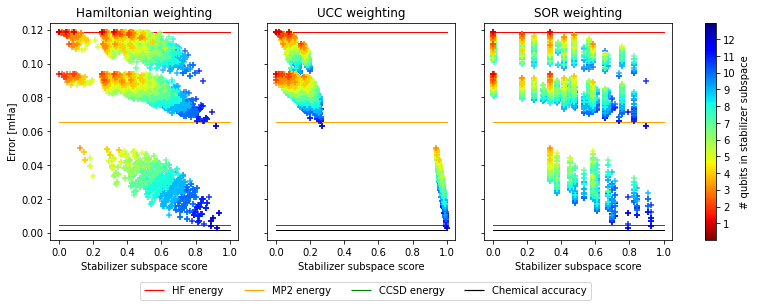

In [181]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

fig,axes = plt.subplots(1,4, sharey=True, sharex=True, 
                        gridspec_kw={'width_ratios': [10, 10, 10, 1]}, figsize=(12,4))
increments = []

def plot_data(X, axis_ind):
    axes[axis_ind].scatter(
        X, Y, 
        marker='+', 
        color=c, 
        #label = f'{ham_tap.n_qubits - stab_ind}-qubit CS-VQE', 
        zorder=stab_ind,
        alpha=0.9
    )
    axes[axis_ind].set_xlabel('Stabilizer subspace score')
    axes[axis_ind].hlines(hf_energy-fci_energy, 0, 1, ls='-', lw=1, color='red', zorder=0)
    axes[axis_ind].hlines(mp2_energy-fci_energy, 0, 1, ls='-', lw=1, color='orange', zorder=0)
    axes[axis_ind].hlines(ccsd_energy-fci_energy, 0, 1, ls='-', lw=1, color='green', zorder=0)
    axes[axis_ind].hlines(0.0016, 0, 1, ls='-', lw=1, color='black', zorder=0)

for stab_ind, data in cs_data.items():
    c_ratio = stab_ind/ham_tap.n_qubits
    increments.append(c_ratio)
    c = plt.cm.jet(c_ratio)
    X_ham, X_ucc, X_sor, Y = zip(*data)
    X_avg = [(a+b+c)/3 for a,b,c in zip(X_ham, X_ucc, X_sor)]
    X_hyb = [(a*b*c)   for a,b,c in zip(X_ham, X_ucc, X_sor)]
    Y = np.array(Y)
    Y-=fci_energy

    plot_data(X_ham, 0)
    plot_data(X_ucc, 1)
    plot_data(X_sor, 2)
    
axes[0].set_ylabel('Error [mHa]')
axes[0].set_title('Hamiltonian weighting')
axes[1].set_title('UCC weighting')
axes[2].set_title('SOR weighting')

keys = list(cs_data.keys())
cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(), cmap='jet_r'), 
                     ax=axes[3], label='# qubits in stabilizer subspace', ticks=increments, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axes[3].hlines(hf_energy-fci_energy, 0, 0, ls='-', lw=1.2, color='red', label='HF energy', zorder=0)
axes[3].hlines(mp2_energy-fci_energy, 0, 0, ls='-', lw=1.2, color='orange', label='MP2 energy', zorder=0)
axes[3].hlines(ccsd_energy-fci_energy, 0, 0, ls='-', lw=1.2, color='green', label='CCSD energy', zorder=0)
axes[3].hlines(0.0016, 0, 0, ls='-', lw=1.2, color='black', label='Chemical accuracy', zorder=0)
    
axes[3].set_visible(False)    
    
fig.legend(loc="lower center", bbox_to_anchor=(.49,-.1), ncol=4)

In [182]:
fig.savefig('plots/'+speciesname+'_stab_score_vs_error.png', dpi=300, bbox_inches='tight')